# Bachelor Thesis: Creating a Sentiment Index for Swiss companies using News Articles of the Neue Zürcher Zeitung (NZZ)

__Author__: Jannick Sicher

The following Jupyter notebook provides the code for the creation of the sentiment index. The sentiment index is created based on news articles received by the GBI-Genios database, which primarily consists of Neue Zürcher Zeitung (NZZ) articles over a time period of two years. The sentiment index analyses four Swiss based companies, namely the UBS Group, Nestlé SA, Novartis AG, and La-Hofmann-Roche AG.

## Initial Configurations and Packages

In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import json
from watson_developer_cloud import DiscoveryV1
import requests
from nytimesarticle import articleAPI
import time
import nltk
from bs4 import BeautifulSoup as soup
import bs4 as bs
import requests
import re
import quandl
from textblob import TextBlob
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
from bs4 import BeautifulSoup
import matplotlib
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from textblob_de import TextBlobDE
from urllib.request import urlopen as uReq
from sklearn.preprocessing import StandardScaler
import datetime
import backtrader as bt
import backtrader.feeds as btfeed
import backtrader.indicators as btind
from IPython.display import clear_output
plt.style.use('ggplot')

### Quandl Authentification
quandl.ApiConfig.api_key = "4e_fG9_V8Xur9cnx9-Ys"

## Sentiment Index with NZZ Articles

## Analysis of UBS

### Loading Articles

In [2]:
a_list = []
for n in range(1,9):    
    sauce = open('UBS_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [3]:
UBS_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
UBS_NZZ_df.head()

date                                               text
0  16.05.2018  Matthias Müller, Peking\n\nDie UBS hat vor zwe...
1  12.05.2018  Die Regionalbanken fühlen\nsich vom Branchenve...
2  04.05.2018  Ermes Gallarotti\n\nDie UBS will ihren Anteil ...
3  27.04.2018                         Starkes Investment Banking
4  26.04.2018  (awp) · Der Schweizer Aktienmarkt hat am Mittw...

## Sentiment Analysis with the Weighted SentiWS Dictionary

In [4]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [5]:
# Apply tokenizer to UBS
UBS_NZZ_df['tokens'] = UBS_NZZ_df['text'].apply(tokenize)

In [6]:
def get_words(name):
    df = pd.read_table(name,header=None,names=['word','weight','words'])
    words_1 = ''
    weights = []
    for i, row in df.iterrows():

        col1 = row['word']
        weight = row['weight']
        col2 = row['words']
        w=''
        for c in col1:
            if c == '|':
                w+='\n'
                break
            w += c
        words_1 += w

        w = ''
        count = 0
        if pd.notnull(col2):
            for c in col2:
                if c == ',':
                    words_1 += w+'\n'
                    w=''
                    count += 1
                    c=''
                w+=c
            words_1 += w +'\n'
            count+=1
        weight = row['weight']
        weights.append(weight)
        for w in range(count):
            weights.append(weight)
        
    return words_1,weights

In [7]:
pos_words,pos_weights = get_words('SentiWS_v1.8c_Positive.txt')
neg_words,neg_weights = get_words('SentiWS_v1.8c_Negative.txt')

In [8]:
# Text mine function for UBS
def text_mine_articles(UBS_NZZ_df, bag_of_words,weights,alignment):
    
    bag_of_words = tokenize(bag_of_words)


    UBS_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    count=0
    for j in range(0, len(UBS_NZZ_df)):
        # Convert article body into a list of tokens
        tokenized_article = tokenize(UBS_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        amount = 0
        count_2 = 0
        for word in occurrences:
            
            index = bag_of_words.index(word)
            weight = weights[index]

            amount += weight
            count_2+=1
        # Copy amount of occurrences found to the dataframe
        #amount = len(occurrences)
        UBS_NZZ_df.at[j,'num_occurr_'+alignment] = amount*10000
        count+=1
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return UBS_NZZ_df

In [9]:
UBS_NZZ_df = text_mine_articles(UBS_NZZ_df, pos_words,pos_weights,'pos')
UBS_NZZ_df['num_occurr_pos'] = UBS_NZZ_df['num_occurr_pos']/ 10000
UBS_NZZ_df = text_mine_articles(UBS_NZZ_df, neg_words, neg_weights,'neg')
UBS_NZZ_df['num_occurr_neg'] = UBS_NZZ_df['num_occurr_neg']/ 10000

Text mine articles...
Done!
Text mine articles...
Done!


In [10]:
# Threshold Function
def binarize(sentiment_value):#, word_count, word_diversity):
    if sentiment_value > 0:
        return 'pos'
    elif sentiment_value < -0.5:
        return 'neg'
    else:
        return 'neutral'

In [11]:
## Sentiment Score UBS
# The following function provides a simple function to create a sentiment score
UBS_NZZ_df['sentiment_score'] = UBS_NZZ_df['num_occurr_pos'] + UBS_NZZ_df['num_occurr_neg']
UBS_NZZ_df['sentiment_value'] = UBS_NZZ_df['sentiment_score'].apply(binarize)

In [12]:
# Create .dt.date format
UBS_NZZ_df['datetime'] = pd.to_datetime(UBS_NZZ_df['date'],format='%d.%m.%Y')
UBS_NZZ_df.at[0,'datetime']
UBS_NZZ_df.groupby('sentiment_value').count()

date  text  tokens  num_occurr_pos  num_occurr_neg  \
sentiment_value                                                       
neg               152   152     152             152             152   
neutral           121   121     121             121             121   
pos               109   109     109             109             109   

                 sentiment_score  datetime  
sentiment_value                             
neg                          152       152  
neutral                      121       121  
pos                          109       109

In [13]:
# Normalized Sentiment: Positive
UBS_NZZ_df['Pos_Normal'] = (UBS_NZZ_df['num_occurr_pos'] - np.mean(UBS_NZZ_df['num_occurr_pos'])/(np.std(UBS_NZZ_df['num_occurr_pos'])))

# Normalized Sentiment: Negative
UBS_NZZ_df['Neg_Normal'] = (UBS_NZZ_df['num_occurr_neg'] - np.mean(UBS_NZZ_df['num_occurr_neg'])/(np.std(UBS_NZZ_df['num_occurr_neg'])))

# Normalized Sentiment Score
UBS_NZZ_df['sentiment_score_norm'] = UBS_NZZ_df['Pos_Normal'] + UBS_NZZ_df['Neg_Normal']

### Validation of Sentiment Scores

In [14]:
'''
Validation function
'''

# Color Selection
NEG = '\x1b[31m'
POS = '\x1b[32m'
END = '\x1b[0m'

def colorize_neg(text):
    return NEG + text + END

def colorize_pos(text):
    return POS + text + END

i = 0
for neg, pos, t in zip(UBS_NZZ_df['num_occurr_neg'].values, UBS_NZZ_df['num_occurr_pos'].values, UBS_NZZ_df['text'].values):
    print("\n" + "-" * 100)
    print("--- Prediction: {}".format(pos + neg))
    print("-" * 100)
    
    text = t
    for posword in pos_words.splitlines():
        text = re.sub(r'\b{}\b'.format(posword), colorize_pos(posword), text)
    for negword in neg_words.splitlines():
        text = re.sub(r'\b{}\b'.format(negword), colorize_neg(negword), text)
    
    print(text)
    if i == 10:
        break
    i += 1


----------------------------------------------------------------------------------------------------
--- Prediction: -1.9325
----------------------------------------------------------------------------------------------------
Matthias Müller, Peking

Die UBS hat vor zwei Wochen den Anfang gemacht, andere ausländische Institute folgen nun dem Beispiel und wollen nach der angekündigten Öffnung des chinesischen Finanzsektors ihre Anteile an bestehenden Joint Ventures auf 51% erhöhen. Zweiter im Bund ist mit Nomura das grösste im japanischen Wertschriftenhandel und Investment Banking tätige Finanzinstitut.

Die China Securities Regulatory Commission hat vor wenigen Tagen bestätigt, von Nomura die Bewerbung erhalten zu haben, um an einem auf Wertpapierhandel fokussierten Joint Venture den Mehrheitsanteil von 51% zu erwerben. Auch von der amerikanischen Grossbank JP Morgan ist bekannt, dass sie ihre Unterlagen eingereicht hat, um künftig die mehrheitlichen Anteile an einer Kooperation im We

Ermes Gallarotti

Die UBS will ihren Anteil am chinesischen Joint Venture UBS Securities Co. Ltd. von derzeit 25 auf 51% erhöhen und sich damit eine Mehrheit sichern. Die Schweizer Grossbank trägt bereits heute die Verantwortung für die operative Führung der Investment-Banking-Gesellschaft, die schwergewichtig im Wertschriftenhandel tätig ist. Erst dieser Tage hatte die chinesische Regierung neue Bestimmungen in Kraft gesetzt, die es ausländischen Banken erlauben, Mehrheitsbeteiligungen an einheimischen Finanzgesellschaften zu erwerben. Vorher durften sie Anteile von maximal 49% an chinesischen Unternehmen halten. Die UBS hat bei der zuständigen Aufsichtsbehörde CSRC (China Securities Regulatory Commission) einen entsprechenden Antrag eingereicht. Neben der UBS sind vier chinesische Gesellschaften an UBS Securities beteiligt.

Ein Strauss von Beteiligungen
Neben der 2006 gegründeten UBS Securities, die ihrerseits die im Futures-Handel engagierte Tochtergesellschaft UBS Futures kontroll

Hart geprüfte Aktionäre

----------------------------------------------------------------------------------------------------
--- Prediction: -0.3476999999999999
----------------------------------------------------------------------------------------------------
(awp) · Der Schweizer Aktienmarkt ist mit wenig veränderten Notierungen in die neue Woche gestartet. Für Druck sorgten die schwachen UBS-Papiere nach Quartalszahlen, während die Roche-Titel Gegensteuer gaben. Insgesamt aber dämpfen die weiter steigenden Zinsen die Kauflaune der Börsianer. Denn die steigenden Anleiherenditen gelten als Gradmesser für die Inflationserwartungen und damit für die Geldpolitik. Der Swiss-Market-Index (SMI) schloss am Montag unverändert bei 8807 Punkten. Der breite Swiss-Performance-Index (SPI) stieg um 0,1% auf 10 421 Punkte. Bei den 30 wichtigsten Titel kamen auf 22 Gewinner 7 Verlierer, die Aktien von SGS schlossen unverändert. Die Titel der UBS büssten nach Quartalszahlen 2,5% ein. Das Institut ha

In [15]:
# Creates a function that computes the mean value for each day 
unique_dates = UBS_NZZ_df['date'].unique()

UBS_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = UBS_NZZ_df.loc[UBS_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    sentiment_normal_mean = same_date['sentiment_score_norm'].mean()
    UBS_NZZ_other_df = UBS_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean, 
                                                'sentiment_norm': sentiment_normal_mean}, ignore_index=True)


In [16]:
UBS_NZZ_other_df['date']=pd.to_datetime(UBS_NZZ_other_df['date'],format='%d.%m.%Y')
UBS_NZZ_other_df.sort_values(by='date').head()

date  sentiment  sentiment_norm
256 2016-05-28  -0.404500       -0.379474
255 2016-06-02  -0.509967       -0.484940
254 2016-06-04   0.000000        0.025026
253 2016-06-10   0.561700        0.586726
252 2016-06-15  -1.145900       -1.120874

### Visualising Results

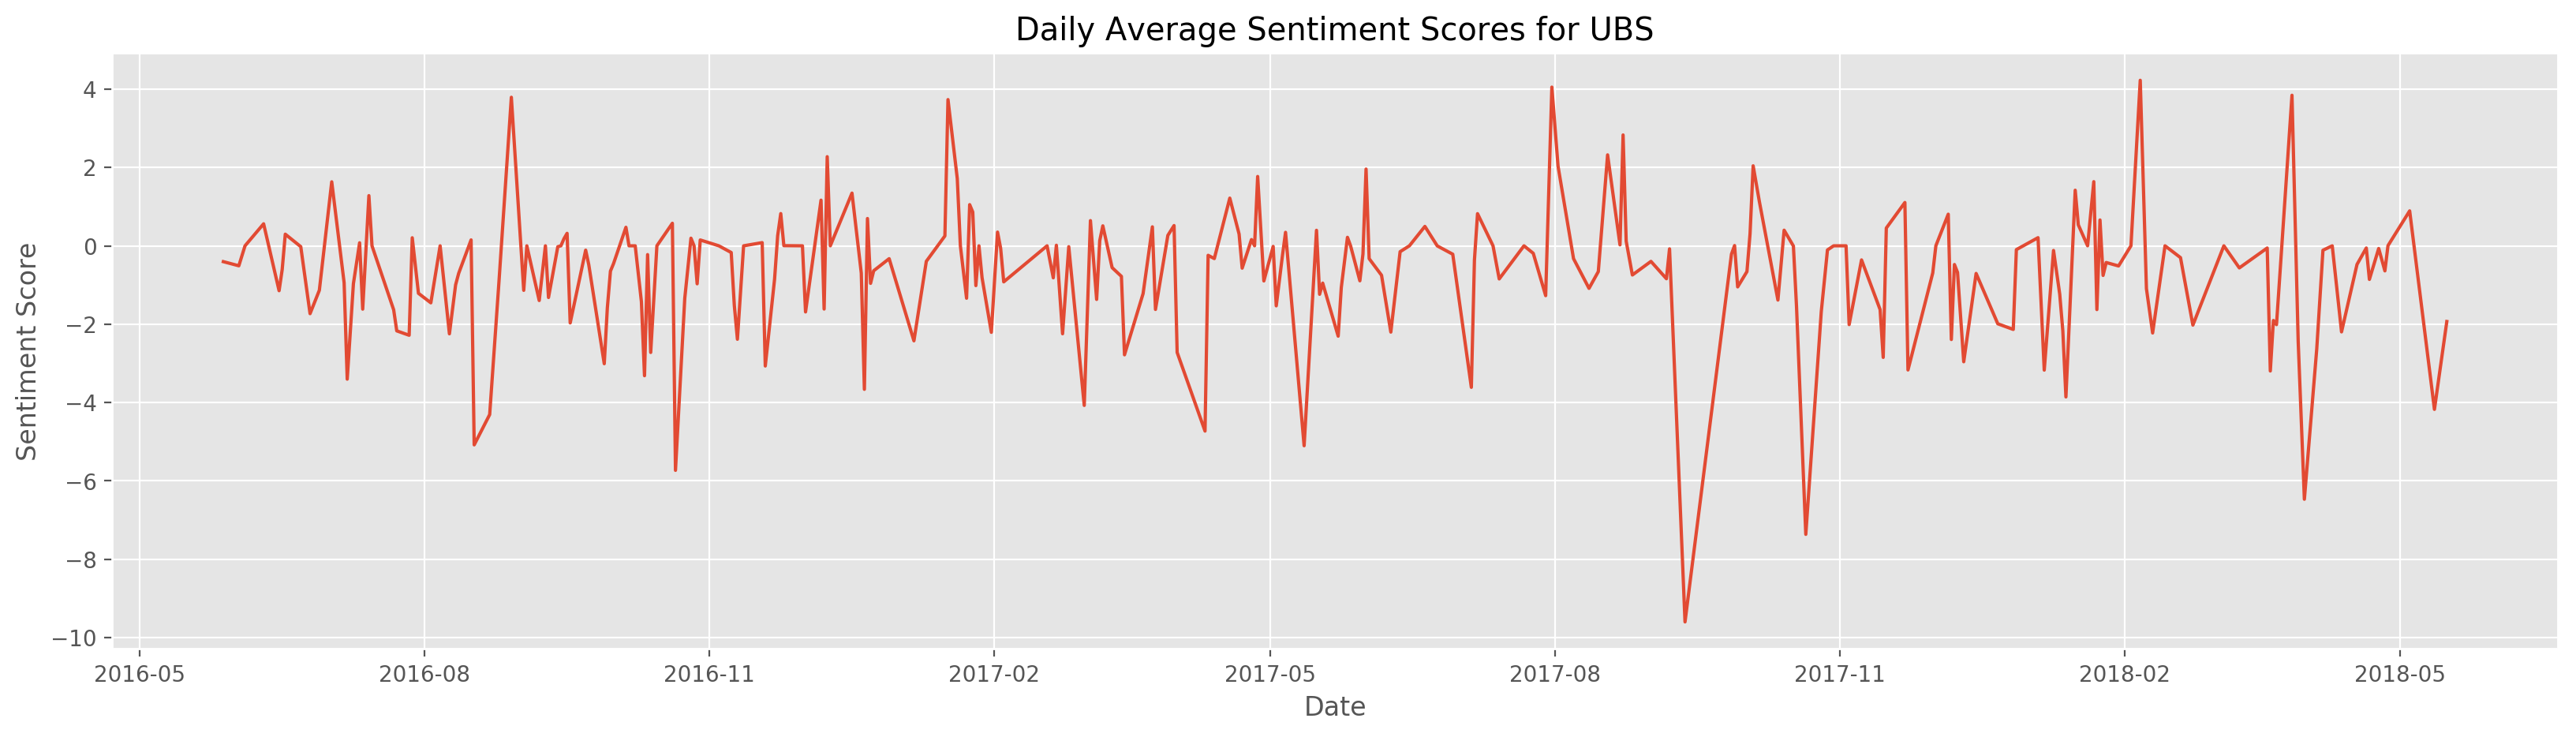

In [17]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Average Sentiment Scores for UBS')
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['sentiment'])
plt.show()

In [18]:
UBS_NZZ_other_df['10 Days Rolling'] = UBS_NZZ_other_df['sentiment'].rolling(10).mean()
UBS_NZZ_other_df['20 Days Rolling'] = UBS_NZZ_other_df['sentiment'].rolling(20).mean()

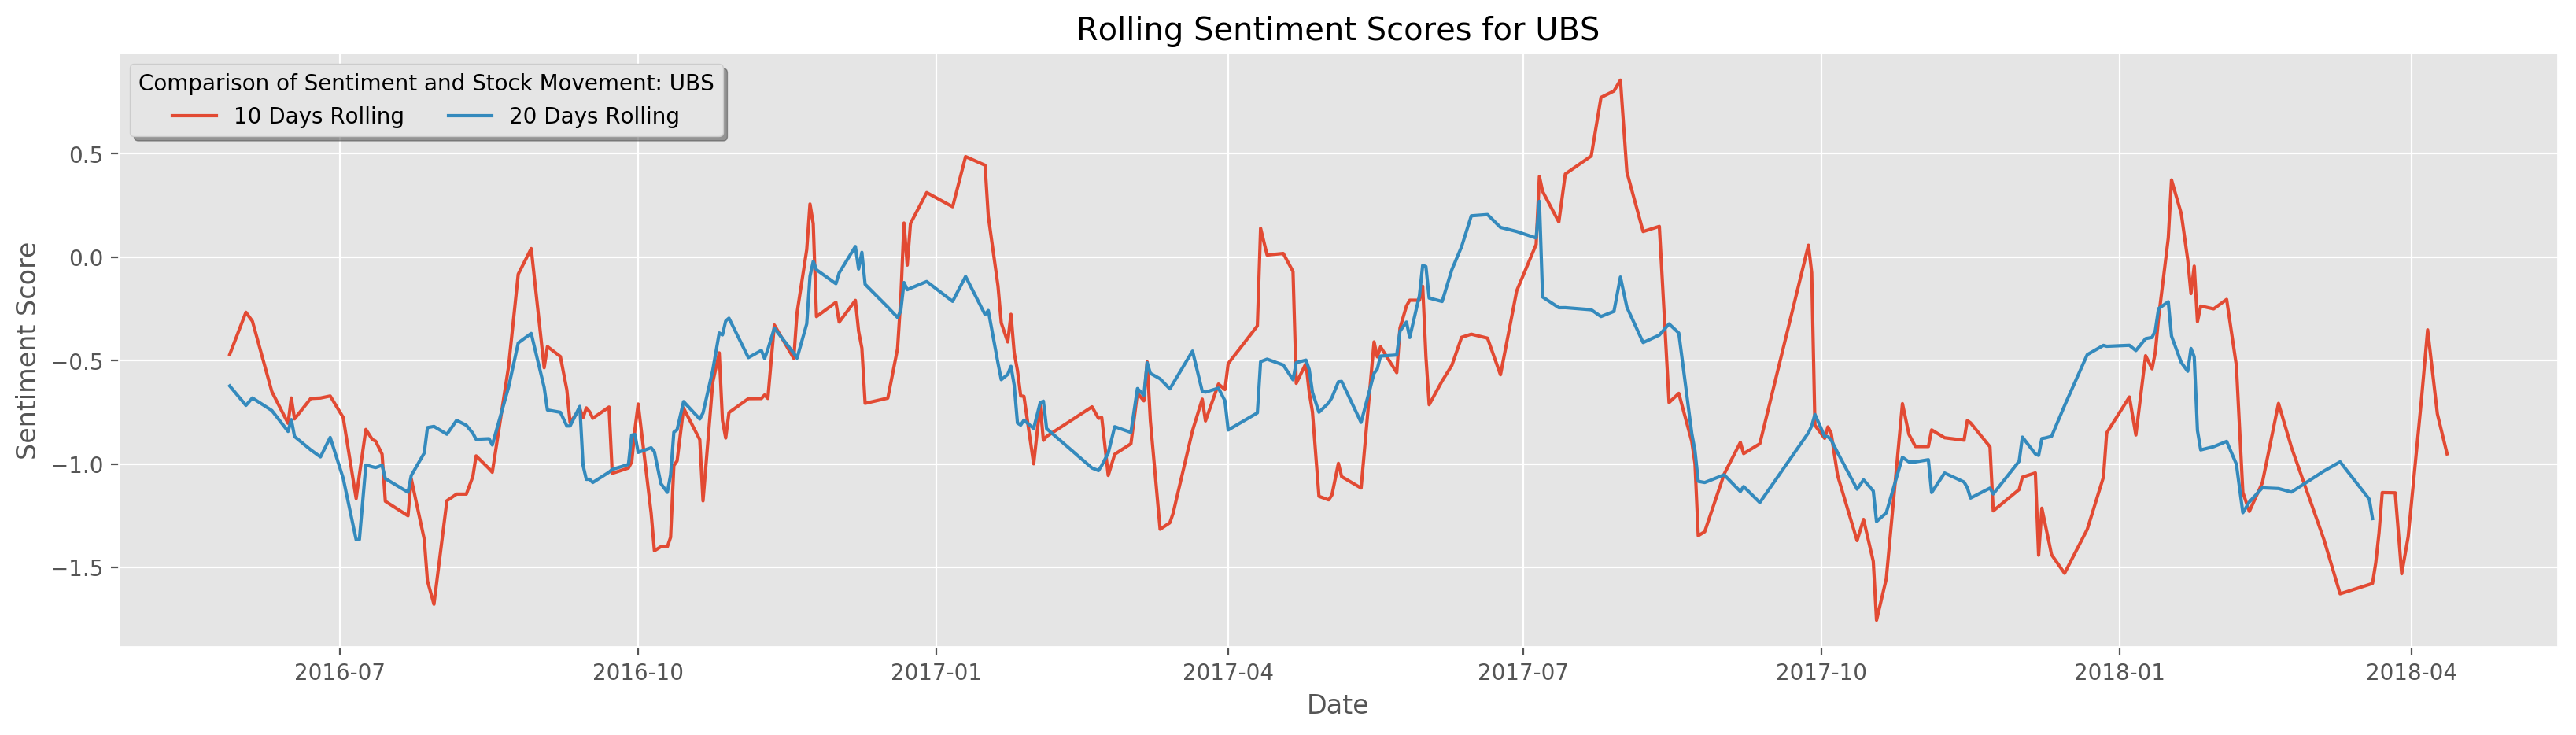

In [19]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Rolling Sentiment Scores for UBS')
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['10 Days Rolling'])
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['20 Days Rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: UBS', fancybox=True)
plt.plot()
plt.show()

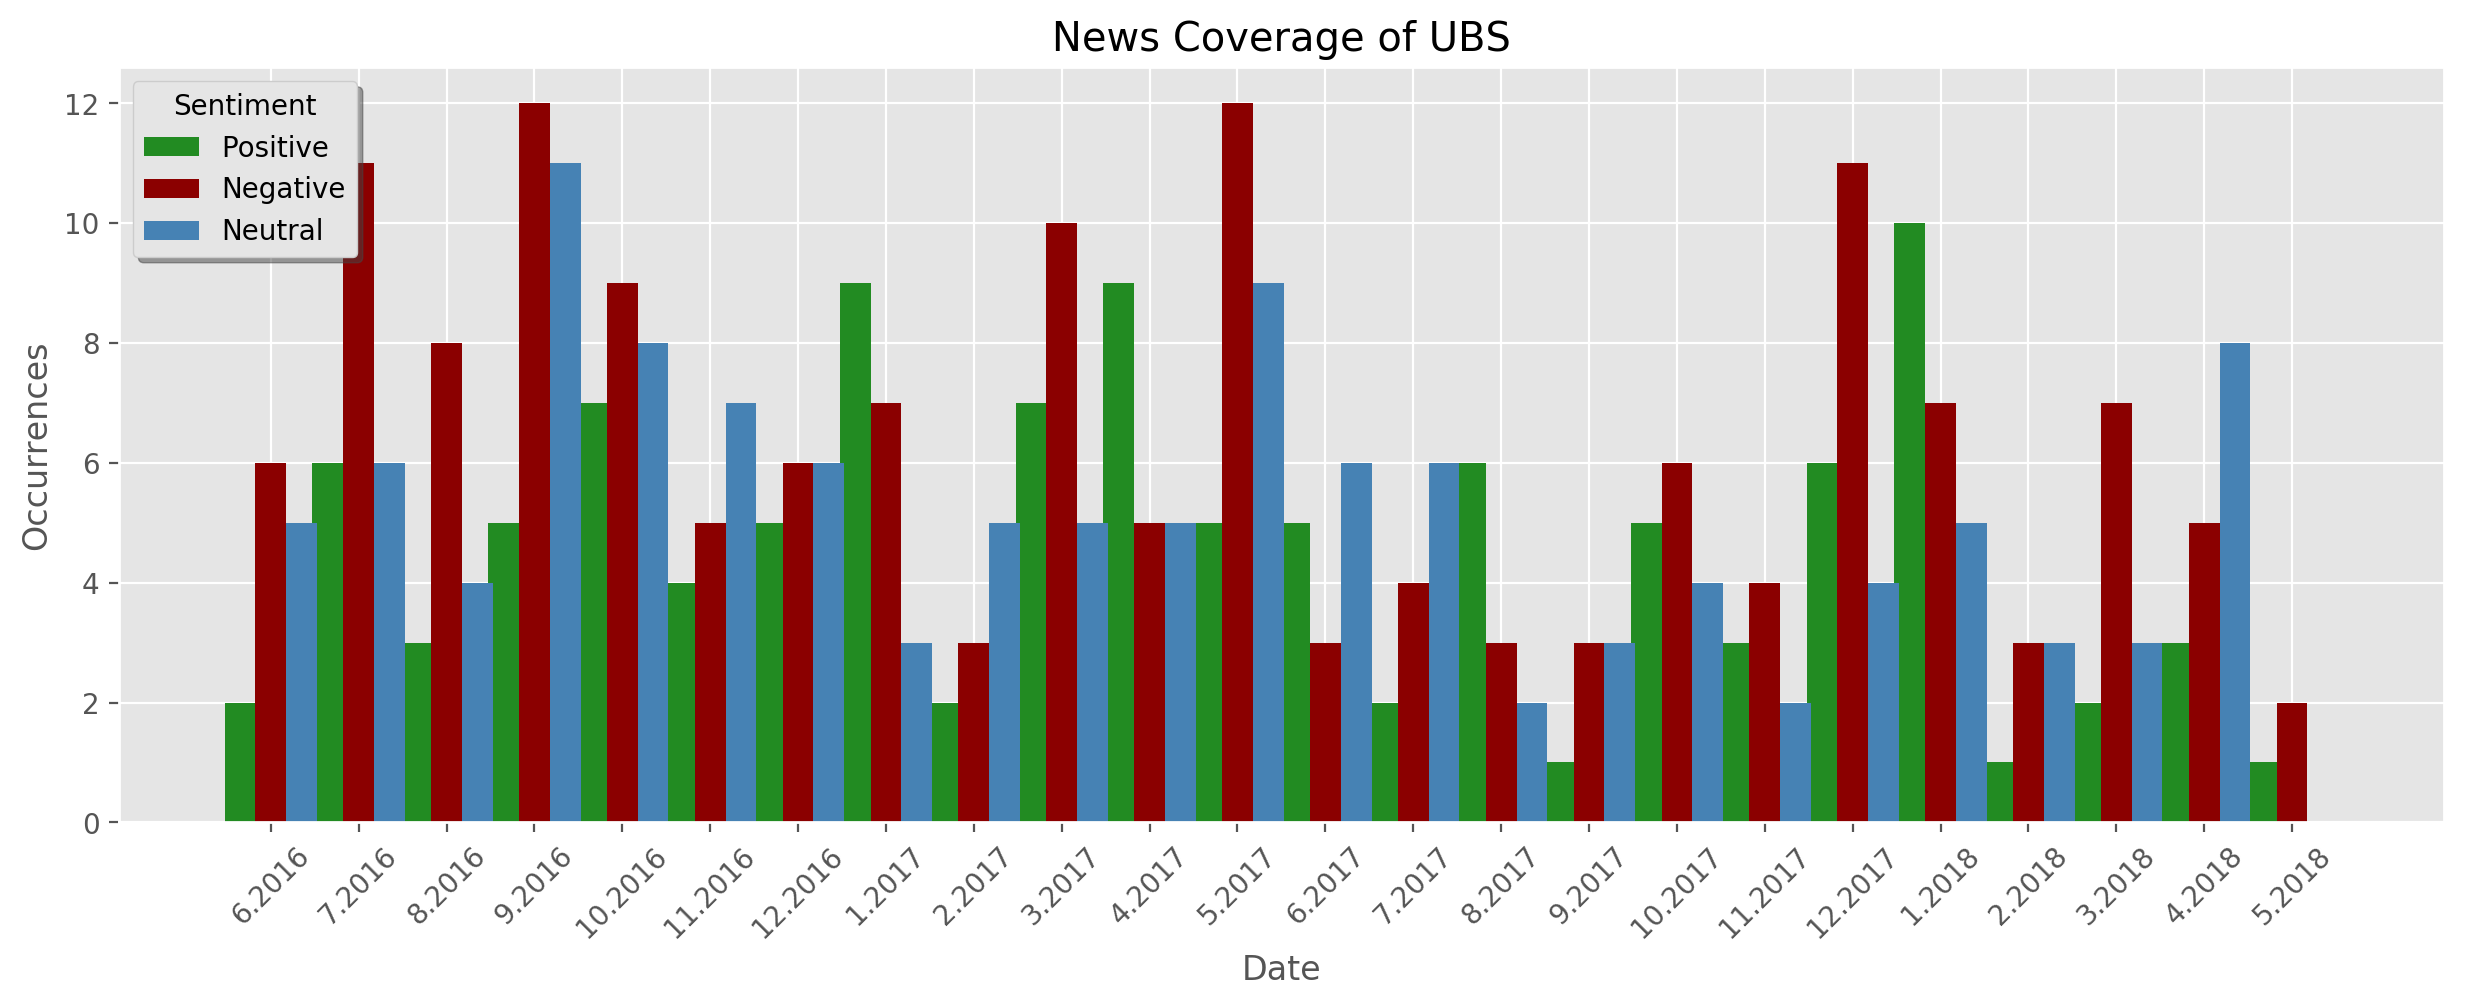

In [20]:
# Bar Chart summarising the sentiment of each month
import numpy as np
import matplotlib.pyplot as plt
years = [2016,2017,2018]
months = [x for x in range(1,13)]

fig, ax = plt.subplots(figsize=(15,5),dpi=200)

#ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
opacity = 1
bar_df=pd.DataFrame()
bar_df['date'] = pd.to_datetime(UBS_NZZ_df['date'],format='%d.%m.%Y')
bar_df['sentiment_value'] = UBS_NZZ_df['sentiment_value']
bar_df['ones'] = 1
bar_df = bar_df.pivot_table(index='date',columns='sentiment_value',values='ones',aggfunc=sum)
#bar_df = pd.melt(bar_df,id_vars=['date'],value_vars=['sentiment_value'])
bar_df.fillna(0,inplace=True)
bar_df_2 =[]

for y in years:
    for m in months:
        temp = bar_df.loc[(bar_df.index.month == m) & (bar_df.index.year==y)]
        pos = np.sum(temp['pos'])
        neg = np.sum(temp['neg'])
        neutral = np.sum(temp['neutral'])
        bar_df_2.append([str(m)+'.'+str(y),pos,neg,neutral])
from matplotlib.dates import date2num

bar_df_2 = pd.DataFrame(bar_df_2,columns=['date','pos','neg','neutral'])
bar_df_2.drop([0,1,2,3,4,29,30,31,32,33,34,35], inplace = True, axis = 0)

plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.title('News Coverage of UBS')
p1 = ax.bar(bar_df_2.index-0.35, bar_df_2['pos'], width, color='forestgreen', align='center', label = 'Positive', alpha=opacity)
p2 = ax.bar(bar_df_2.index, bar_df_2['neg'], width, color='darkred', align='center', label = 'Negative', alpha=opacity)
p3 = ax.bar(bar_df_2.index+0.35, bar_df_2['neutral'], width, color='steelblue', align='center', label = 'Neutral', alpha=opacity)
ax.set_xticks(bar_df_2.index)
ax.set_xticklabels(bar_df_2['date'])
plt.xticks(rotation=45)

plt.legend(loc="upper left", shadow = True, handles=[p1, p2, p3], title = 'Sentiment', fancybox = True)
plt.savefig('UBS_BarChart.eps', format='eps', dpi=1000)
plt.show()


## Analysis of Nestle

### Loading Articles

In [21]:
a_list = []
for n in range(1,17):    
    sauce = open('Nestle_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])

In [22]:
Nestle_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Nestle_NZZ_df.head()

date                                               text
0  20.05.2018  Kleine und mittlere global tätige Unternehmen ...
1  19.05.2018  (awp) · Der Schweizer Aktienmarkt hat am Freit...
2  15.05.2018  Der Schwarze Kontinent hat schon viele Investo...
3  12.05.2018                    Konzernverantwortungsinitiative
4  09.05.2018  (awp) · Der Schweizer Aktienmarkt hat am Diens...

## Sentiment Analysis with Weighted SentiWS Dictionary

In [23]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [24]:
# Apply tokenizer to UBS
Nestle_NZZ_df['tokens'] = Nestle_NZZ_df['text'].apply(tokenize)

In [25]:
def get_words(name):
    df = pd.read_table(name,header=None,names=['word','weight','words'])
    words_1 = ''
    weights = []
    for i, row in df.iterrows():

        col1 = row['word']
        weight = row['weight']
        col2 = row['words']
        w=''
        for c in col1:
            if c == '|':
                w+='\n'
                break
            w += c
        words_1 += w

        w = ''
        count = 0
        if pd.notnull(col2):
            for c in col2:
                if c == ',':
                    words_1 += w+'\n'
                    w=''
                    count += 1
                    c=''
                w+=c
            words_1 += w +'\n'
            count+=1
        weight = row['weight']
        weights.append(weight)
        for w in range(count):
            weights.append(weight)
        
    return words_1,weights

pos_words,pos_weights = get_words('SentiWS_v1.8c_Positive.txt')
neg_words,neg_weights = get_words('SentiWS_v1.8c_Negative.txt')

In [26]:
# Text mine function for Nestle
def text_mine_articles(Nestle_NZZ_df, bag_of_words,weights,alignment):
    
    bag_of_words = tokenize(bag_of_words)


    Nestle_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    count=0
    for j in range(0, len(Nestle_NZZ_df)):
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Nestle_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        amount = 0
        count_2 = 0
        for word in occurrences:
            
            index = bag_of_words.index(word)
            weight = weights[index]

            amount += weight
            count_2+=1
        # Copy amount of occurrences found to the dataframe
        #amount = len(occurrences)
        Nestle_NZZ_df.at[j,'num_occurr_'+alignment] = amount*10000
        count+=1   
   
    print('Done!')
 
    return Nestle_NZZ_df

In [27]:
Nestle_NZZ_df = text_mine_articles(Nestle_NZZ_df, pos_words,pos_weights,'pos')
Nestle_NZZ_df['num_occurr_pos'] = Nestle_NZZ_df['num_occurr_pos']/ 10000
Nestle_NZZ_df = text_mine_articles(Nestle_NZZ_df, neg_words, neg_weights,'neg')
Nestle_NZZ_df['num_occurr_neg'] = Nestle_NZZ_df['num_occurr_neg']/ 10000

Text mine articles...
Done!
Text mine articles...
Done!


In [28]:
# Threshold Function
def binarize(sentiment_value):#, word_count, word_diversity):
    if sentiment_value > 0:
        return 'pos'
    elif sentiment_value < -0.5:
        return 'neg'
    else:
        return 'neutral'

In [29]:
## Sentiment Score Nestle
# The following function provides a simple function to create a sentiment score
Nestle_NZZ_df['sentiment_score'] = Nestle_NZZ_df['num_occurr_pos'] + Nestle_NZZ_df['num_occurr_neg']
Nestle_NZZ_df['sentiment_value'] = Nestle_NZZ_df['sentiment_score'].apply(binarize)

In [30]:
# Create .dt.date format
Nestle_NZZ_df['datetime'] = pd.to_datetime(Nestle_NZZ_df['date'],format='%d.%m.%Y')
Nestle_NZZ_df.at[0,'datetime']
Nestle_NZZ_df.groupby('sentiment_value').count()

date  text  tokens  num_occurr_pos  num_occurr_neg  \
sentiment_value                                                       
neg               214   214     214             214             214   
neutral           218   218     218             218             218   
pos               289   289     289             289             289   

                 sentiment_score  datetime  
sentiment_value                             
neg                          214       214  
neutral                      218       218  
pos                          289       289

In [31]:
# Normalized Sentiment
Nestle_NZZ_df['Pos_Normal'] = (Nestle_NZZ_df['num_occurr_pos'] - np.mean(Nestle_NZZ_df['num_occurr_pos'])/(np.std(Nestle_NZZ_df['num_occurr_pos'])))

# Normalized Sentiment
Nestle_NZZ_df['Neg_Normal'] =(Nestle_NZZ_df['num_occurr_neg'] - np.mean(Nestle_NZZ_df['num_occurr_neg'])/(np.std(Nestle_NZZ_df['num_occurr_neg'])))

### Validation of Sentiment Scores

In [32]:
'''
Validation function
'''

# Color Selection
NEG = '\x1b[31m'
POS = '\x1b[32m'
END = '\x1b[0m'

def colorize_neg(text):
    return NEG + text + END

def colorize_pos(text):
    return POS + text + END

i = 0
for neg, pos, t in zip(Nestle_NZZ_df['num_occurr_neg'].values, Nestle_NZZ_df['num_occurr_pos'].values, Nestle_NZZ_df['text'].values):
    print("\n" + "-" * 100)
    print("--- Prediction: {}".format(pos + neg))
    print("-" * 100)
    
    text = t
    for posword in pos_words.splitlines():
        text = re.sub(r'\b{}\b'.format(posword), colorize_pos(posword), text)
    for negword in neg_words.splitlines():
        text = re.sub(r'\b{}\b'.format(negword), colorize_neg(negword), text)
    
    print(text)
    if i == 10:
        break
    i += 1


----------------------------------------------------------------------------------------------------
--- Prediction: -0.46530000000000005
----------------------------------------------------------------------------------------------------
Kleine und mittlere global tätige Unternehmen sind nicht so stark im Fokus der Finanzbranche wie die grossen. Und doch sorgen auch sie hie und da auf der grossen Bühne für Schlagzeilen: Die Firma Dätwyler aus Altdorf beispielsweise verlängert einen «Grossauftrag mit Nespresso», eine andere Erfolgsmeldung lautet: «Tesla schliesst Dreijahresvertrag mit Bossard ab». Die Liste erfreulicher Meldungen ist lang, gehören doch von den 208 an der Schweizer Börse kotierten Unternehmen 80 zu den mittelgrossen Firmen (Mid Caps) und 108 zu den kleinen (Small Caps).

Stattliche Kursgewinne
Die mittleren und kleinen Schweizer Aktien hatten in den vergangenen fünf Jahren einen fast unheimlichen Börsenlauf. Im Schnitt haben sie, die Dividenden eingerechnet, pro Jahr f

Der Schwarze Kontinent hat schon viele Investoren enttäuscht. Als zu schwankungsanfällig und politisch unberechenbar erwies sich die Geschäftsentwicklung. Dennoch gibt es immer wieder Unternehmen, die neu den Schritt wagen oder trotz Rückschlägen auf diesem Kontinent ausharren. Sie argumentieren vor allem mit dem Potenzial einer jungen Bevölkerung sowie dem grossen Rohstoffreichtum Afrikas.Dominik Feldges

Über Afrika gehen die Meinungen in der Geschäftswelt weit auseinander. Die einen wittern einen hoffnungslosen Fall, bei dem sich wegen der noch immer grassierenden Armut und der weitverbreiteten Korruption kaum etwas zu verbessern verspricht. Sie halten sich am liebsten fern. Andere hingegen sind überzeugt, dass die Zeit Afrikas gekommen ist, und schmieden Investitionspläne. Sie verweisen gerne auf den Rohstoffreichtum des Kontinents, die junge Bevölkerung sowie die stetigen Fortschritte beim Ausbau der Infrastruktur.

Optimisten auf dem Vormarsch
Das zweitgenannte Lager scheint in d

(awp) · Der Schweizer Aktienmarkt ist gut in die neue Woche gestartet. Der Swiss-Market-Index (SMI) rückte nach einem bereits von guten Vorgaben geprägten Auftakt während des Handels Schritt für Schritt weiter in Richtung der 9000-Punkte-Marke vor. Bis zum Börsenschluss kletterte der SMI um 0,84% auf 8978 Punkte. Zu Handelsbeginn hatte der SMI verglichen mit Ende letzter Woche wenig verändert noch bei 8895 Stellen notiert.

Der 30 Aktien umfassende Swiss-Leader-Index (SLI) zog am Berichtstag um 0,82% auf 1484 Zähler und der breite Swiss-Performance-Index (SPI) um 1,17% auf 10 682 Punkte an. Dabei stand im SLI mit UBS nur eine Aktie im Minus und der Rest im Plus. Getragen wurde die Aufwärtsbewegung von den Schwergewichten Nestlé und Novartis, die mit vielversprechenden Nachrichten aufwarteten. Ausserdem gab die Stärke des US-Dollars vor allem den vom Export getriebenen Branchen Rückenwind. Die Dollarstärke beziehungsweise der schwächere Franken sei lange zu wenig in die Kurse von Schwei

Indien hat unter internationalen Fachkräften ein Reputations­problem. Dass immer weniger Expats nach Indien kommen, hat allerdings auch andere Gründe. Und was die Expats stört, belastet auch die einheimische Bevölkerung in hohem Mass.

Volker Pabst, Delhi

Wer sich um Indiens Ruf im Ausland sorgt, hat schlechte Wochen hinter sich. Zuerst gelangte das Land einmal mehr wegen brutalster Sexualverbrechen in die Schlagzeilen, wobei es sich diesmal um besonders schändliche Vorgänge handelte. Nicht nur war eines der Opfer ein achtjähriges Mädchen, sondern es solidarisierten sich zudem noch hochrangige Vertreter der Regierungspartei aus politischen Gründen mit den Tätern. Und vor einigen Tagen nun veröffentlichte die Weltgesundheitsorganisation (WHO) die jüngsten Zahlen zur weltweiten Luftqualität. Die 14 am stärksten verschmutzten Städte der Welt liegen allesamt in Indien. Erst auf Rang 15 kommt mit Baoding eine Stadt in China.

Familien kommen kaum mehr
Sexuelle Gewalt und die dramatische Lu

In [33]:
# Creates a function that computes the mean value for each day 
unique_dates = Nestle_NZZ_df['date'].unique()

Nestle_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Nestle_NZZ_df.loc[Nestle_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Nestle_NZZ_other_df = Nestle_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [34]:
Nestle_NZZ_other_df['date']=pd.to_datetime(Nestle_NZZ_other_df['date'],format='%d.%m.%Y')
Nestle_NZZ_other_df.sort_values(by='date').head()

date  sentiment
464 2016-05-24    -1.0045
463 2016-05-27    -0.8368
462 2016-05-28    -1.2446
461 2016-05-31    -0.4727
460 2016-06-01    -3.5675

### Visualising Results

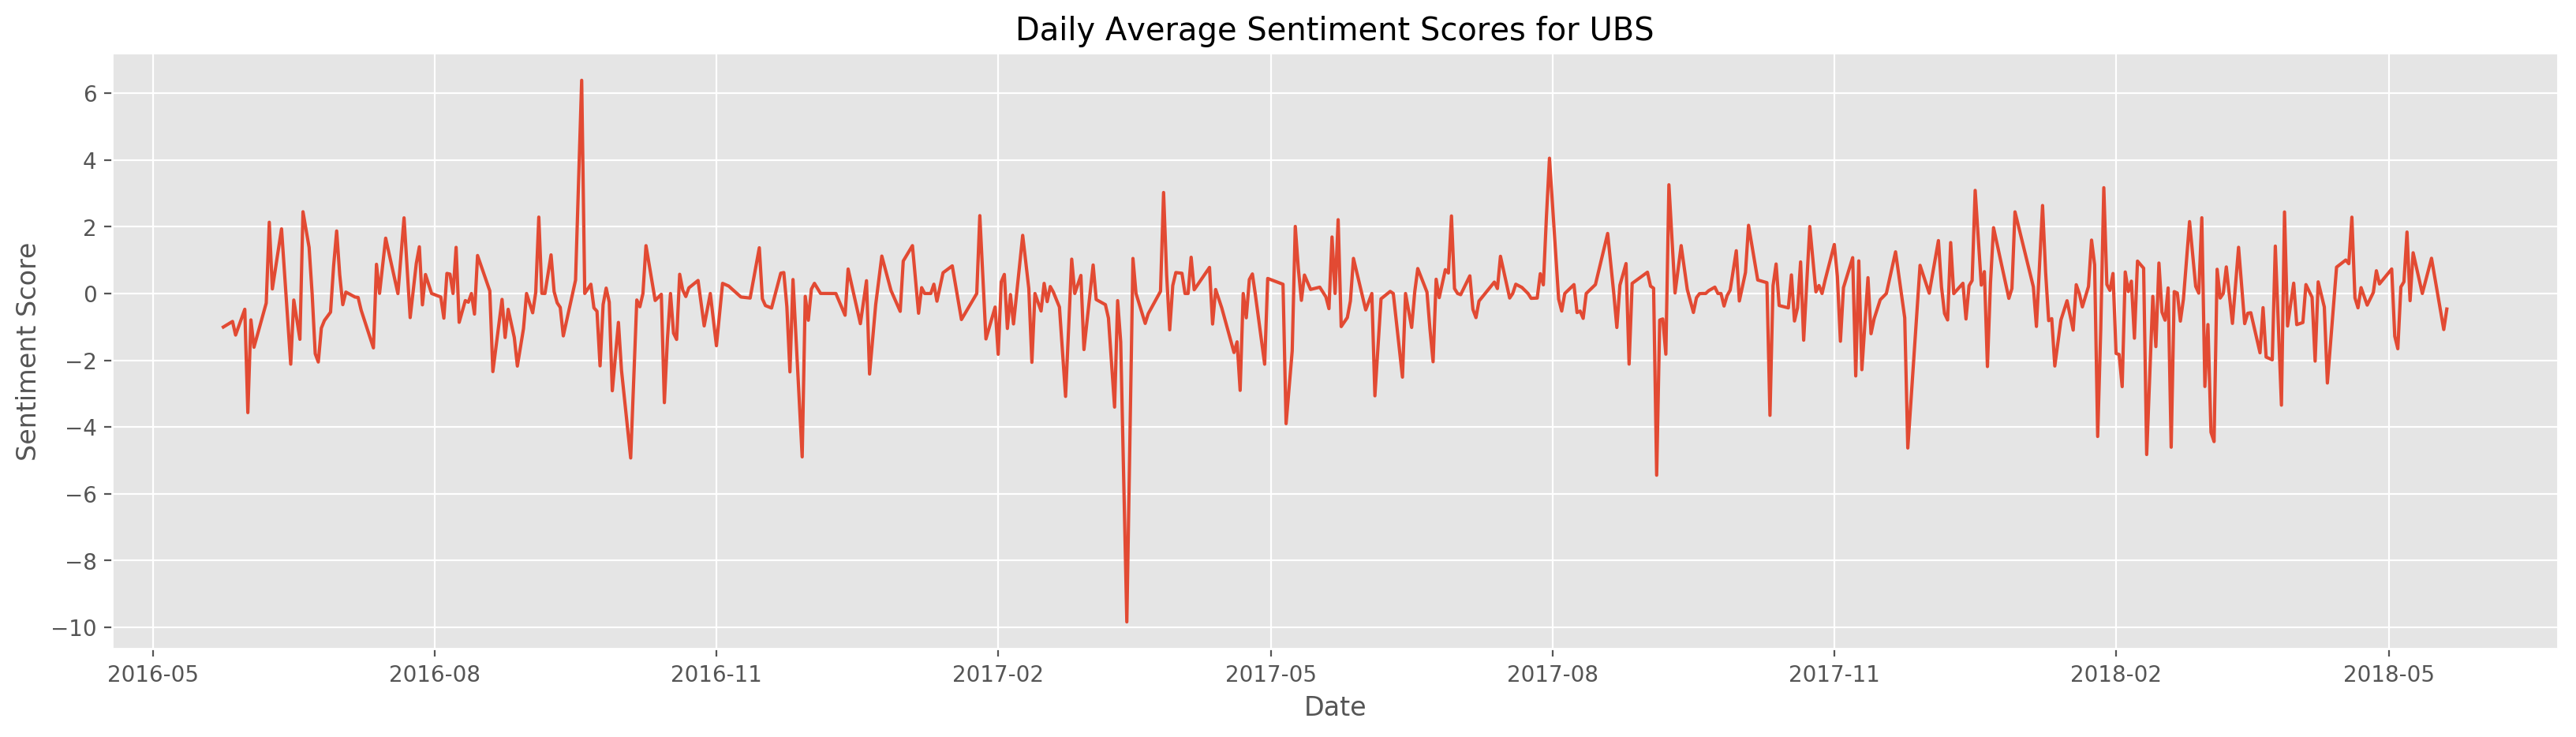

In [35]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Average Sentiment Scores for UBS')
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['sentiment'])
plt.show()

In [36]:
Nestle_NZZ_other_df['10 Days Rolling'] = Nestle_NZZ_other_df['sentiment'].rolling(10).mean()
Nestle_NZZ_other_df['20 Days Rolling'] = Nestle_NZZ_other_df['sentiment'].rolling(20).mean()

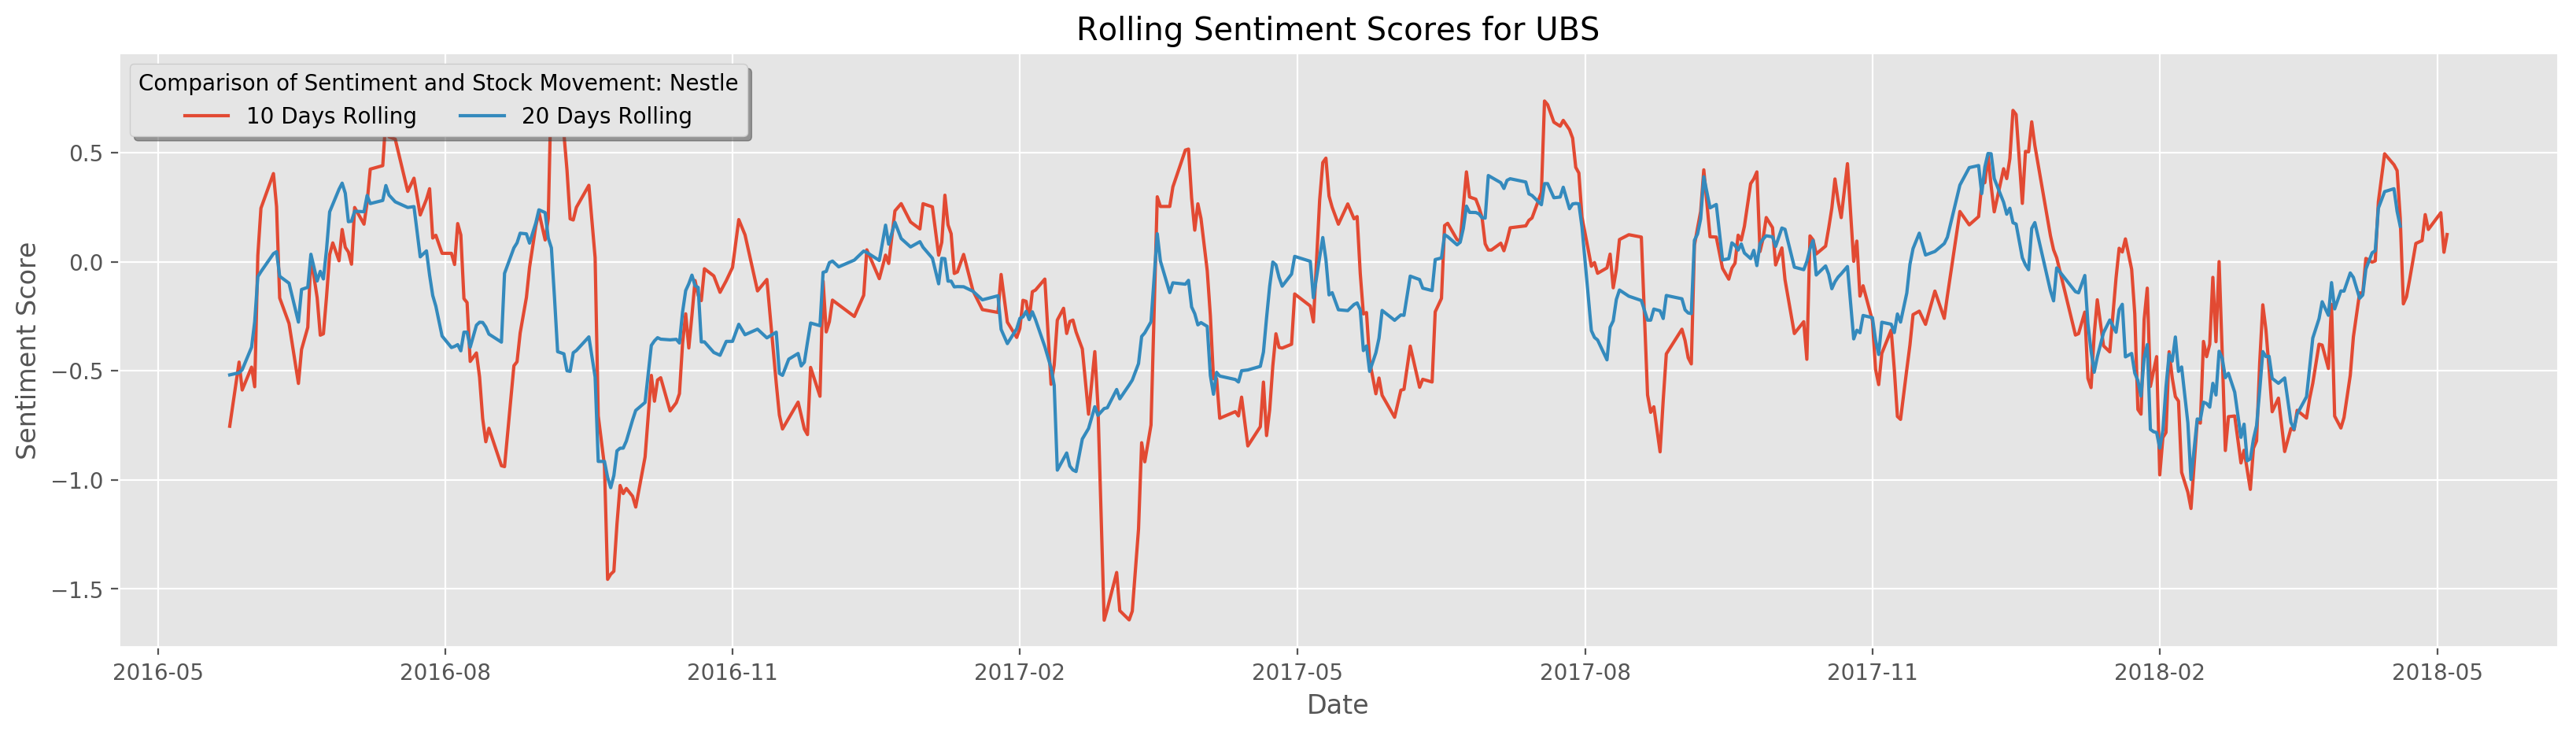

In [37]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Rolling Sentiment Scores for UBS')
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['10 Days Rolling'])
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['20 Days Rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: Nestle', fancybox=True)
plt.plot()
plt.show()

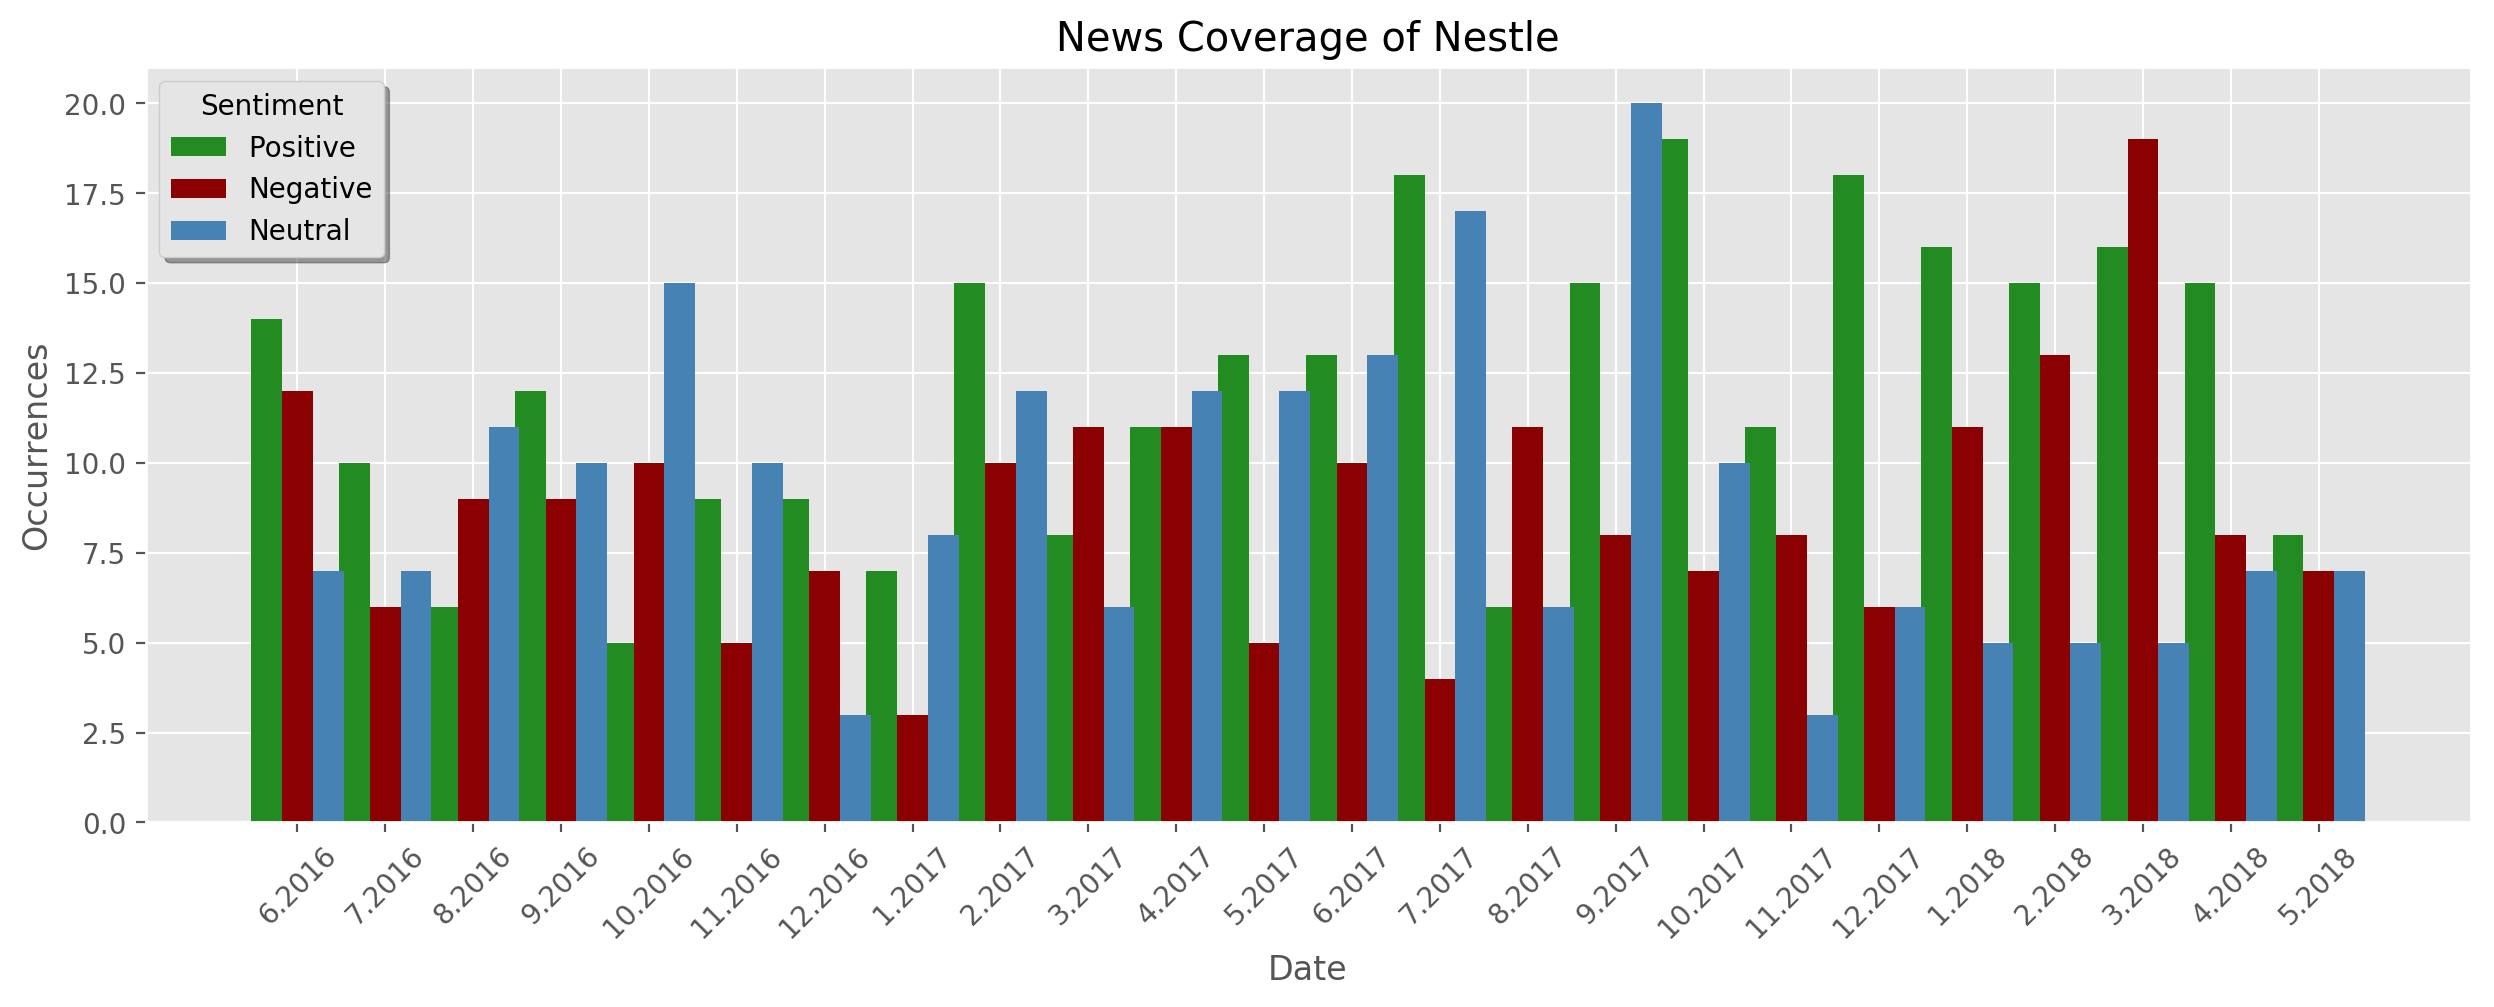

In [38]:
# Bar Chart summarising the sentiment of each month
import numpy as np
import matplotlib.pyplot as plt
years = [2016,2017,2018]
months = [x for x in range(1,13)]

fig, ax = plt.subplots(figsize=(15,5),dpi=200)

#ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
bar_df=pd.DataFrame()
bar_df['date'] = pd.to_datetime(Nestle_NZZ_df['date'],format='%d.%m.%Y')
bar_df['sentiment_value'] = Nestle_NZZ_df['sentiment_value']
bar_df['ones'] = 1
bar_df = bar_df.pivot_table(index='date',columns='sentiment_value',values='ones',aggfunc=sum)
#bar_df = pd.melt(bar_df,id_vars=['date'],value_vars=['sentiment_value'])
bar_df.fillna(0,inplace=True)
bar_df_2 =[]

for y in years:
    for m in months:
        temp = bar_df.loc[(bar_df.index.month == m) & (bar_df.index.year==y)]
        pos = np.sum(temp['pos'])
        neg = np.sum(temp['neg'])
        neutral = np.sum(temp['neutral'])
        bar_df_2.append([str(m)+'.'+str(y),pos,neg,neutral])
from matplotlib.dates import date2num

bar_df_2 = pd.DataFrame(bar_df_2,columns=['date','pos','neg','neutral'])
bar_df_2.drop([0,1,2,3,4,29,30,31,32,33,34,35], inplace = True, axis = 0)

plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.title('News Coverage of Nestle')
p1 = ax.bar(bar_df_2.index-0.35, bar_df_2['pos'], width, color='forestgreen', align='center', label = 'Positive')
p2 = ax.bar(bar_df_2.index, bar_df_2['neg'], width, color='darkred', align='center', label = 'Negative')
p3 = ax.bar(bar_df_2.index+0.35, bar_df_2['neutral'], width, color='steelblue', align='center', label = 'Neutral')
ax.set_xticks(bar_df_2.index)
ax.set_xticklabels(bar_df_2['date'])
plt.xticks(rotation=45)

plt.legend(loc="upper left", shadow = True, handles=[p1, p2, p3], title = 'Sentiment', fancybox = True)
plt.savefig('Nestle_BarChart.eps', format='eps', dpi=1000)
plt.show()

## Analysis of Novartis

### Loading Articles of past 2 years

In [39]:
a_list = []
for n in range(1,18):    
    sauce = open('Novartis_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [40]:
Novartis_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Novartis_NZZ_df.head()

date                                               text
0  20.05.2018  Arztvisite in Kolumbien: Auch hier hat sich di...
1  20.05.2018  Novartis und Roche haben gemäss Register 2005 ...
2  20.05.2018  Hat bei Sterbenskranken jede andere Therapie v...
3  20.05.2018  Kleine und mittlere global tätige Unternehmen ...
4  20.05.2018  Franziska Pfister\n\nJoe Jimenez ist an einem ...

## Sentiment Analysis with Weighted SentiWS Dictionary

In [41]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [42]:
# Apply tokenizer to UBS
Novartis_NZZ_df['tokens'] = Novartis_NZZ_df['text'].apply(tokenize)

In [43]:
def get_words(name):
    df = pd.read_table(name,header=None,names=['word','weight','words'])
    words_1 = ''
    weights = []
    for i, row in df.iterrows():

        col1 = row['word']
        weight = row['weight']
        col2 = row['words']
        w=''
        for c in col1:
            if c == '|':
                w+='\n'
                break
            w += c
        words_1 += w

        w = ''
        count = 0
        if pd.notnull(col2):
            for c in col2:
                if c == ',':
                    words_1 += w+'\n'
                    w=''
                    count += 1
                    c=''
                w+=c
            words_1 += w +'\n'
            count+=1
        weight = row['weight']
        weights.append(weight)
        for w in range(count):
            weights.append(weight)
        
    return words_1,weights

pos_words,pos_weights = get_words('SentiWS_v1.8c_Positive.txt')
neg_words,neg_weights = get_words('SentiWS_v1.8c_Negative.txt')

In [44]:
# Text mine function for Novartis
def text_mine_articles(Novartis_NZZ_df, bag_of_words,weights,alignment):
    
    bag_of_words = tokenize(bag_of_words)


    Novartis_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    count=0
    for j in range(0, len(Novartis_NZZ_df)):
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Novartis_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        amount = 0
        count_2 = 0
        for word in occurrences:
            
            index = bag_of_words.index(word)
            weight = weights[index]

            amount += weight
            count_2+=1
        # Copy amount of occurrences found to the dataframe
        #amount = len(occurrences)
        Novartis_NZZ_df.at[j,'num_occurr_'+alignment] = amount*10000
        count+=1   
   
    print('Done!')
 
    return Novartis_NZZ_df

In [45]:
Novartis_NZZ_df = text_mine_articles(Novartis_NZZ_df, pos_words,pos_weights,'pos')
Novartis_NZZ_df['num_occurr_pos'] = Novartis_NZZ_df['num_occurr_pos']/ 10000
Novartis_NZZ_df = text_mine_articles(Novartis_NZZ_df, neg_words, neg_weights,'neg')
Novartis_NZZ_df['num_occurr_neg'] = Novartis_NZZ_df['num_occurr_neg']/ 10000

Text mine articles...
Done!
Text mine articles...
Done!


In [46]:
# Threshold Function
def binarize(sentiment_value):#, word_count, word_diversity):
    if sentiment_value > 0:
        return 'pos'
    elif sentiment_value < -0.5:
        return 'neg'
    else:
        return 'neutral'

In [47]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Novartis_NZZ_df['sentiment_score'] = Novartis_NZZ_df['num_occurr_pos'] + Novartis_NZZ_df['num_occurr_neg']
Novartis_NZZ_df['sentiment_value'] = Novartis_NZZ_df['sentiment_score'].apply(binarize)

In [48]:
# Create .dt.date format
Novartis_NZZ_df['datetime'] = pd.to_datetime(Novartis_NZZ_df['date'],format='%d.%m.%Y')
Novartis_NZZ_df.at[0,'datetime']
Novartis_NZZ_df.groupby('sentiment_value').count()

date  text  tokens  num_occurr_pos  num_occurr_neg  \
sentiment_value                                                       
neg               230   230     230             230             230   
neutral           237   237     237             237             237   
pos               318   318     318             318             318   

                 sentiment_score  datetime  
sentiment_value                             
neg                          230       230  
neutral                      237       237  
pos                          318       318

In [49]:
# Normalized Sentiment
Novartis_NZZ_df['Pos_Normal'] = (Novartis_NZZ_df['num_occurr_pos'] - np.mean(Novartis_NZZ_df['num_occurr_pos'])/(np.std(Novartis_NZZ_df['num_occurr_pos'])))

# Normalized Sentiment
Novartis_NZZ_df['Neg_Normal'] = (Novartis_NZZ_df['num_occurr_neg'] - np.mean(Novartis_NZZ_df['num_occurr_neg'])/(np.std(Novartis_NZZ_df['num_occurr_neg'])))

### Validation of Sentiment Scores

In [50]:
'''
Validation function
'''

# Color Selection
NEG = '\x1b[31m'
POS = '\x1b[32m'
END = '\x1b[0m'

def colorize_neg(text):
    return NEG + text + END

def colorize_pos(text):
    return POS + text + END

i = 0
for neg, pos, t in zip(Novartis_NZZ_df['num_occurr_neg'].values, Novartis_NZZ_df['num_occurr_pos'].values, Novartis_NZZ_df['text'].values):
    print("\n" + "-" * 100)
    print("--- Prediction: {}".format(pos + neg))
    print("-" * 100)
    
    text = t
    for posword in pos_words.splitlines():
        text = re.sub(r'\b{}\b'.format(posword), colorize_pos(posword), text)
    for negword in neg_words.splitlines():
        text = re.sub(r'\b{}\b'.format(negword), colorize_neg(negword), text)
    
    print(text)
    if i == 10:
        break
    i += 1


----------------------------------------------------------------------------------------------------
--- Prediction: 0.0
----------------------------------------------------------------------------------------------------
Arztvisite in Kolumbien: Auch hier hat sich die Anzahl ­klinischer Versuche, die Novartis und Roche durchführen, in den letzten ­Jahren ­vervielfacht.

----------------------------------------------------------------------------------------------------
--- Prediction: 0.004
----------------------------------------------------------------------------------------------------
Novartis und Roche haben gemäss Register 2005 erst 12 Studien in Brasilien durchgeführt. Im Jahr 2013 waren
es bereits 65.

----------------------------------------------------------------------------------------------------
--- Prediction: -0.8205
----------------------------------------------------------------------------------------------------
Hat bei Sterbenskranken jede andere Therapie versag

Kleine und mittlere global tätige Unternehmen sind nicht so stark im Fokus der Finanzbranche wie die grossen. Und doch sorgen auch sie hie und da auf der grossen Bühne für Schlagzeilen: Die Firma Dätwyler aus Altdorf beispielsweise verlängert einen «Grossauftrag mit Nespresso», eine andere Erfolgsmeldung lautet: «Tesla schliesst Dreijahresvertrag mit Bossard ab». Die Liste erfreulicher Meldungen ist lang, gehören doch von den 208 an der Schweizer Börse kotierten Unternehmen 80 zu den mittelgrossen Firmen (Mid Caps) und 108 zu den kleinen (Small Caps).

Stattliche Kursgewinne
Die mittleren und kleinen Schweizer Aktien hatten in den vergangenen fünf Jahren einen fast unheimlichen Börsenlauf. Im Schnitt haben sie, die Dividenden eingerechnet, pro Jahr fast 15% zugelegt. Geht man in den Datenreihen noch weiter zurück, bis Anfang 1996, so weisen gemäss Marc Possa, Manager des Sara Select Fonds, kleine Firmen eine jährlich fast 5% bessere Performance aus als die ganz grossen und immerhin noc

(awp) · Der Schweizer Aktienmarkt hat am Freitag vor dem Pfingstwochenende klar unter dem Niveau des Vortages geschlossen. Lange Zeit bewegte sich der Swiss-Market-Index (SMI) leicht unter der Nulllinie, er weitete seine Verluste am Nachmittag aber noch etwas aus. Belastend wirkten sich auf die europäischen Märkte vor allem politische Unsicherheiten aus. So dürfte Italien zwar eine neue Regierung haben, doch mit den EU-Kritikern von Cinque Stelle und Lega nicht eine, die sich die Investoren gewünscht haben.

Der SMI schloss -0,53% tiefer bei 8940,46 Punkten. Im Wochenvergleich ergibt sich ein Minus von 0,58%. Grösster Verlierer unter den Blue Chips war die Richemont-Aktie, die um 5,3% absackte. Die Gruppe hatte zwar im Geschäftsjahr 2017/2018 mehr umgesetzt und verdient als in den zwölf Monaten vorher, Analytiker hatten allerdings besonders beim Gewinn deutlich mehr erwartet. Der Konkurrent Swatch Group (-1,1%) wurde im Zuge davon in Sippenhaft genommen und zählte ebenfalls zu den gros

In [51]:
# Creates a function that computes the mean value for each day 
unique_dates = Novartis_NZZ_df['date'].unique()

Novartis_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Novartis_NZZ_df.loc[Novartis_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Novartis_NZZ_other_df = Novartis_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [52]:
Novartis_NZZ_other_df['date']=pd.to_datetime(Novartis_NZZ_other_df['date'],format='%d.%m.%Y')
Novartis_NZZ_other_df.sort_values(by='date').head()

date  sentiment
504 2016-05-22    1.06650
503 2016-05-23    0.00000
502 2016-05-24   -0.50225
501 2016-05-25   -0.37190
500 2016-05-26   -0.40430

### Visualising Results

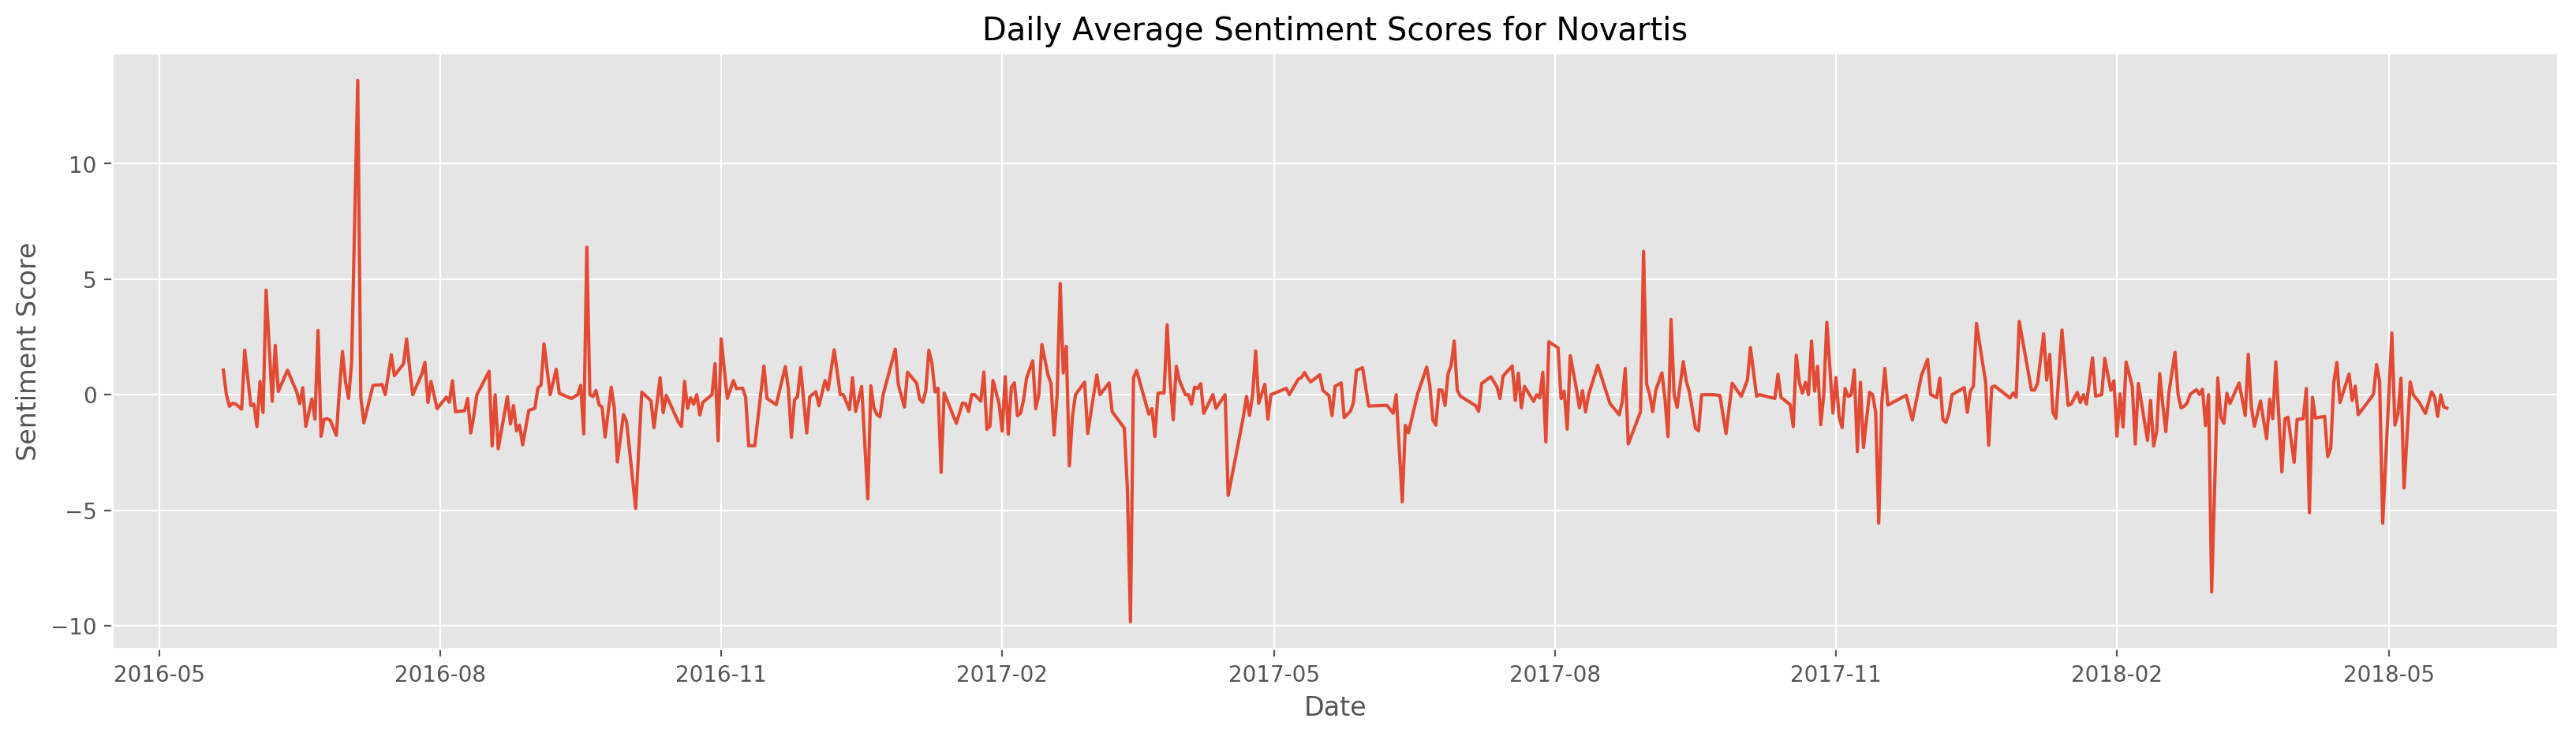

In [53]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Average Sentiment Scores for Novartis')
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['sentiment'])
plt.show()

In [54]:
Novartis_NZZ_other_df['10 Days Rolling'] = Novartis_NZZ_other_df['sentiment'].rolling(10).mean()
Novartis_NZZ_other_df['20 Days Rolling'] = Novartis_NZZ_other_df['sentiment'].rolling(20).mean()

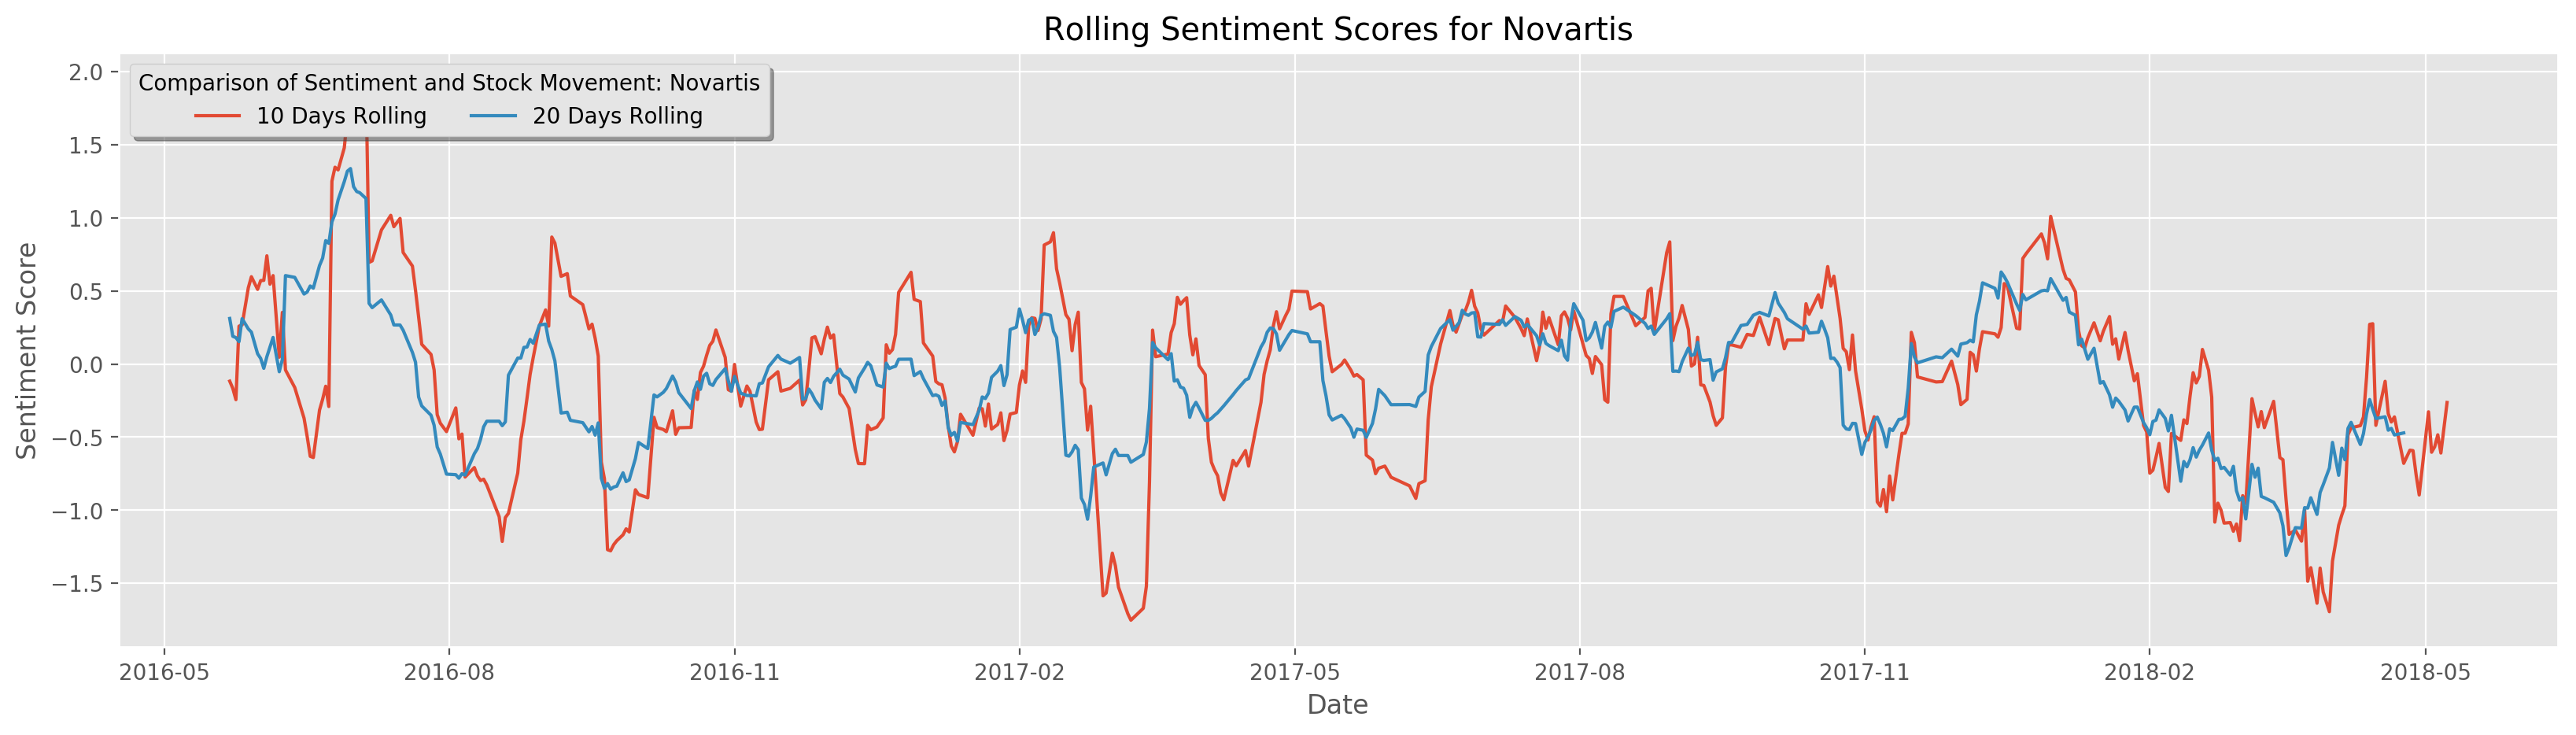

In [55]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Rolling Sentiment Scores for Novartis')
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['10 Days Rolling'])
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['20 Days Rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: Novartis', fancybox=True)
plt.plot()
plt.show()

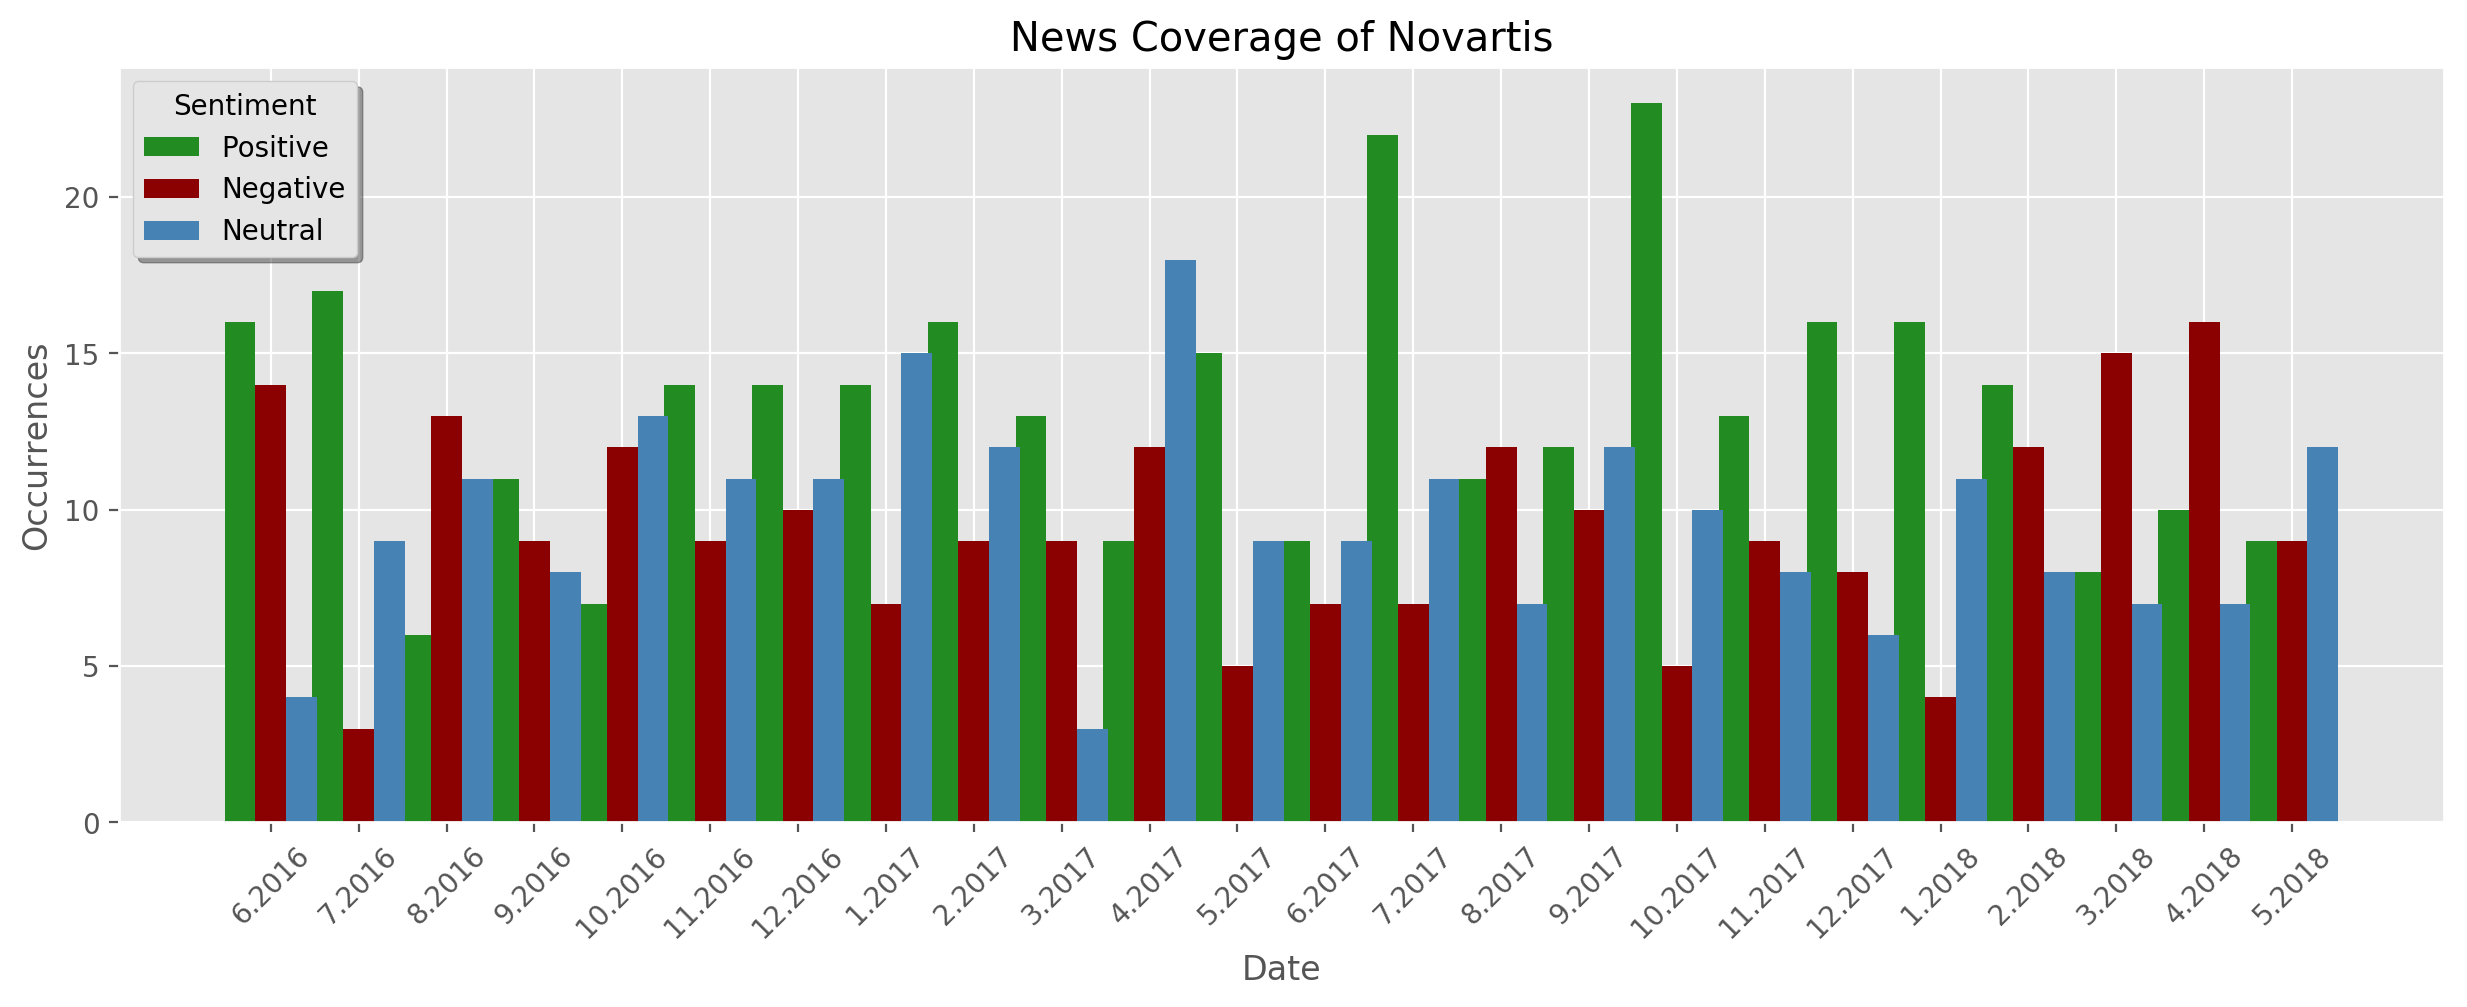

In [56]:
# Bar Chart summarising the sentiment of each month
import numpy as np
import matplotlib.pyplot as plt
years = [2016,2017,2018]
months = [x for x in range(1,13)]

fig, ax = plt.subplots(figsize=(15,5),dpi=200)

#ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
bar_df=pd.DataFrame()
bar_df['date'] = pd.to_datetime(Novartis_NZZ_df['date'],format='%d.%m.%Y')
bar_df['sentiment_value'] = Novartis_NZZ_df['sentiment_value']
bar_df['ones'] = 1
bar_df = bar_df.pivot_table(index='date',columns='sentiment_value',values='ones',aggfunc=sum)
#bar_df = pd.melt(bar_df,id_vars=['date'],value_vars=['sentiment_value'])
bar_df.fillna(0,inplace=True)
bar_df_2 =[]

for y in years:
    for m in months:
        temp = bar_df.loc[(bar_df.index.month == m) & (bar_df.index.year==y)]
        pos = np.sum(temp['pos'])
        neg = np.sum(temp['neg'])
        neutral = np.sum(temp['neutral'])
        bar_df_2.append([str(m)+'.'+str(y),pos,neg,neutral])
from matplotlib.dates import date2num

bar_df_2 = pd.DataFrame(bar_df_2,columns=['date','pos','neg','neutral'])
bar_df_2.drop([0,1,2,3,4,29,30,31,32,33,34,35], inplace = True, axis = 0)

plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.title('News Coverage of Novartis')
p1 = ax.bar(bar_df_2.index-0.35, bar_df_2['pos'], width, color='forestgreen', align='center', label = 'Positive')
p2 = ax.bar(bar_df_2.index, bar_df_2['neg'], width, color='darkred', align='center', label = 'Negative')
p3 = ax.bar(bar_df_2.index+0.35, bar_df_2['neutral'], width, color='steelblue', align='center', label = 'Neutral')
ax.set_xticks(bar_df_2.index)
ax.set_xticklabels(bar_df_2['date'])
plt.xticks(rotation=45)

plt.legend(loc="upper left", shadow = True, handles=[p1, p2, p3], title = 'Sentiment', fancybox = True)
plt.savefig('Novartis_BarChart.eps', format='eps', dpi=1000)
plt.show()

## Analysis of Roche

In [57]:
a_list = []
for n in range(1,18):    
    sauce = open('Roche_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [58]:
Roche_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Roche_NZZ_df.head()

date                                               text
0  20.05.2018  Arztvisite in Kolumbien: Auch hier hat sich di...
1  20.05.2018  Novartis und Roche haben gemäss Register 2005 ...
2  20.05.2018  Hat bei Sterbenskranken jede andere Therapie v...
3  19.05.2018                AstraZeneca unter Druck der Anleger
4  19.05.2018  (awp) · Der Schweizer Aktienmarkt hat am Freit...

## Sentiment Analysis with Weighted SentiWS Dictionary

In [59]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [60]:
# Apply tokenizer to UBS
Roche_NZZ_df['tokens'] = Roche_NZZ_df['text'].apply(tokenize)

In [61]:
def get_words(name):
    df = pd.read_table(name,header=None,names=['word','weight','words'])
    words_1 = ''
    weights = []
    for i, row in df.iterrows():

        col1 = row['word']
        weight = row['weight']
        col2 = row['words']
        w=''
        for c in col1:
            if c == '|':
                w+='\n'
                break
            w += c
        words_1 += w

        w = ''
        count = 0
        if pd.notnull(col2):
            for c in col2:
                if c == ',':
                    words_1 += w+'\n'
                    w=''
                    count += 1
                    c=''
                w+=c
            words_1 += w +'\n'
            count+=1
        weight = row['weight']
        weights.append(weight)
        for w in range(count):
            weights.append(weight)
        
    return words_1,weights

pos_words,pos_weights = get_words('SentiWS_v1.8c_Positive.txt')
neg_words,neg_weights = get_words('SentiWS_v1.8c_Negative.txt')

In [62]:
# Text mine function for Roche
def text_mine_articles(Roche_NZZ_df, bag_of_words,weights,alignment):
    
    bag_of_words = tokenize(bag_of_words)


    Roche_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    count=0
    for j in range(0, len(Roche_NZZ_df)):
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Roche_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        amount = 0
        count_2 = 0
        for word in occurrences:
            
            index = bag_of_words.index(word)
            weight = weights[index]

            amount += weight
            count_2+=1
        # Copy amount of occurrences found to the dataframe
        #amount = len(occurrences)
        Roche_NZZ_df.at[j,'num_occurr_'+alignment] = amount*10000
        count+=1   
   
    print('Done!')
 
    return Roche_NZZ_df

In [63]:
Roche_NZZ_df = text_mine_articles(Roche_NZZ_df, pos_words,pos_weights,'pos')
Roche_NZZ_df['num_occurr_pos'] = Roche_NZZ_df['num_occurr_pos']/ 10000
Roche_NZZ_df = text_mine_articles(Roche_NZZ_df, neg_words, neg_weights,'neg')
Roche_NZZ_df['num_occurr_neg'] = Roche_NZZ_df['num_occurr_neg']/ 10000

Text mine articles...
Done!
Text mine articles...
Done!


In [64]:
# Threshold Function
def binarize(sentiment_value):#, word_count, word_diversity):
    if sentiment_value > 0:
        return 'pos'
    elif sentiment_value < -0.5:
        return 'neg'
    else:
        return 'neutral'

In [65]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Roche_NZZ_df['sentiment_score'] = Roche_NZZ_df['num_occurr_pos'] + Roche_NZZ_df['num_occurr_neg']
Roche_NZZ_df['sentiment_value'] = Roche_NZZ_df['sentiment_score'].apply(binarize)

In [66]:
# Create .dt.date format
Roche_NZZ_df['datetime'] = pd.to_datetime(Roche_NZZ_df['date'],format='%d.%m.%Y')
Roche_NZZ_df.at[0,'datetime']
Roche_NZZ_df.groupby('sentiment_value').count()

date  text  tokens  num_occurr_pos  num_occurr_neg  \
sentiment_value                                                       
neg               208   208     208             208             208   
neutral           242   242     242             242             242   
pos               346   346     346             346             346   

                 sentiment_score  datetime  
sentiment_value                             
neg                          208       208  
neutral                      242       242  
pos                          346       346

In [67]:
# Normalized Sentiment
Roche_NZZ_df['Pos_Normal'] = (Roche_NZZ_df['num_occurr_pos'] - np.mean(Roche_NZZ_df['num_occurr_pos'])/(np.std(Roche_NZZ_df['num_occurr_pos'])))

# Normalized Sentiment
Roche_NZZ_df['Neg_Normal'] = (Roche_NZZ_df['num_occurr_neg'] - np.mean(Roche_NZZ_df['num_occurr_neg'])/(np.std(Roche_NZZ_df['num_occurr_neg'])))

### Validation of Sentiment Scores

In [68]:
'''
Validation function
'''

# Color Selection
NEG = '\x1b[31m'
POS = '\x1b[32m'
END = '\x1b[0m'

def colorize_neg(text):
    return NEG + text + END

def colorize_pos(text):
    return POS + text + END

i = 0
for neg, pos, t in zip(Roche_NZZ_df['num_occurr_neg'].values, Roche_NZZ_df['num_occurr_pos'].values, Roche_NZZ_df['text'].values):
    print("\n" + "-" * 100)
    print("--- Prediction: {}".format(pos + neg))
    print("-" * 100)
    
    text = t
    for posword in pos_words.splitlines():
        text = re.sub(r'\b{}\b'.format(posword), colorize_pos(posword), text)
    for negword in neg_words.splitlines():
        text = re.sub(r'\b{}\b'.format(negword), colorize_neg(negword), text)
    
    print(text)
    if i == 10:
        break
    i += 1


----------------------------------------------------------------------------------------------------
--- Prediction: 0.0
----------------------------------------------------------------------------------------------------
Arztvisite in Kolumbien: Auch hier hat sich die Anzahl ­klinischer Versuche, die Novartis und Roche durchführen, in den letzten ­Jahren ­vervielfacht.

----------------------------------------------------------------------------------------------------
--- Prediction: 0.004
----------------------------------------------------------------------------------------------------
Novartis und Roche haben gemäss Register 2005 erst 12 Studien in Brasilien durchgeführt. Im Jahr 2013 waren
es bereits 65.

----------------------------------------------------------------------------------------------------
--- Prediction: -0.8205
----------------------------------------------------------------------------------------------------
Hat bei Sterbenskranken jede andere Therapie versag

AstraZeneca unter Druck der Anleger

----------------------------------------------------------------------------------------------------
--- Prediction: -1.079
----------------------------------------------------------------------------------------------------
(awp) · Der Schweizer Aktienmarkt hat am Freitag vor dem Pfingstwochenende klar unter dem Niveau des Vortages geschlossen. Lange Zeit bewegte sich der Swiss-Market-Index (SMI) leicht unter der Nulllinie, er weitete seine Verluste am Nachmittag aber noch etwas aus. Belastend wirkten sich auf die europäischen Märkte vor allem politische Unsicherheiten aus. So dürfte Italien zwar eine neue Regierung haben, doch mit den EU-Kritikern von Cinque Stelle und Lega nicht eine, die sich die Investoren gewünscht haben.

Der SMI schloss -0,53% tiefer bei 8940,46 Punkten. Im Wochenvergleich ergibt sich ein Minus von 0,58%. Grösster Verlierer unter den Blue Chips war die Richemont-Aktie, die um 5,3% absackte. Die Gruppe hatte zwar im Geschäfts

Wenn es harzt, dann harzt es. Eigentlich war die Meldung, die der Pharmariese Roche am Freitag veröffentlichte, wenig mehr als eine Randnotiz. Der Konzern hatte sich beim wichtigen Krebsmedikament Tecentriq Hoffnung gemacht, dass dieses in einer spezifischen Anwendungssituation Vorteile gegenüber Produkten der Konkurrenz hat. Doch eine Studie konnte keinen solchen Vorteil nachweisen.

Kaum ein Analyst hatte erwartet, dass die von Roche untersuchte Anwendung grosse Umsätze bringt. Für viele Beobachter fügt sich der Misserfolg aber in ein grösseres Bild ein. Der erfolgsverwöhnte Konzern hat seine dominante Stellung in der Krebsmedizin verloren. Zwar hat er erfolgversprechende Produkte in
der Pipeline. Neu entwickelte Medikamente des Konzerns treten aber gegen eine immer härtere Konkurrenz an.

Am Freitag kam dazu, dass das Analysehaus Bernstein Roche zurückstufte, und zwar von «outperform» auf «market perform». Der Genussschein gab darauf 1,7% ab und belastete damit den Schweizer Aktienm

In [69]:
# Creates a function that computes the mean value for each day 
unique_dates = Roche_NZZ_df['date'].unique()

Roche_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Roche_NZZ_df.loc[Roche_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Roche_NZZ_other_df = Roche_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [70]:
Roche_NZZ_other_df['date']=pd.to_datetime(Roche_NZZ_other_df['date'],format='%d.%m.%Y')
Roche_NZZ_other_df.sort_values(by='date').head()

date  sentiment
496 2016-05-23     0.0000
495 2016-05-24    -1.0045
494 2016-05-25    -0.3631
493 2016-05-26    -0.4043
492 2016-05-28    -0.6254

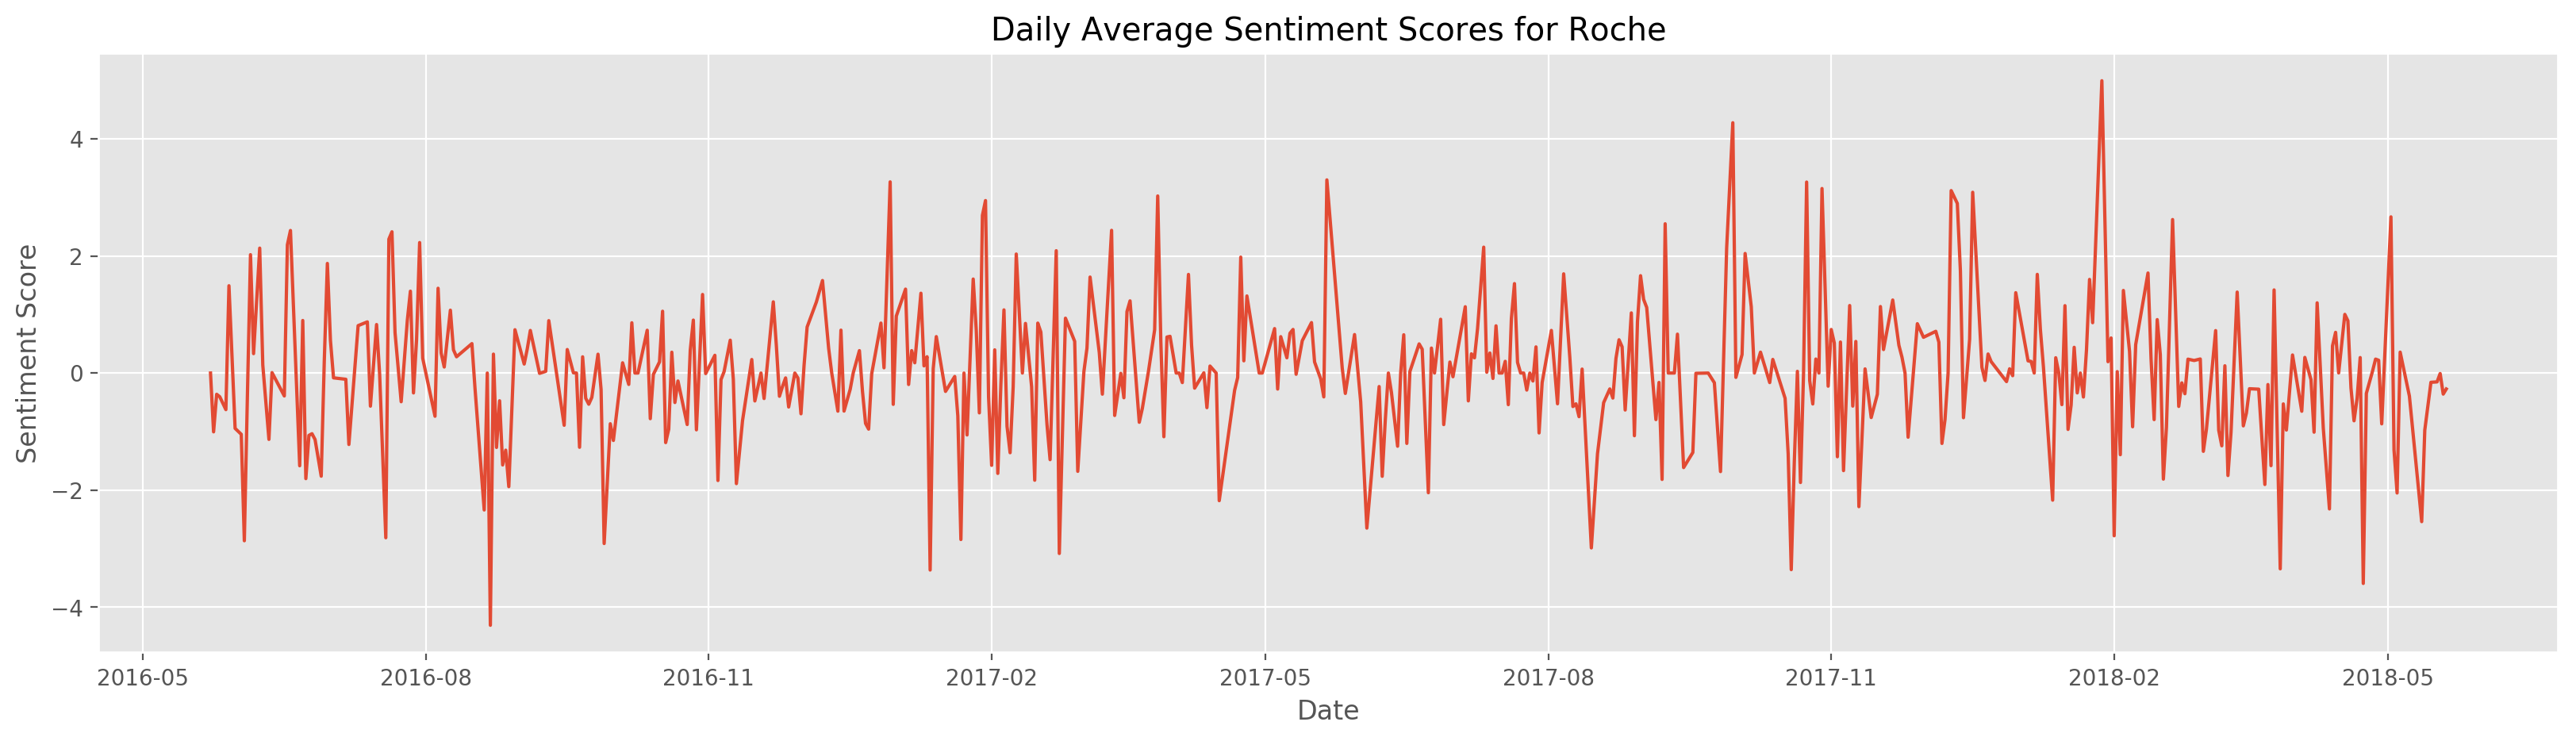

In [71]:
# Plot daily average scores
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Average Sentiment Scores for Roche')
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['sentiment'])
plt.show()

In [72]:
Roche_NZZ_other_df['10 Days Rolling'] = Roche_NZZ_other_df['sentiment'].rolling(10).mean()
Roche_NZZ_other_df['20 Days Rolling'] = Roche_NZZ_other_df['sentiment'].rolling(20).mean()

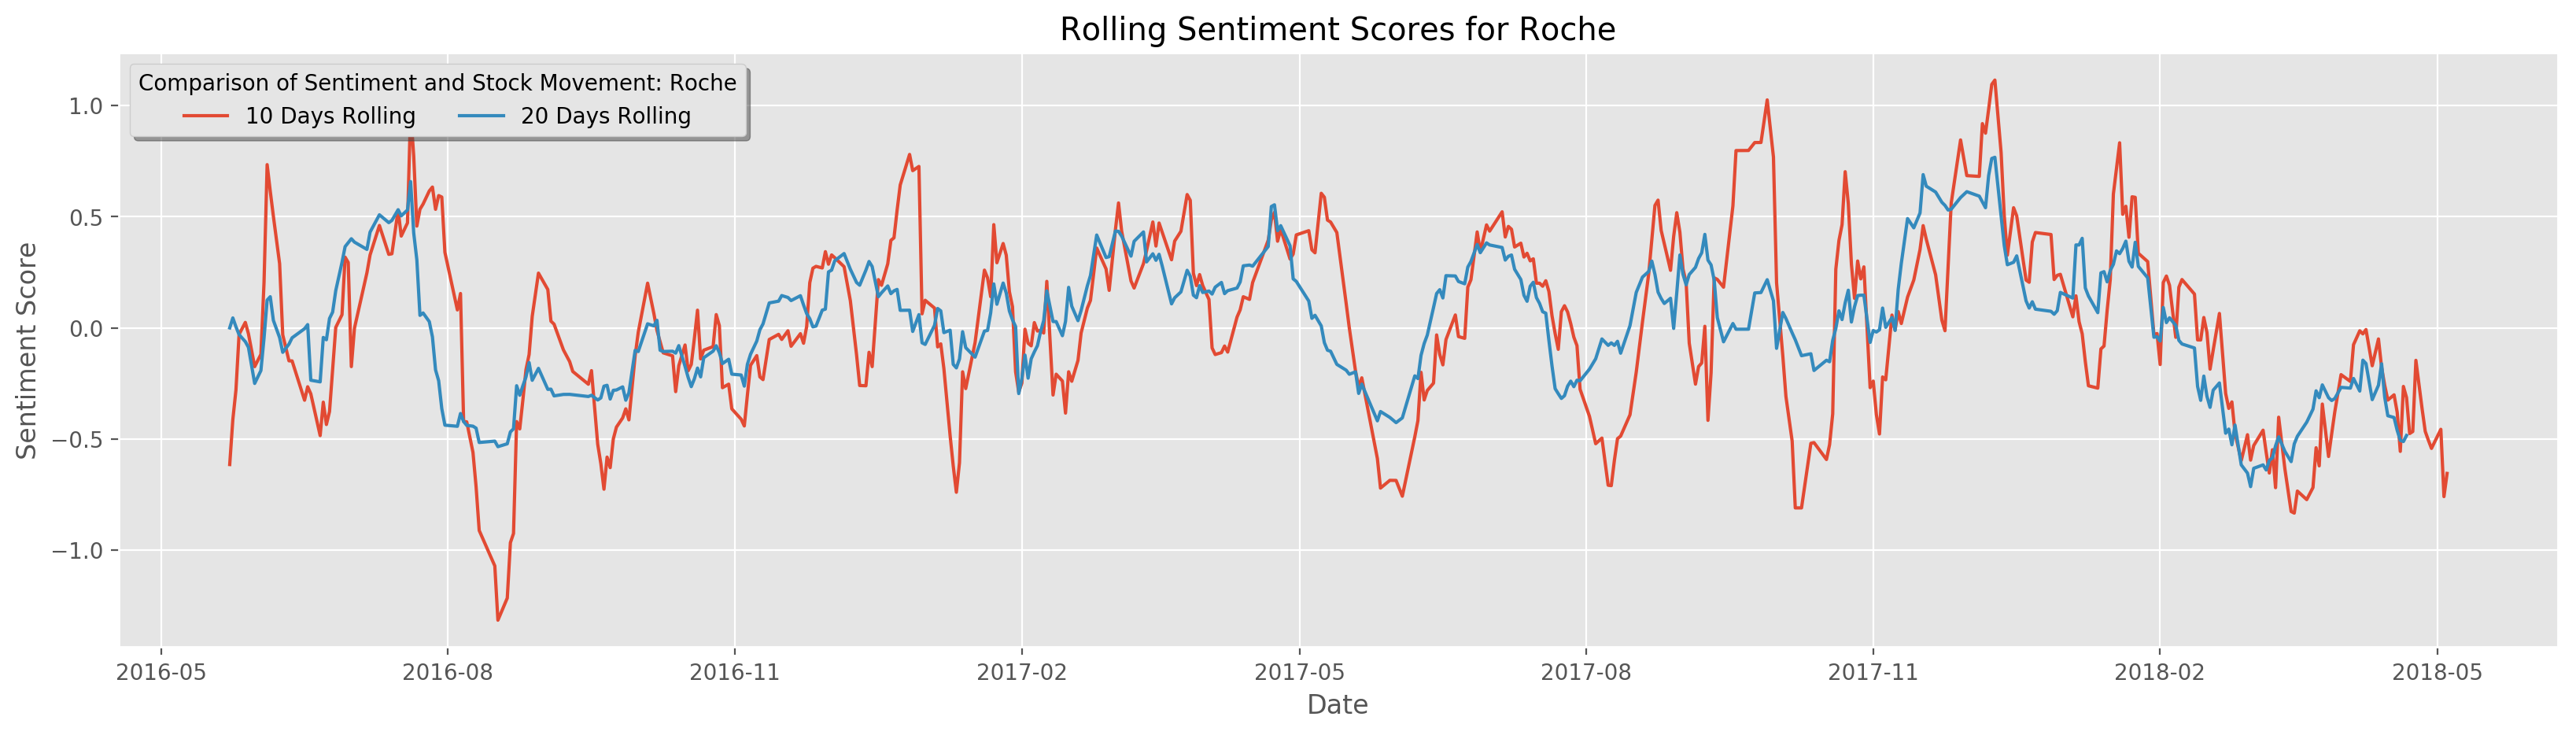

In [73]:
# Plot rolling mean
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Rolling Sentiment Scores for Roche')
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['10 Days Rolling'])
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['20 Days Rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: Roche', fancybox=True)
plt.plot()
plt.show()

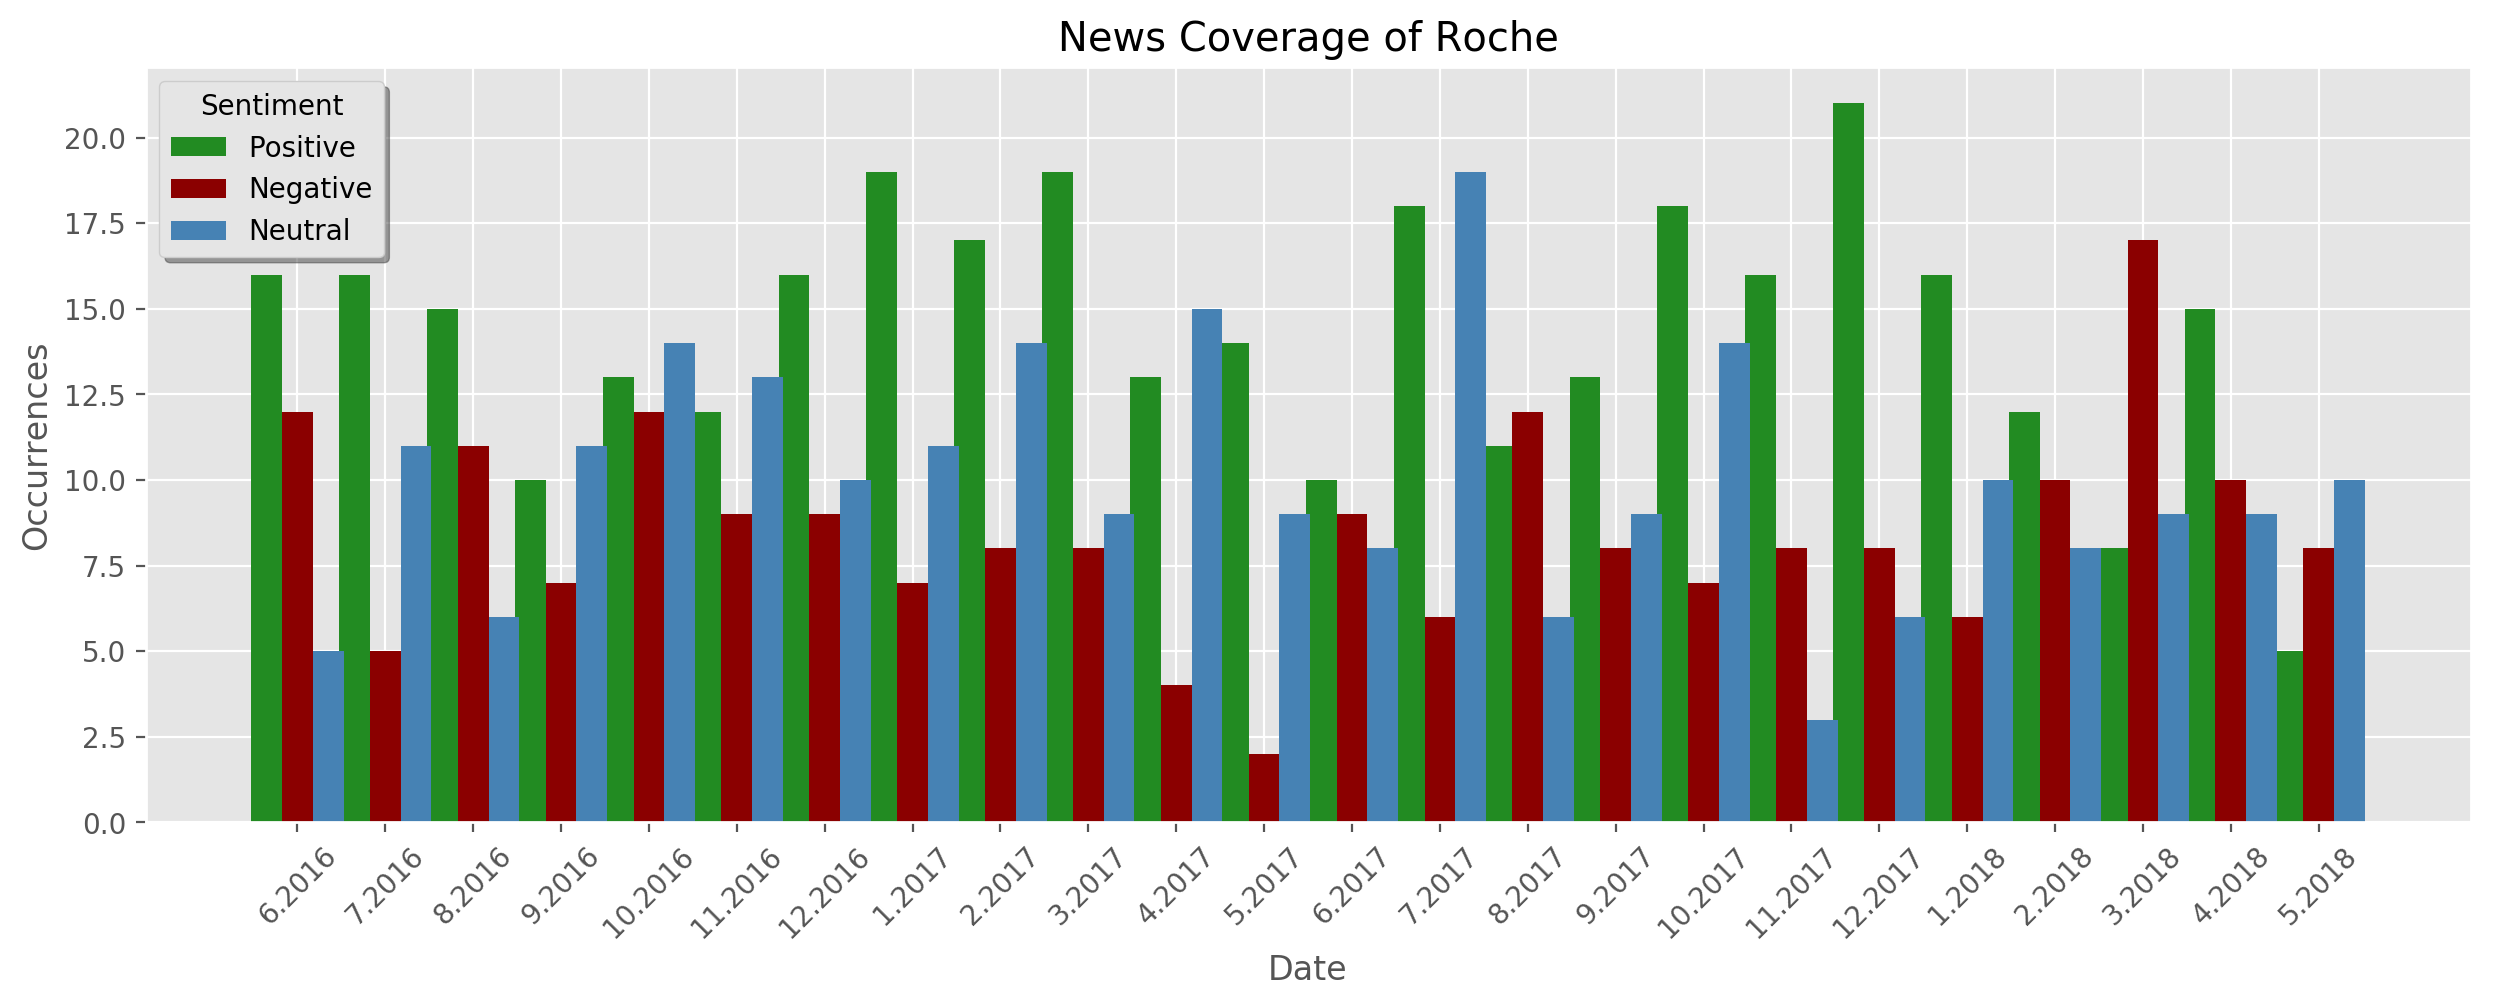

In [74]:
# Bar Chart summarising the sentiment of each month
import numpy as np
import matplotlib.pyplot as plt
years = [2016,2017,2018]
months = [x for x in range(1,13)]

fig, ax = plt.subplots(figsize=(15,5),dpi=200)

#ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
bar_df=pd.DataFrame()
bar_df['date'] = pd.to_datetime(Roche_NZZ_df['date'],format='%d.%m.%Y')
bar_df['sentiment_value'] = Roche_NZZ_df['sentiment_value']
bar_df['ones'] = 1
bar_df = bar_df.pivot_table(index='date',columns='sentiment_value',values='ones',aggfunc=sum)
#bar_df = pd.melt(bar_df,id_vars=['date'],value_vars=['sentiment_value'])
bar_df.fillna(0,inplace=True)
bar_df_2 =[]

for y in years:
    for m in months:
        temp = bar_df.loc[(bar_df.index.month == m) & (bar_df.index.year==y)]
        pos = np.sum(temp['pos'])
        neg = np.sum(temp['neg'])
        neutral = np.sum(temp['neutral'])
        bar_df_2.append([str(m)+'.'+str(y),pos,neg,neutral])
from matplotlib.dates import date2num

bar_df_2 = pd.DataFrame(bar_df_2,columns=['date','pos','neg','neutral'])
bar_df_2.drop([0,1,2,3,4,29,30,31,32,33,34,35], inplace = True, axis = 0)

plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.title('News Coverage of Roche')
p1 = ax.bar(bar_df_2.index-0.35, bar_df_2['pos'], width, color='forestgreen', align='center', label = 'Positive')
p2 = ax.bar(bar_df_2.index, bar_df_2['neg'], width, color='darkred', align='center', label = 'Negative')
p3 = ax.bar(bar_df_2.index+0.35, bar_df_2['neutral'], width, color='steelblue', align='center', label = 'Neutral')
ax.set_xticks(bar_df_2.index)
ax.set_xticklabels(bar_df_2['date'])
plt.xticks(rotation=45)

plt.legend(loc="upper left", shadow = True, handles=[p1, p2, p3], title = 'Sentiment', fancybox = True)
plt.savefig('Roche_BarChart.eps', format='eps', dpi=1000)
plt.show()

## Sentiment Index vs. Stock Prices

### UBS Stock Data

In [75]:
UBS_quandl_df = quandl.get("SIX/CH0244767585CHF",start_date="2016-05-28", end_date="2018-05-22")
UBS_quandl_df.head()

Price      Volume
Date                         
2016-05-30  15.28   5188514.0
2016-05-31  15.36  19104255.0
2016-06-01  15.11  12734139.0
2016-06-02  14.91  13914562.0
2016-06-03  14.41  17260664.0

In [76]:
UBS_quandl_df['Price_rolling'] = UBS_quandl_df['Price'].rolling(10).mean()

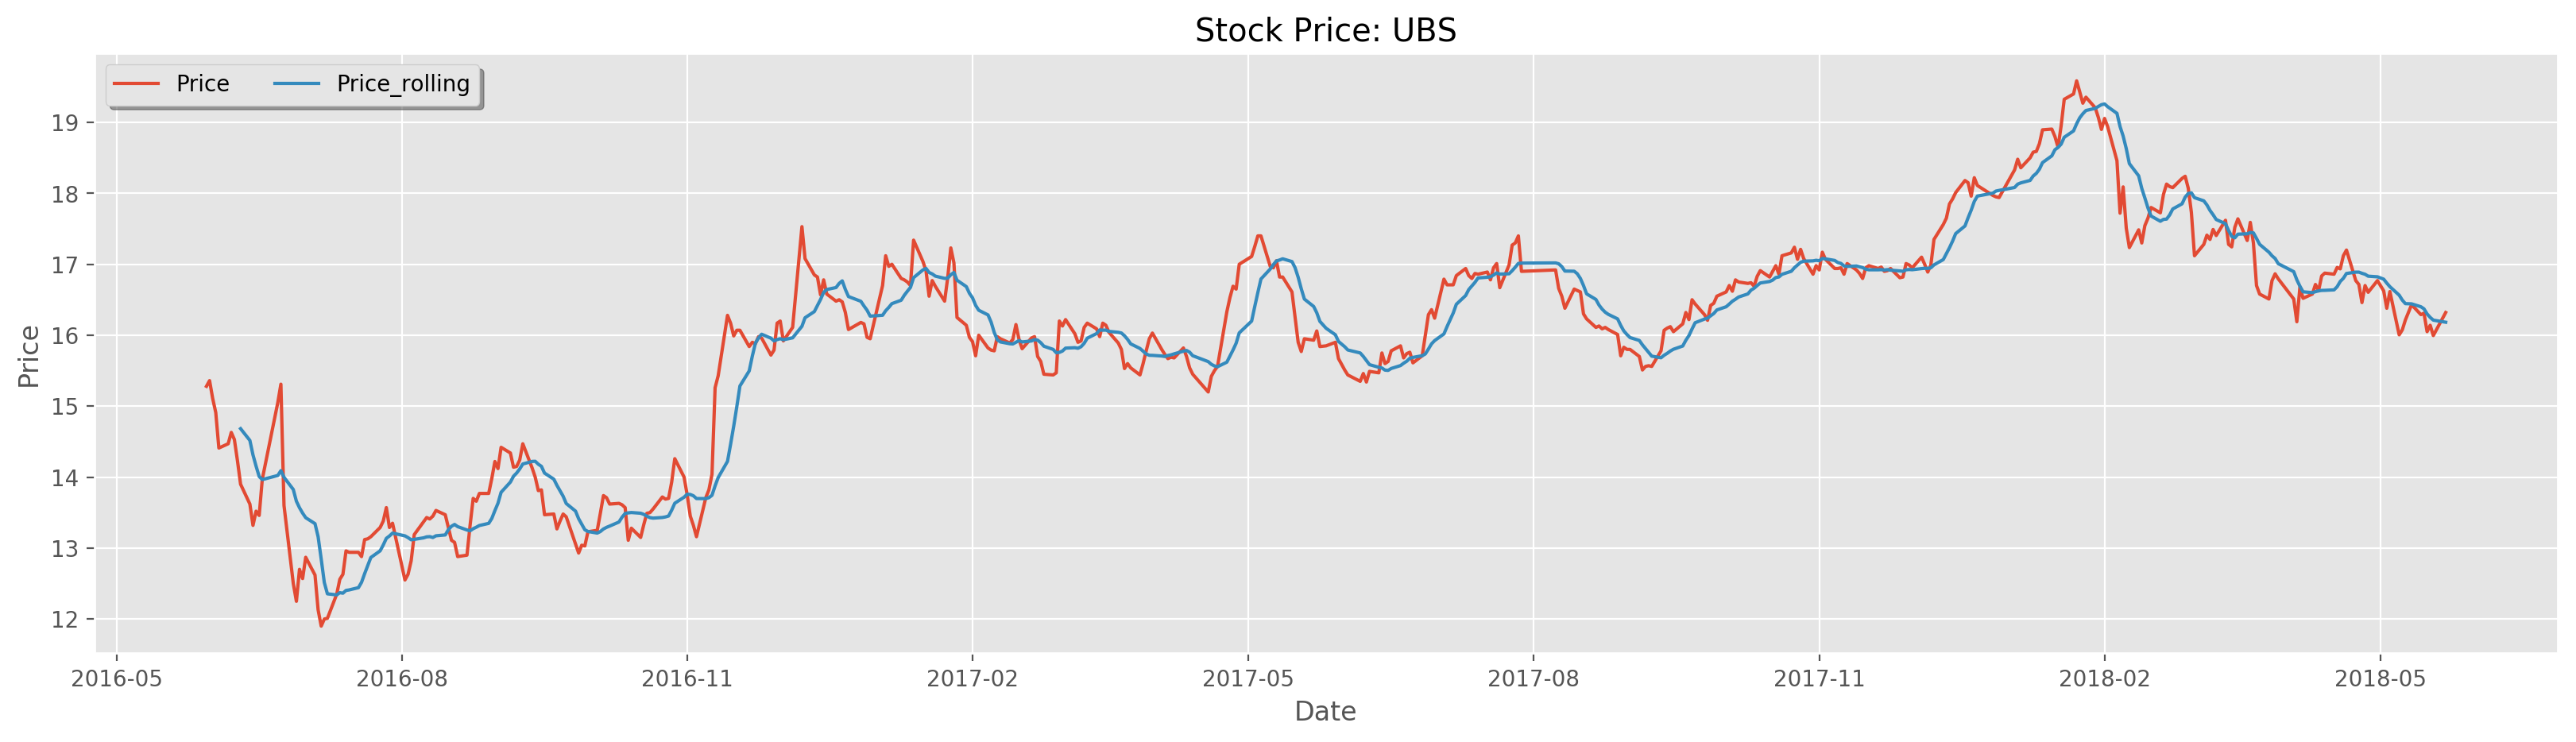

In [77]:
# Plot for UBS
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price: UBS')
plt.plot(UBS_quandl_df['Price'])
plt.plot(UBS_quandl_df['Price_rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='', fancybox=True)
plt.plot()
plt.show()

In [78]:
UBS_quandl_df['PriceNormal'] = (UBS_quandl_df['Price'] - UBS_quandl_df['Price'].mean()) / (UBS_quandl_df['Price'].max() - UBS_quandl_df['Price'].min())
UBS_quandl_df['VolumeNormal'] = (UBS_quandl_df['Volume'] - UBS_quandl_df['Volume'].mean()) / (UBS_quandl_df['Volume'].max() - UBS_quandl_df['Volume'].min())
UBS_quandl_df.head()

Price      Volume  Price_rolling  PriceNormal  VolumeNormal
Date                                                                   
2016-05-30  15.28   5188514.0            NaN    -0.086547     -0.150081
2016-05-31  15.36  19104255.0            NaN    -0.076137      0.120748
2016-06-01  15.11  12734139.0            NaN    -0.108668     -0.003228
2016-06-02  14.91  13914562.0            NaN    -0.134693      0.019746
2016-06-03  14.41  17260664.0            NaN    -0.199754      0.084868

In [79]:
UBS_NZZ_other_df.head()

date  sentiment  sentiment_norm  10 Days Rolling  20 Days Rolling
0 2018-05-16  -1.932500       -1.907474              NaN              NaN
1 2018-05-12  -4.175700       -4.150674              NaN              NaN
2 2018-05-04   0.892000        0.917026              NaN              NaN
3 2018-04-27   0.004000        0.029026              NaN              NaN
4 2018-04-26  -0.639733       -0.614707              NaN              NaN

In [80]:
UBS_NZZ_other_df['SentimentNormal'] = (UBS_NZZ_other_df['sentiment'] - UBS_NZZ_other_df['sentiment'].mean()) / (UBS_NZZ_other_df['sentiment'].max() - UBS_NZZ_other_df['sentiment'].min())
UBS_NZZ_other_df['Rolling Sentiment 5 Days'] = UBS_NZZ_other_df['SentimentNormal'].rolling(5).mean()
UBS_NZZ_other_df.loc[:,'Rolling Sentiment 5 Days'] *= 2
UBS_NZZ_other_df['Rolling Sentiment 10 Days'] = UBS_NZZ_other_df['SentimentNormal'].rolling(10).mean()
UBS_NZZ_other_df.loc[:,'Rolling Sentiment 10 Days'] *= 3
UBS_NZZ_other_df['Rolling Sentiment 20 Days'] = UBS_NZZ_other_df['SentimentNormal'].rolling(20).mean()
UBS_NZZ_other_df.loc[:,'Rolling Sentiment 20 Days'] *= 1

In [81]:
UBS_NZZ_other_df.head()

date  sentiment  sentiment_norm  10 Days Rolling  20 Days Rolling  \
0 2018-05-16  -1.932500       -1.907474              NaN              NaN   
1 2018-05-12  -4.175700       -4.150674              NaN              NaN   
2 2018-05-04   0.892000        0.917026              NaN              NaN   
3 2018-04-27   0.004000        0.029026              NaN              NaN   
4 2018-04-26  -0.639733       -0.614707              NaN              NaN   

   SentimentNormal  Rolling Sentiment 5 Days  Rolling Sentiment 10 Days  \
0        -0.091114                       NaN                        NaN   
1        -0.253341                       NaN                        NaN   
2         0.113153                       NaN                        NaN   
3         0.048933                       NaN                        NaN   
4         0.002378                 -0.071996                        NaN   

   Rolling Sentiment 20 Days  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

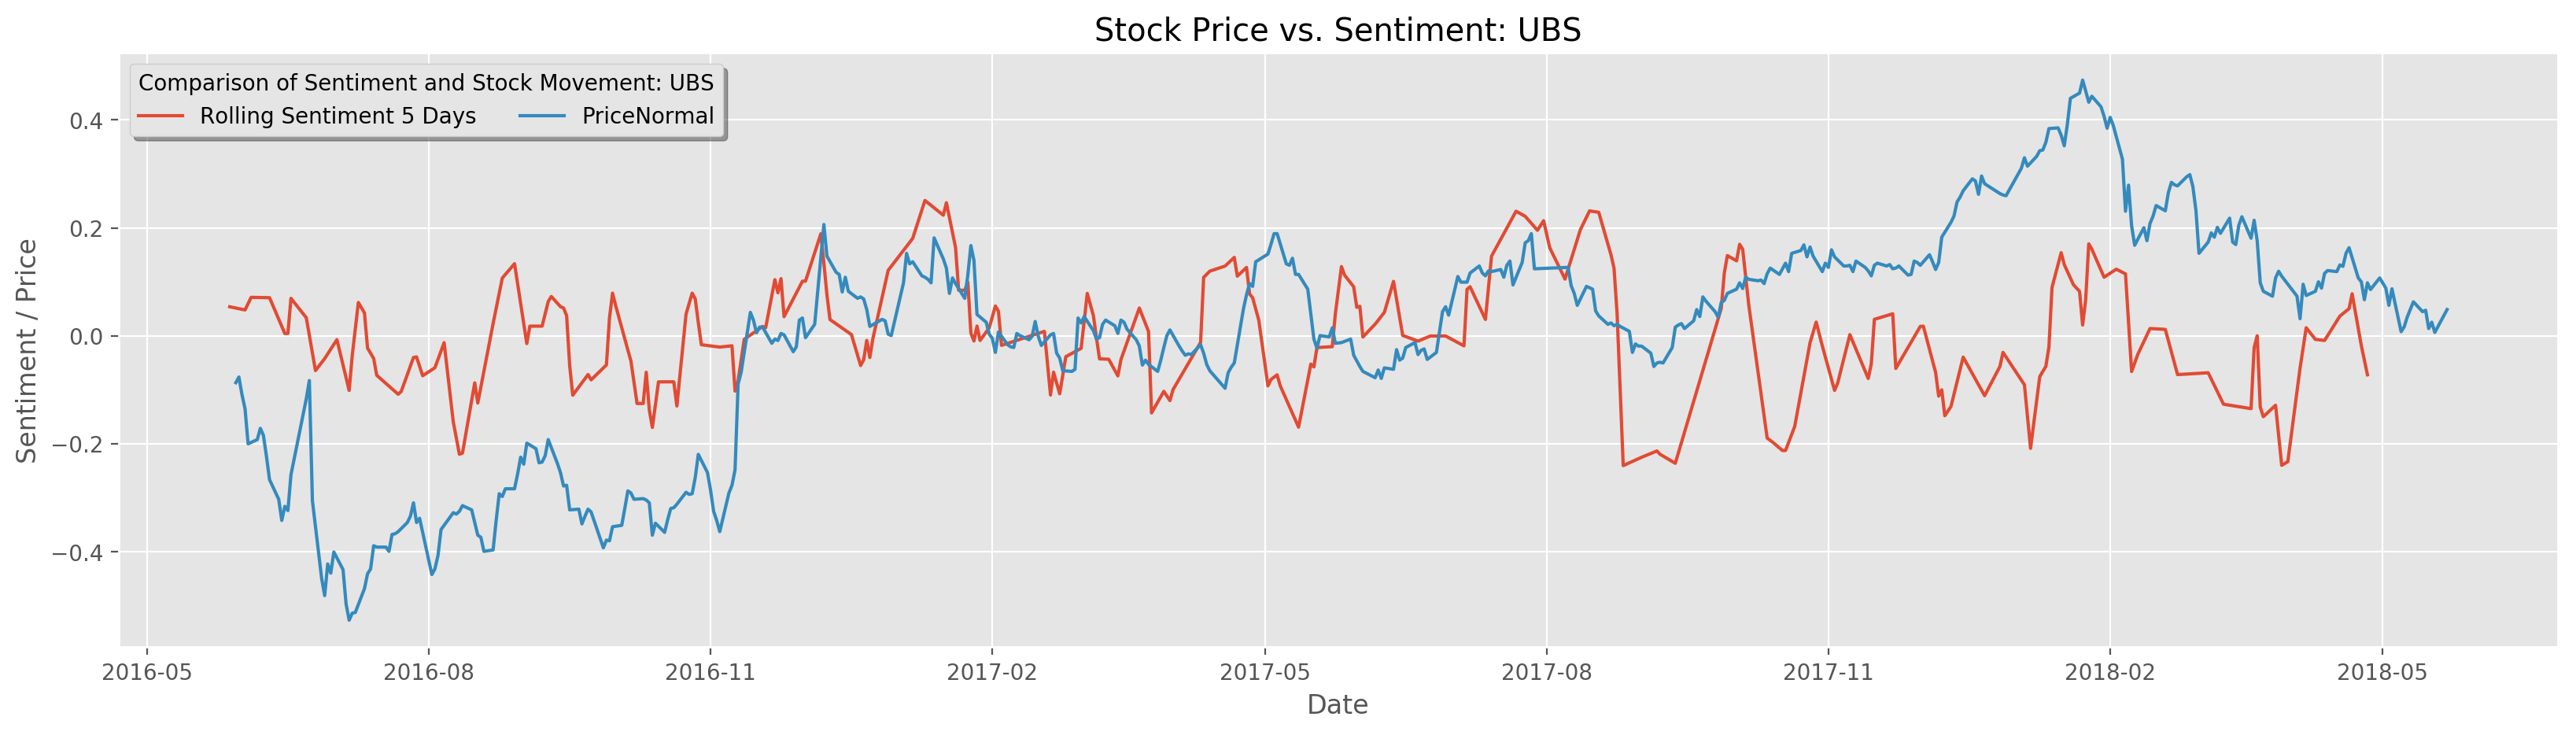

In [82]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: UBS')
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['Rolling Sentiment 5 Days'])
plt.plot(UBS_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: UBS', fancybox=True)
plt.savefig('UBS_SentimentStockShort.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

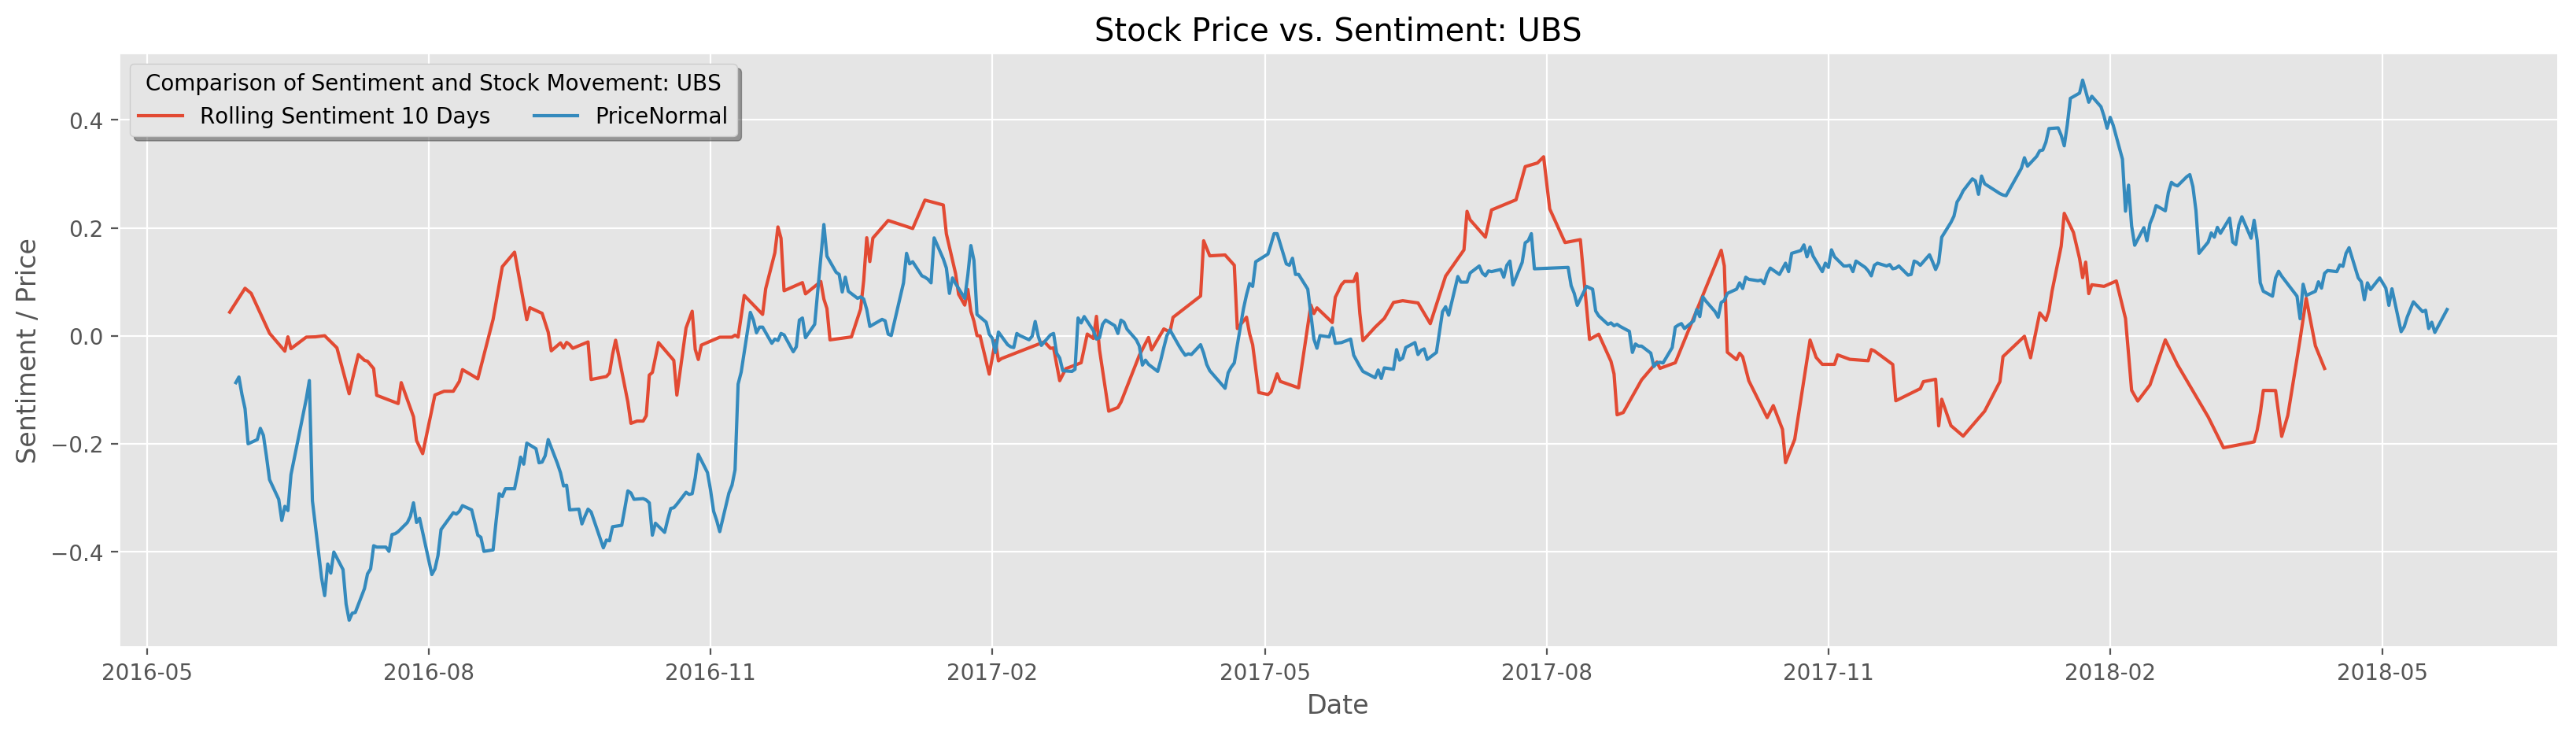

In [83]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: UBS')
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['Rolling Sentiment 10 Days'])
plt.plot(UBS_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: UBS', fancybox=True)
plt.savefig('UBS_SentimentStockMid.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

In [84]:
UBS_NZZ_other_df['Price'] = UBS_quandl_df['Price']
UBS_NZZ_other_df['PriceNormal'] = UBS_quandl_df['PriceNormal']
UBS_NZZ_other_df.head()

date  sentiment  sentiment_norm  10 Days Rolling  20 Days Rolling  \
0 2018-05-16  -1.932500       -1.907474              NaN              NaN   
1 2018-05-12  -4.175700       -4.150674              NaN              NaN   
2 2018-05-04   0.892000        0.917026              NaN              NaN   
3 2018-04-27   0.004000        0.029026              NaN              NaN   
4 2018-04-26  -0.639733       -0.614707              NaN              NaN   

   SentimentNormal  Rolling Sentiment 5 Days  Rolling Sentiment 10 Days  \
0        -0.091114                       NaN                        NaN   
1        -0.253341                       NaN                        NaN   
2         0.113153                       NaN                        NaN   
3         0.048933                       NaN                        NaN   
4         0.002378                 -0.071996                        NaN   

   Rolling Sentiment 20 Days  Price  PriceNormal  
0                        NaN    NaN          NaN  
1                        NaN    NaN          NaN  
2                        NaN    NaN          NaN  
3                        NaN    NaN          NaN  
4                        NaN    NaN          NaN

In [85]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('UBS_WeightedSentiment.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
UBS_NZZ_other_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [86]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('UBS_NZZ_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
UBS_NZZ_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Nestle Stock Data

In [87]:
Nestle_quandl_df = quandl.get("SIX/CH0038863350CHF",start_date="2016-05-28", end_date="2018-05-22")
Nestle_quandl_df.head()

Price     Volume
Date                        
2016-05-30  74.15  2284456.0
2016-05-31  73.40  7295400.0
2016-06-01  73.40  3911532.0
2016-06-02  73.45  4260958.0
2016-06-03  73.35  4491128.0

In [88]:
Nestle_quandl_df['Price_rolling'] = Nestle_quandl_df['Price'].rolling(10).mean()

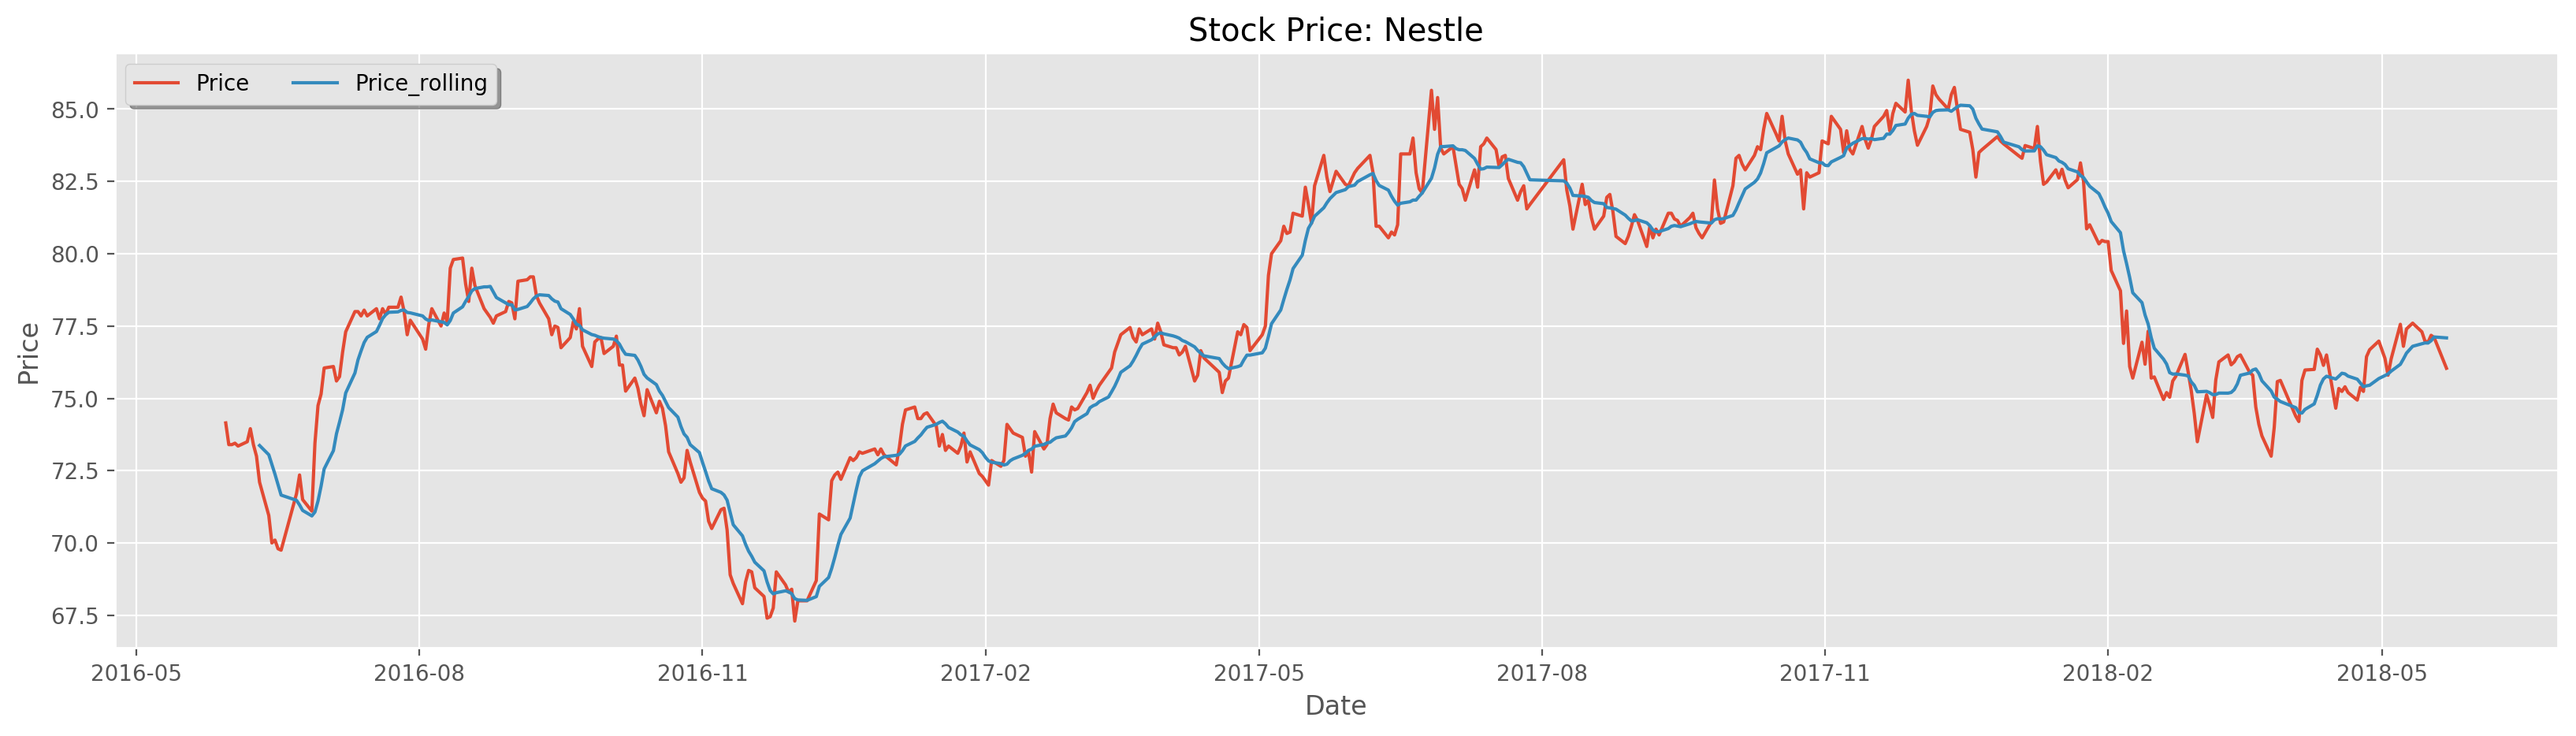

In [89]:
# Plot for Nestle
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price: Nestle')
plt.plot(Nestle_quandl_df['Price'])
plt.plot(Nestle_quandl_df['Price_rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='', fancybox=True)
plt.plot()
plt.show()

In [90]:
Nestle_quandl_df['PriceNormal'] = (Nestle_quandl_df['Price'] - Nestle_quandl_df['Price'].mean()) / (Nestle_quandl_df['Price'].max() - Nestle_quandl_df['Price'].min())
Nestle_quandl_df['VolumeNormal'] = (Nestle_quandl_df['Volume'] - Nestle_quandl_df['Volume'].mean()) / (Nestle_quandl_df['Volume'].max() - Nestle_quandl_df['Volume'].min())
Nestle_quandl_df.head()

Price     Volume  Price_rolling  PriceNormal  VolumeNormal
Date                                                                  
2016-05-30  74.15  2284456.0            NaN    -0.198735     -0.150267
2016-05-31  73.40  7295400.0            NaN    -0.238842      0.046331
2016-06-01  73.40  3911532.0            NaN    -0.238842     -0.086431
2016-06-02  73.45  4260958.0            NaN    -0.236168     -0.072722
2016-06-03  73.35  4491128.0            NaN    -0.241515     -0.063691

In [91]:
Nestle_NZZ_other_df['SentimentNormal'] = (Nestle_NZZ_other_df['sentiment'] - Nestle_NZZ_other_df['sentiment'].mean()) / (Nestle_NZZ_other_df['sentiment'].max() - Nestle_NZZ_other_df['sentiment'].min())
Nestle_NZZ_other_df['Rolling Sentiment 5 Days'] = Nestle_NZZ_other_df['SentimentNormal'].rolling(5).mean()
Nestle_NZZ_other_df.loc[:,'Rolling Sentiment 5 Days'] *= 2
Nestle_NZZ_other_df['Rolling Sentiment 10 Days'] = Nestle_NZZ_other_df['SentimentNormal'].rolling(10).mean()
Nestle_NZZ_other_df.loc[:,'Rolling Sentiment 10 Days'] *= 3
Nestle_NZZ_other_df['Rolling Sentiment 20 Days'] = Nestle_NZZ_other_df['SentimentNormal'].rolling(20).mean()
Nestle_NZZ_other_df.loc[:,'Rolling Sentiment 20 Days'] *= 1

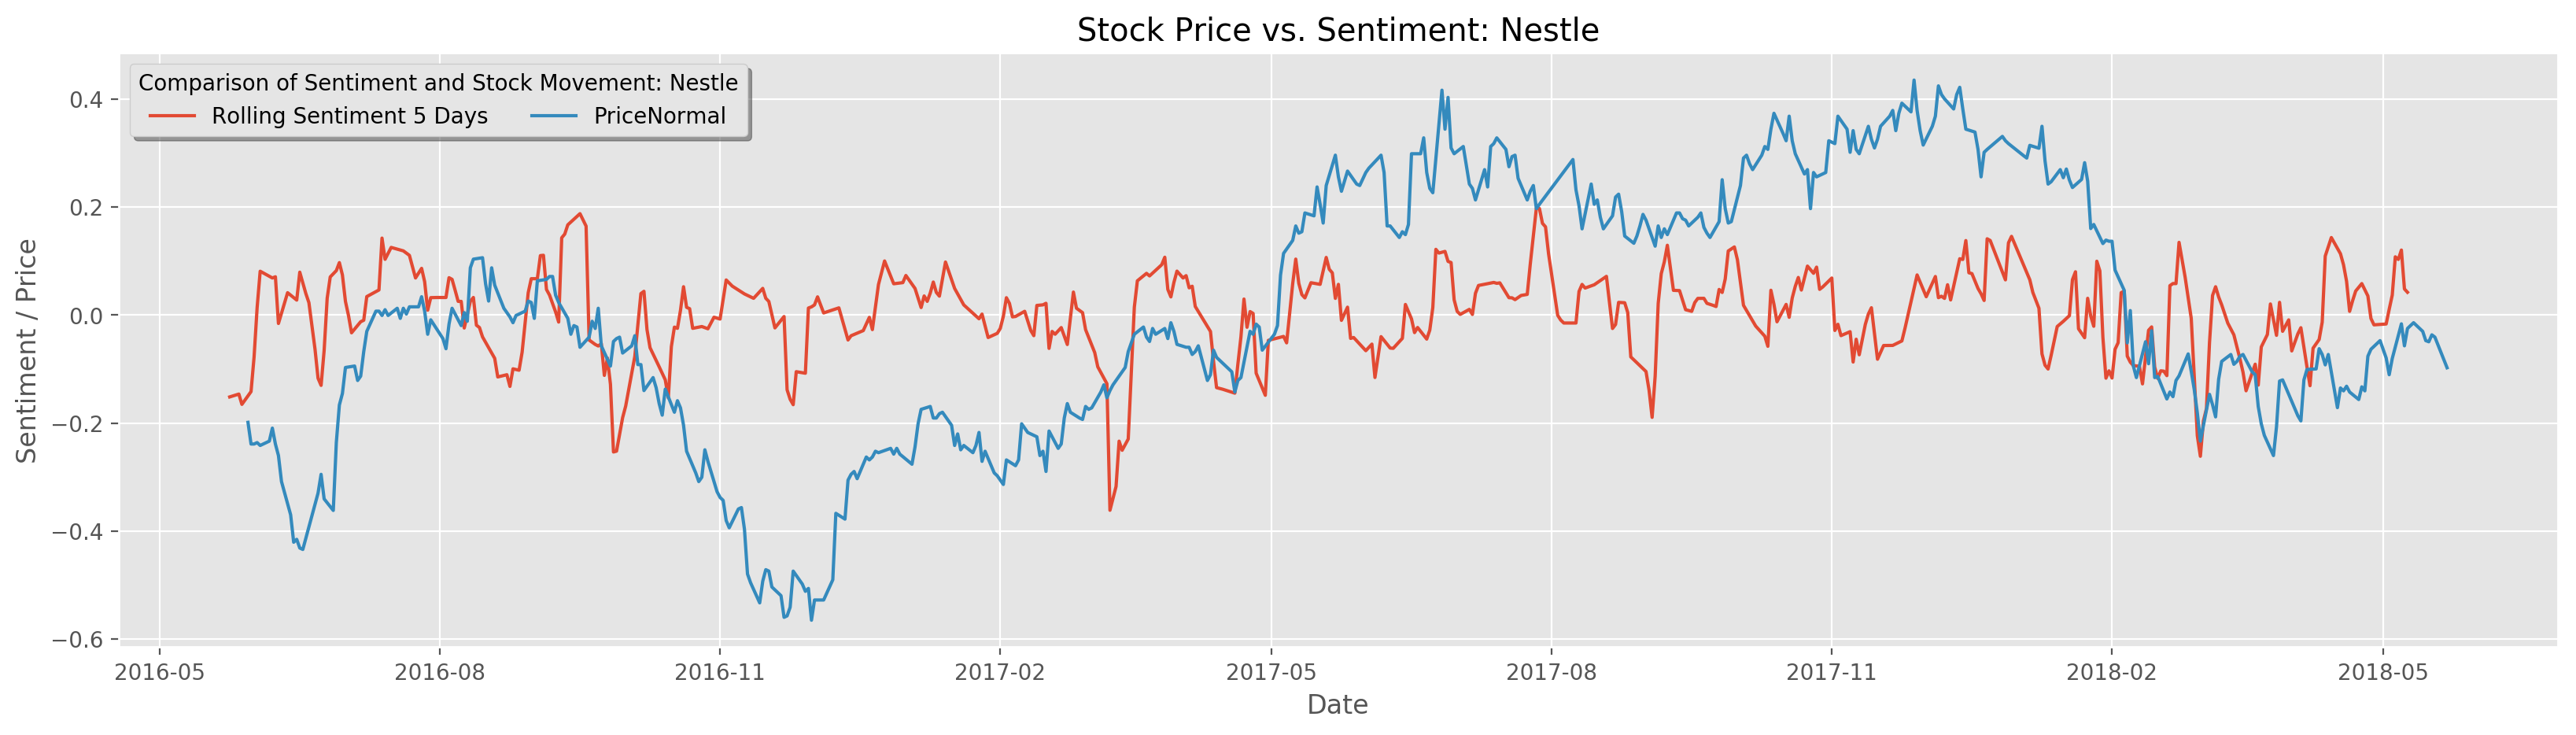

In [92]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Nestle')
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['Rolling Sentiment 5 Days'])
plt.plot(Nestle_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: Nestle', fancybox=True)
plt.savefig('Nestle_SentimentStockShort.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

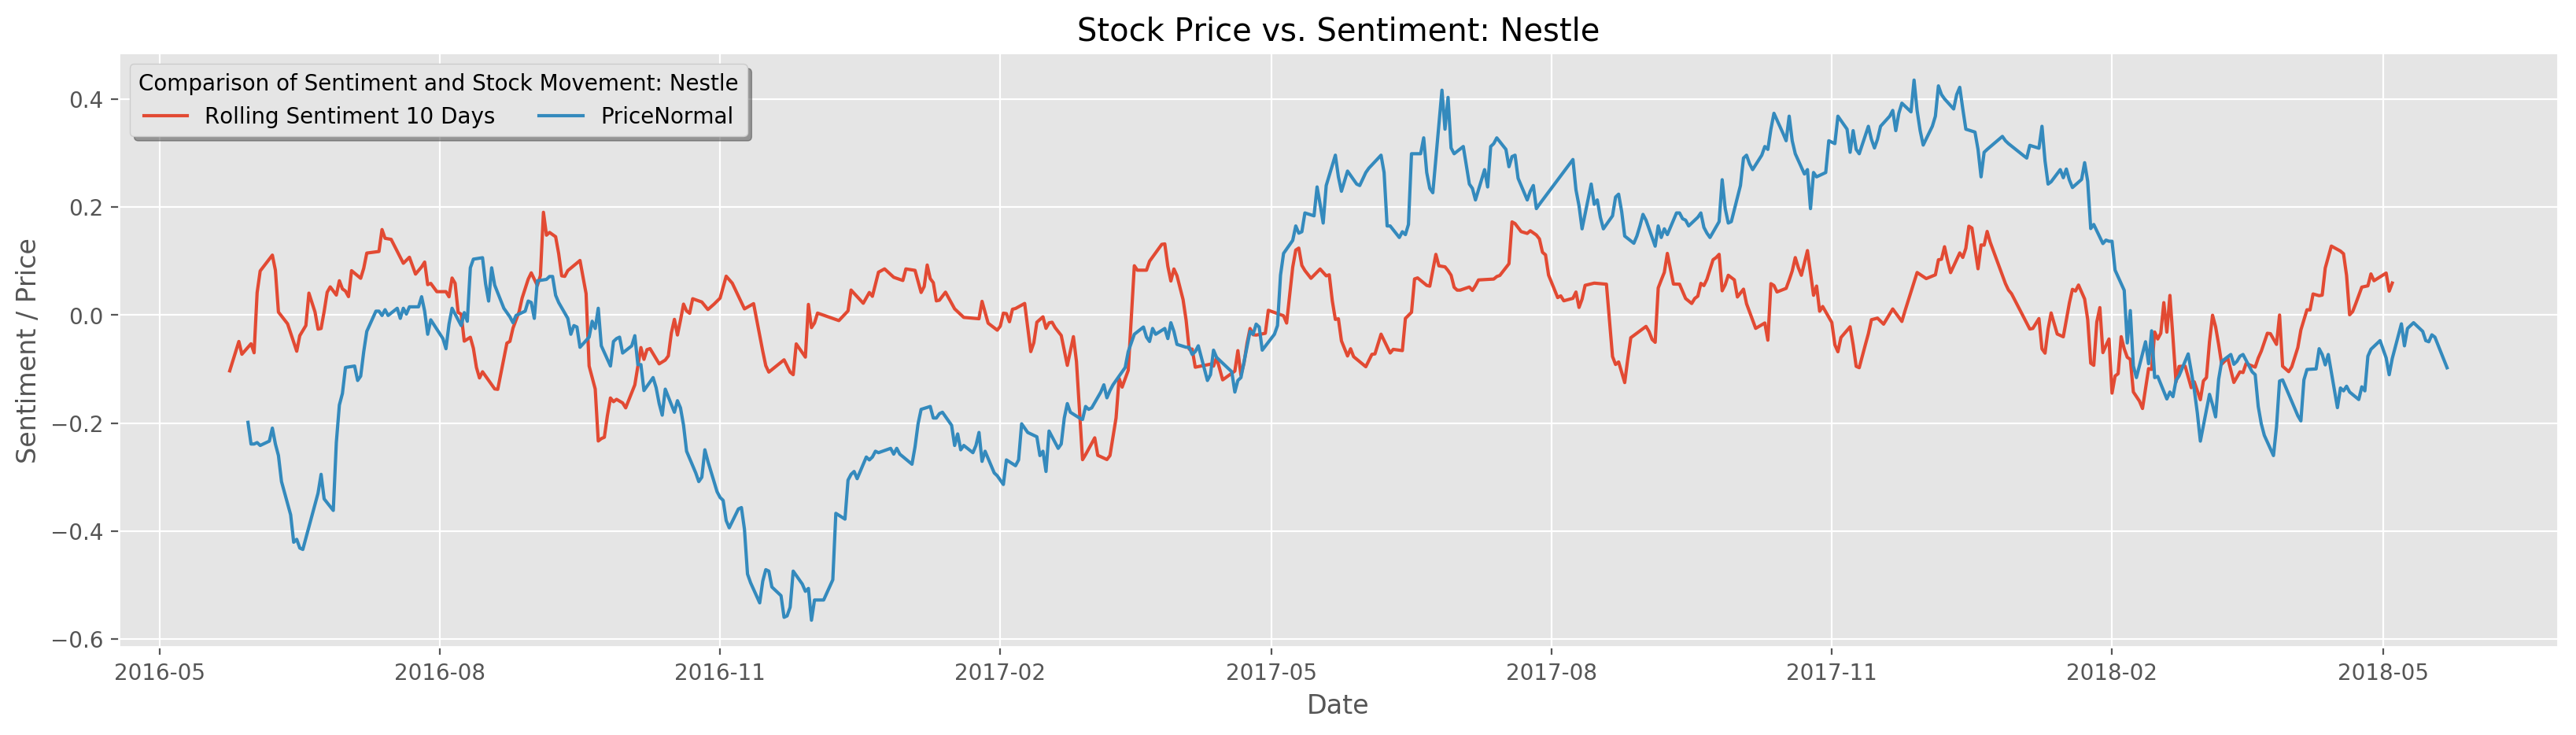

In [93]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Nestle')
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['Rolling Sentiment 10 Days'])
plt.plot(Nestle_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='Comparison of Sentiment and Stock Movement: Nestle', fancybox=True)
plt.savefig('Nestle_SentimentStockMid.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

In [94]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Nestle_WeightedSentiment.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Nestle_NZZ_other_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [95]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Nestle_NZZ_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Nestle_NZZ_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Novartis Stock Data

In [96]:
Novartis_quandl_df = quandl.get("SIX/CH0012005267CHF",start_date="2016-05-28", end_date="2018-05-22")
Novartis_quandl_df.head()

Price     Volume
Date                        
2016-05-30  79.55  2927407.0
2016-05-31  78.90  4950541.0
2016-06-01  78.70  3628933.0
2016-06-02  79.70  5664433.0
2016-06-03  79.00  4685411.0

In [97]:
Novartis_quandl_df['Price_rolling'] = Novartis_quandl_df['Price'].rolling(10).mean()

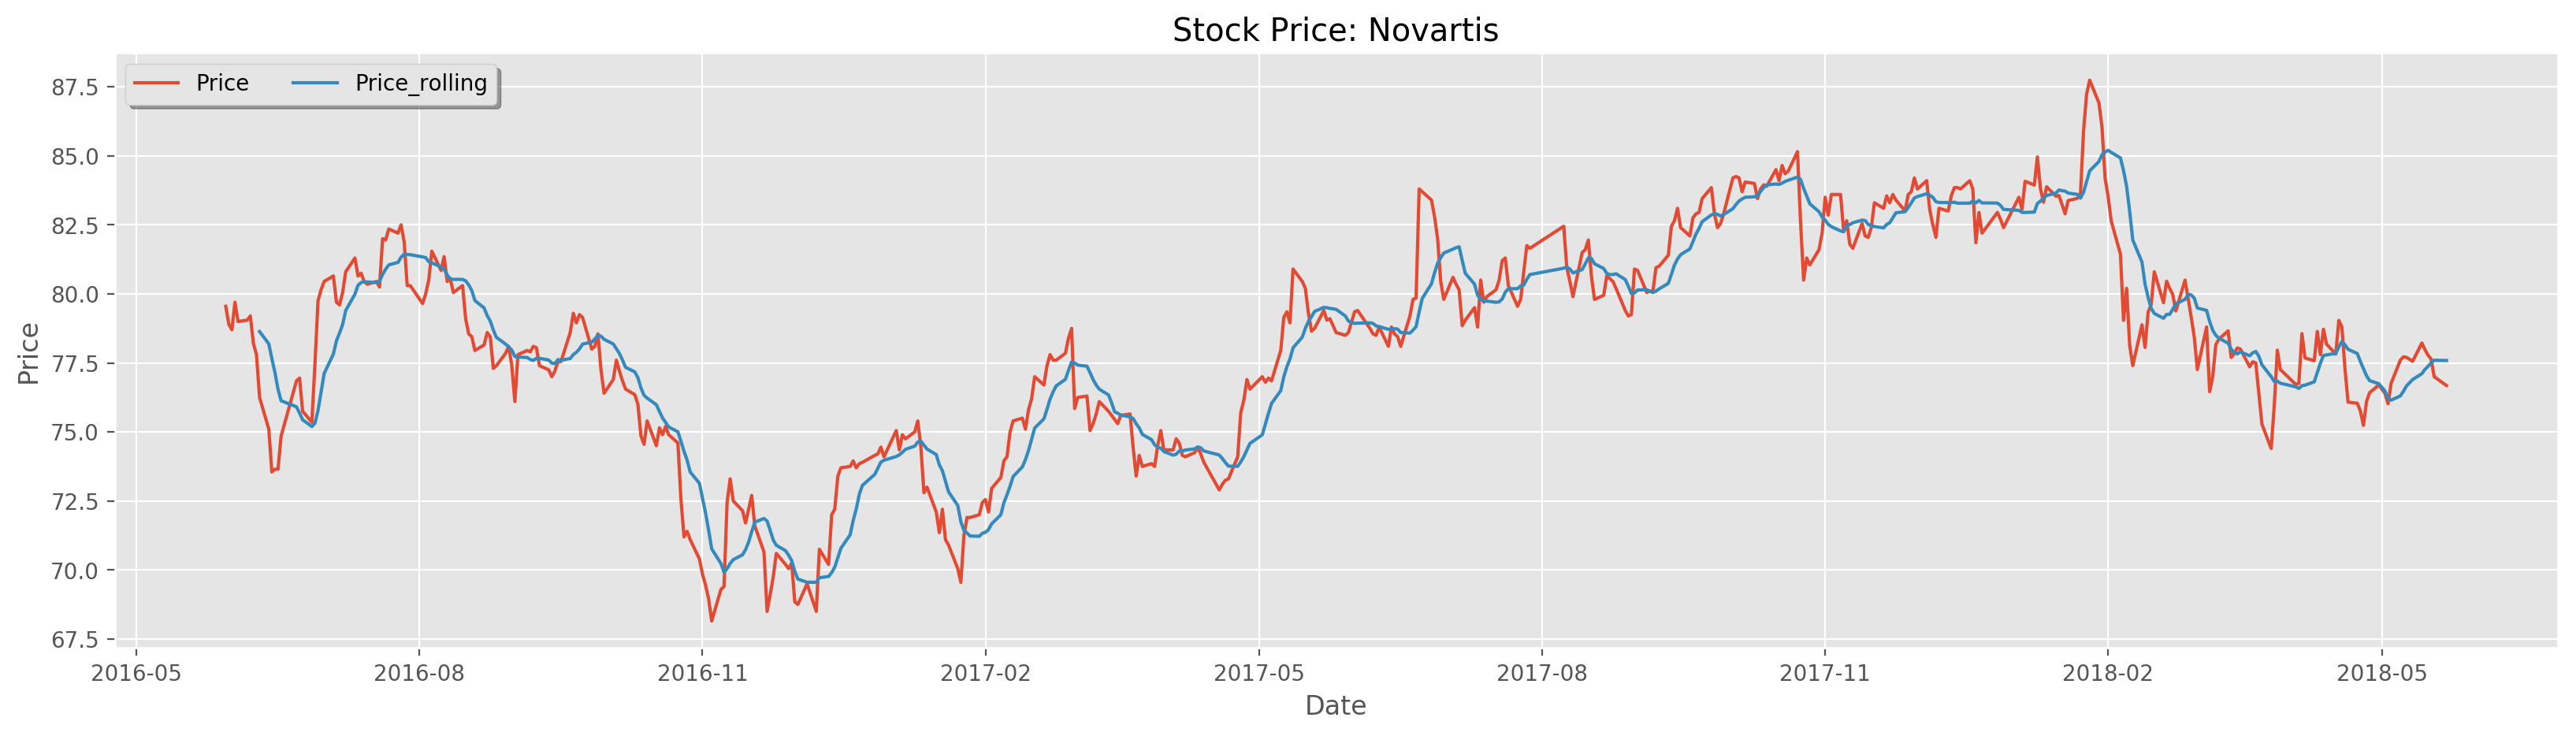

In [98]:
# Plot for Novartis
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price: Novartis')
plt.plot(Novartis_quandl_df['Price'])
plt.plot(Novartis_quandl_df['Price_rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='', fancybox=True)
plt.plot()
plt.show()

In [99]:
Novartis_quandl_df['PriceNormal'] = (Novartis_quandl_df['Price'] - Novartis_quandl_df['Price'].mean()) / (Novartis_quandl_df['Price'].max() - Nestle_quandl_df['Price'].min())
Novartis_quandl_df['VolumeNormal'] = (Novartis_quandl_df['Volume'] - Novartis_quandl_df['Volume'].mean()) / (Novartis_quandl_df['Volume'].max() - Nestle_quandl_df['Volume'].min())
Novartis_quandl_df.head()

Price     Volume  Price_rolling  PriceNormal  VolumeNormal
Date                                                                  
2016-05-30  79.55  2927407.0            NaN     0.062189     -0.093021
2016-05-31  78.90  4950541.0            NaN     0.030389     -0.011185
2016-06-01  78.70  3628933.0            NaN     0.020604     -0.064644
2016-06-02  79.70  5664433.0            NaN     0.069528      0.017692
2016-06-03  79.00  4685411.0            NaN     0.035281     -0.021909

In [100]:
Novartis_NZZ_other_df['SentimentNormal'] = (Novartis_NZZ_other_df['sentiment'] - Novartis_NZZ_other_df['sentiment'].mean()) / (Novartis_NZZ_other_df['sentiment'].max() - Novartis_NZZ_other_df['sentiment'].min())
Novartis_NZZ_other_df['Rolling Sentiment 5 Days'] = Novartis_NZZ_other_df['SentimentNormal'].rolling(5).mean()
Novartis_NZZ_other_df.loc[:,'Rolling Sentiment 5 Days'] *= 2
Novartis_NZZ_other_df['Rolling Sentiment 10 Days'] = Novartis_NZZ_other_df['SentimentNormal'].rolling(10).mean()
Novartis_NZZ_other_df.loc[:,'Rolling Sentiment 10 Days'] *= 3
Novartis_NZZ_other_df['Rolling Sentiment 20 Days'] = Novartis_NZZ_other_df['SentimentNormal'].rolling(20).mean()
Novartis_NZZ_other_df.loc[:,'Rolling Sentiment 20 Days'] *= 1

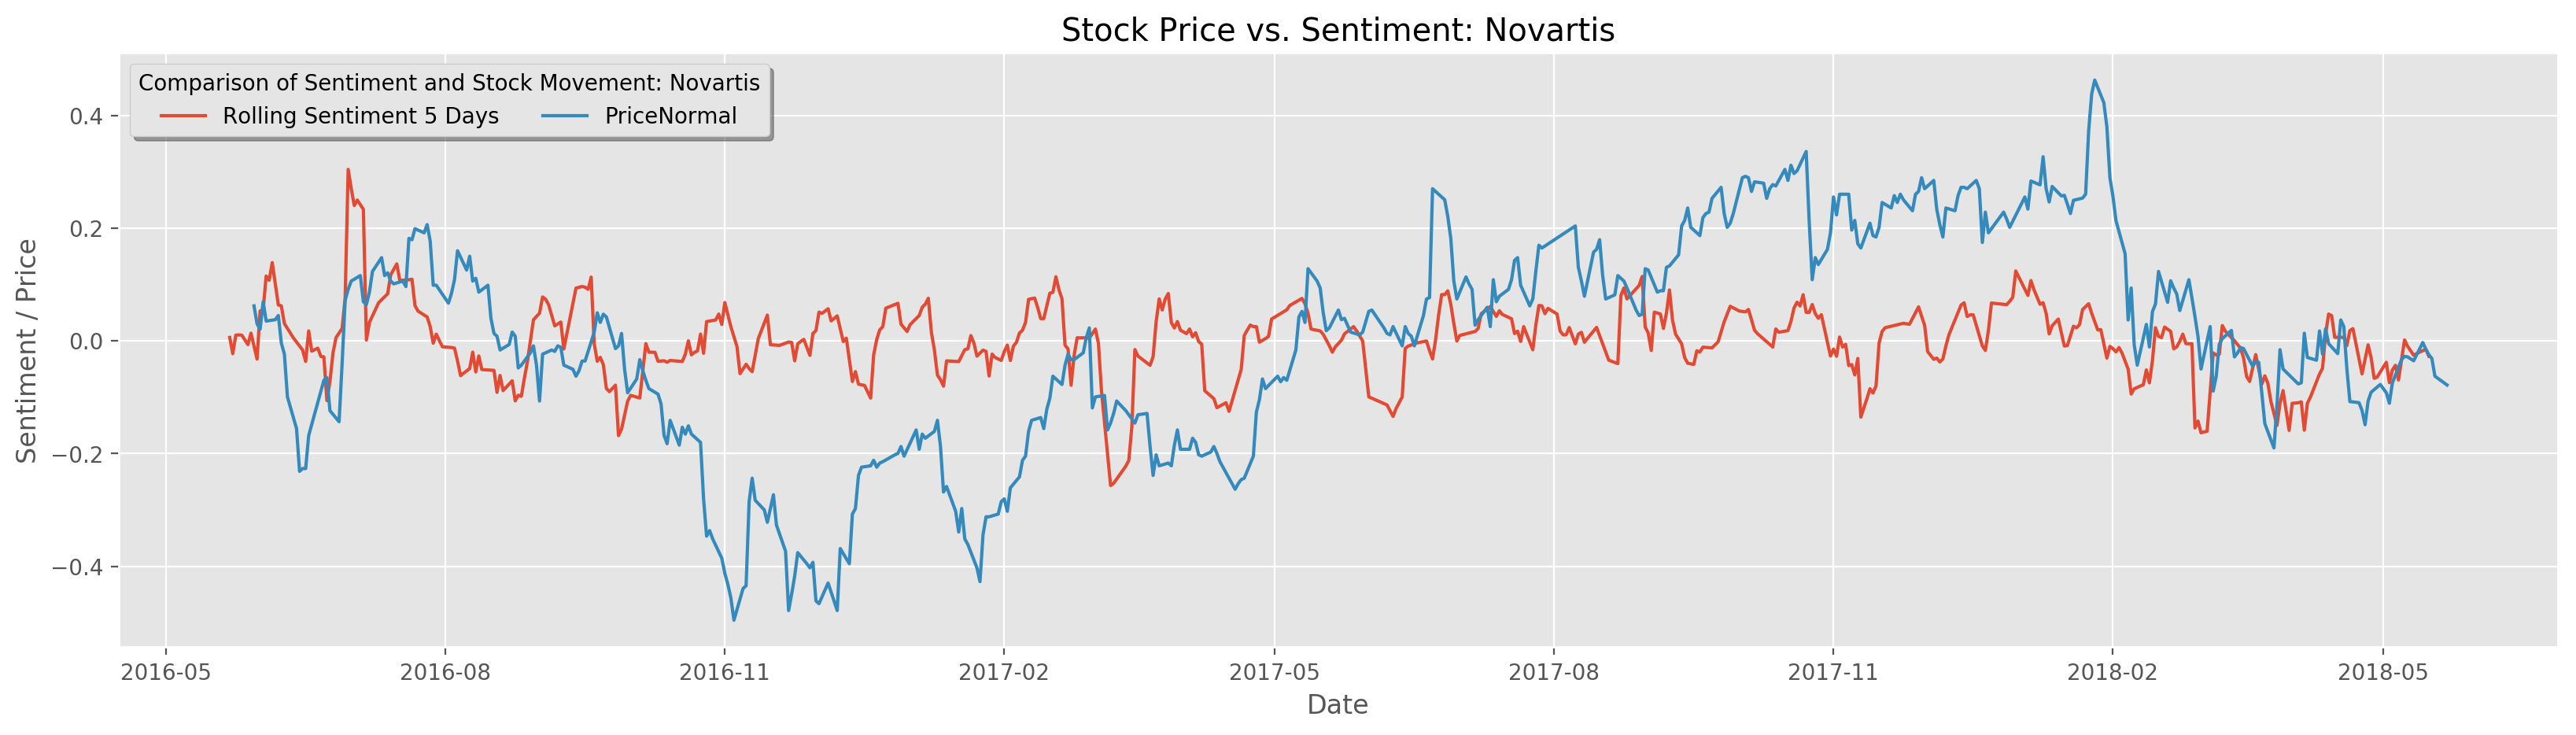

In [101]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Novartis')
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['Rolling Sentiment 5 Days'])
plt.plot(Novartis_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title ='Comparison of Sentiment and Stock Movement: Novartis', fancybox=True)
plt.savefig('Novartis_SentimentStockShort.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

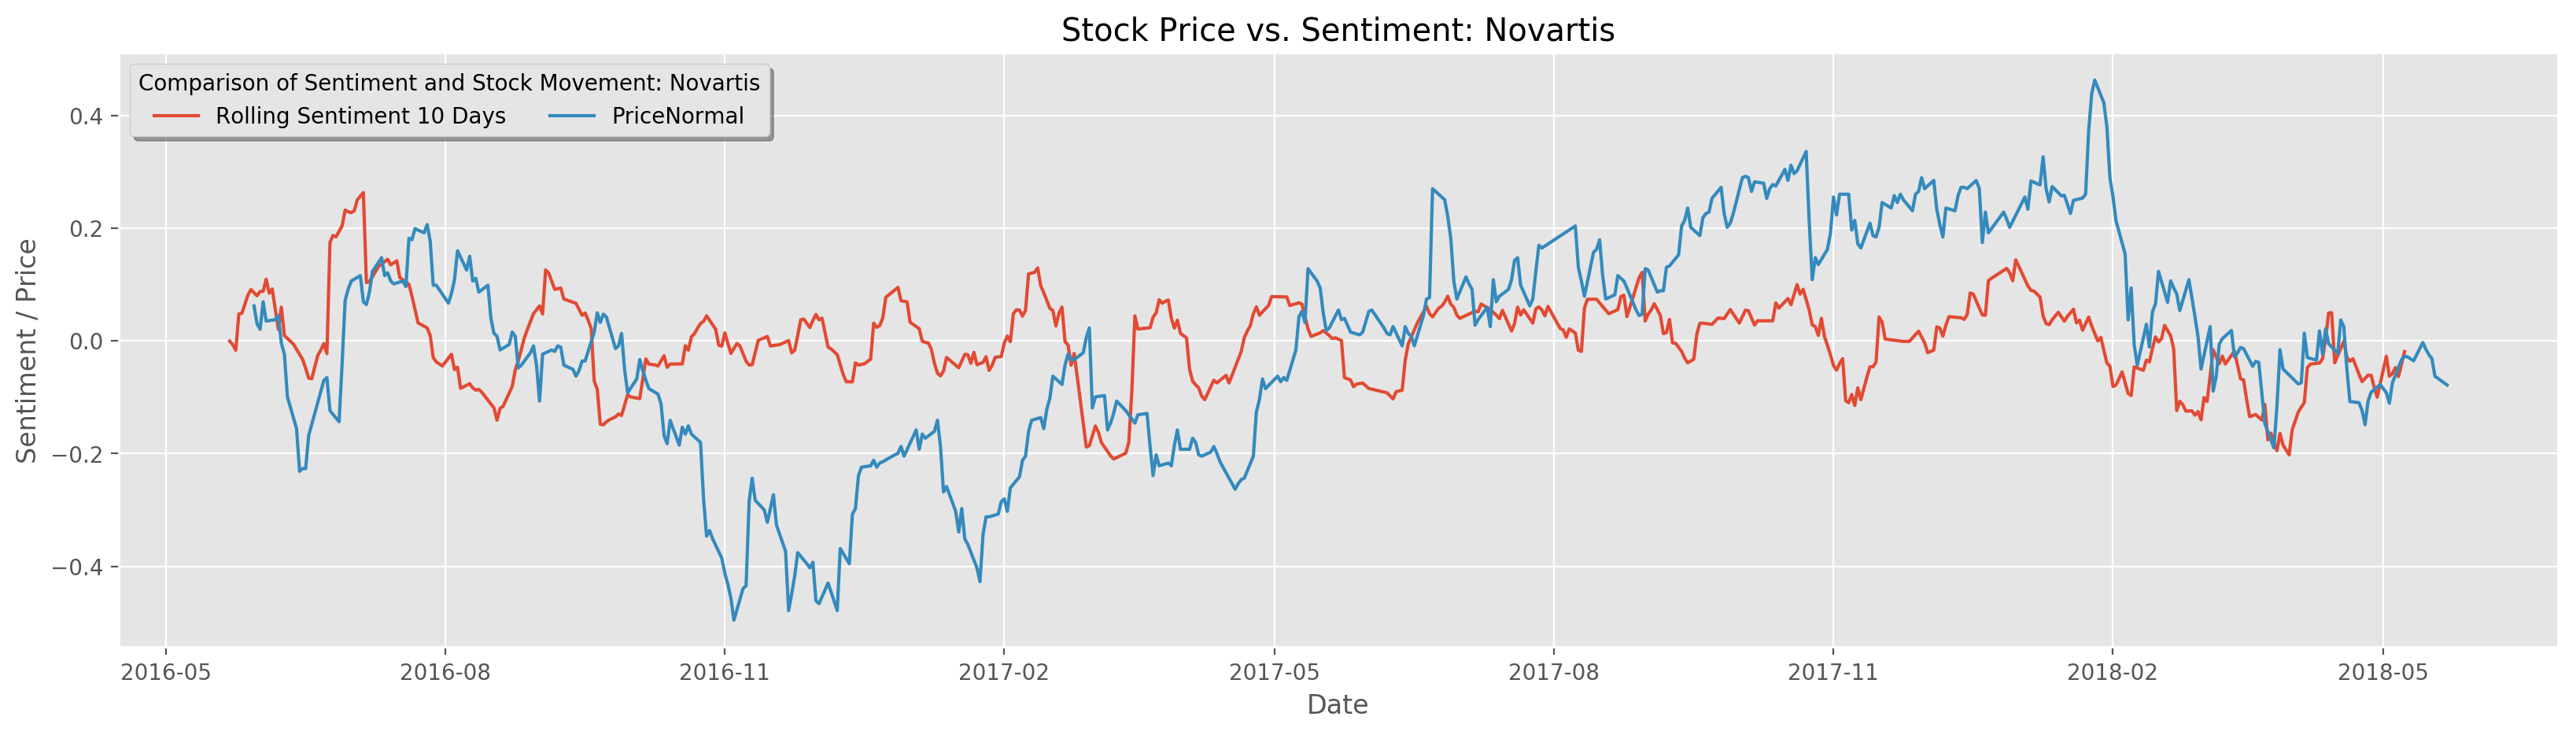

In [102]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Novartis')
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['Rolling Sentiment 10 Days'])
plt.plot(Novartis_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title ='Comparison of Sentiment and Stock Movement: Novartis', fancybox=True)
plt.savefig('Novartis_SentimentStockMid.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

In [103]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Novartis_WeightedSentiment.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Novartis_NZZ_other_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [104]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Novartis_NZZ_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Novartis_NZZ_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Roche Stock Data

In [105]:
Roche_quandl_df = quandl.get("SIX/CH0012032048CHF",start_date="2016-05-28", end_date="2018-05-22")
Roche_quandl_df.head()

Price     Volume
Date                        
2016-05-30  262.0  1161459.0
2016-05-31  260.9  2010281.0
2016-06-01  259.8  1034945.0
2016-06-02  259.9  1127449.0
2016-06-03  258.2  1401144.0

In [106]:
Roche_quandl_df['Price_rolling'] = Roche_quandl_df['Price'].rolling(10).mean()

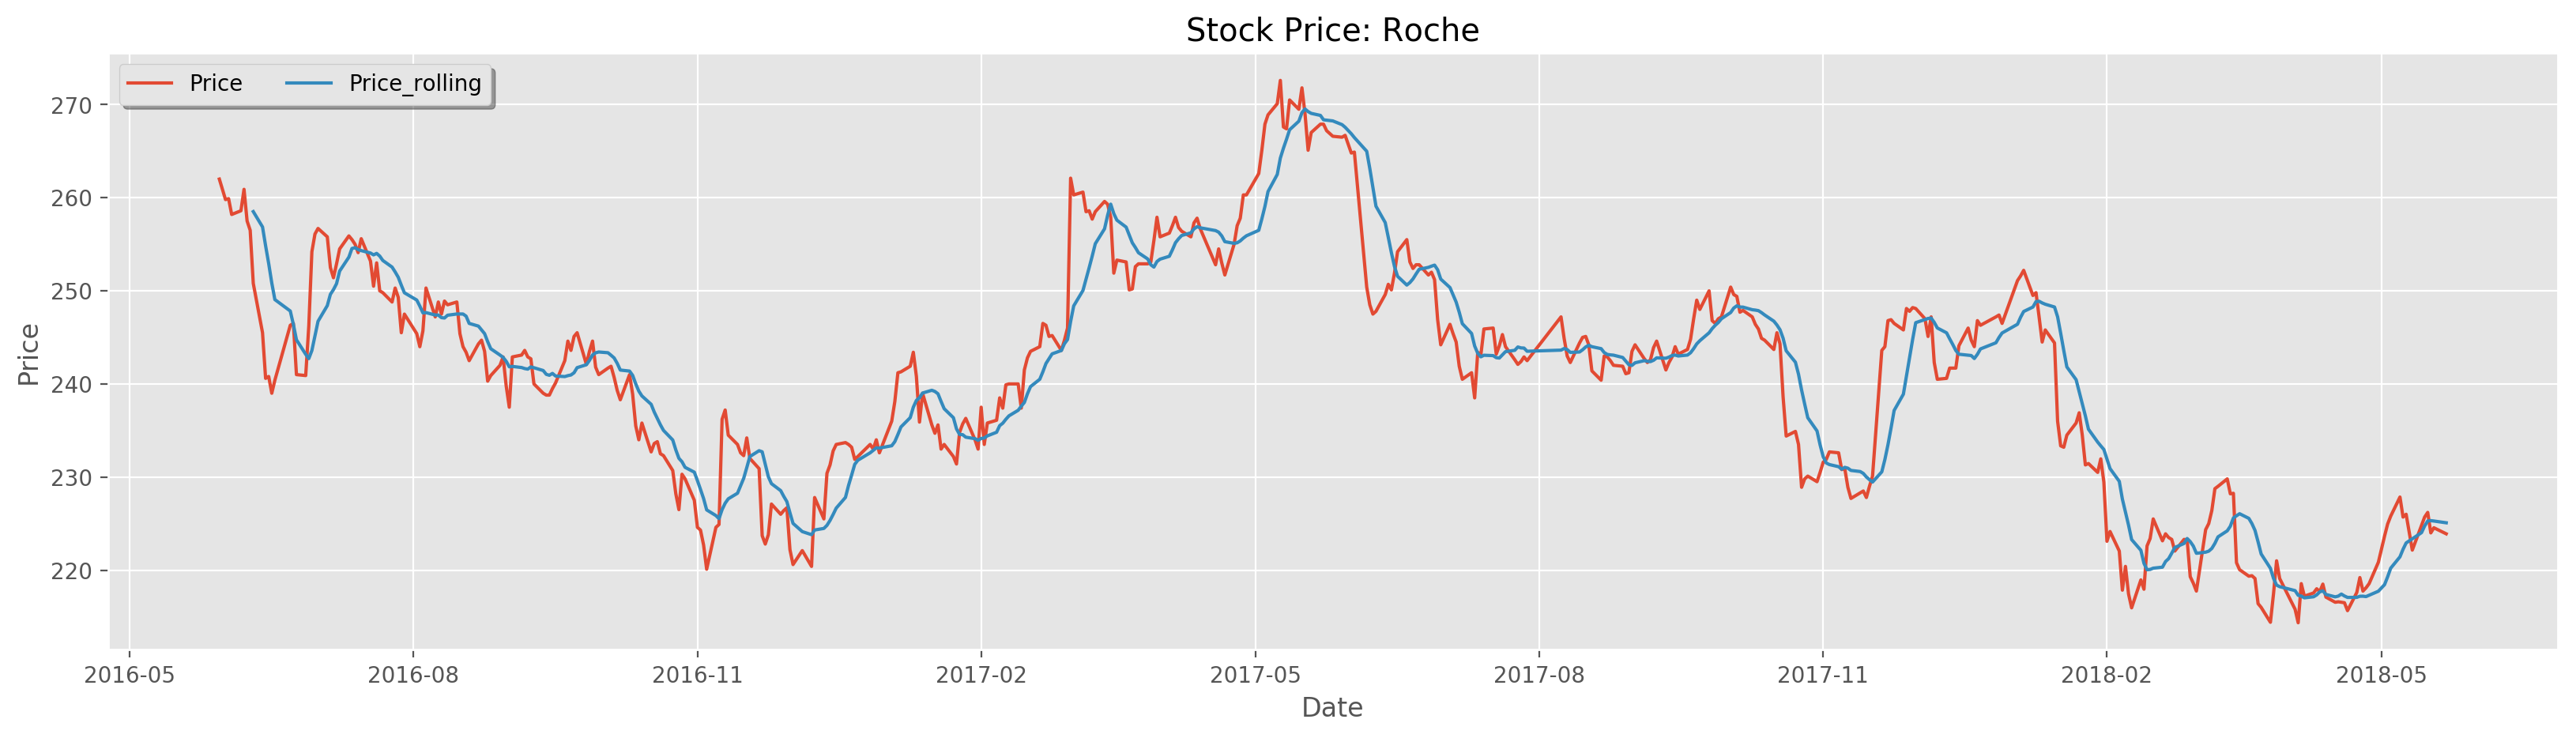

In [107]:
# Plot for Novartis
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price: Roche')
plt.plot(Roche_quandl_df['Price'])
plt.plot(Roche_quandl_df['Price_rolling'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True,title ='', fancybox=True)
plt.plot()
plt.show()

In [108]:
Roche_quandl_df['PriceNormal'] = (Roche_quandl_df['Price'] - Roche_quandl_df['Price'].mean()) / (Roche_quandl_df['Price'].max() - Roche_quandl_df['Price'].min())
Roche_quandl_df['VolumeNormal'] = (Roche_quandl_df['Volume'] - Roche_quandl_df['Volume'].mean()) / (Roche_quandl_df['Volume'].max() - Roche_quandl_df['Volume'].min())
Roche_quandl_df.head()

Price     Volume  Price_rolling  PriceNormal  VolumeNormal
Date                                                                  
2016-05-30  262.0  1161459.0            NaN     0.365277     -0.073017
2016-05-31  260.9  2010281.0            NaN     0.346393      0.036274
2016-06-01  259.8  1034945.0            NaN     0.327509     -0.089307
2016-06-02  259.9  1127449.0            NaN     0.329226     -0.077396
2016-06-03  258.2  1401144.0            NaN     0.300041     -0.042156

In [109]:
Roche_NZZ_other_df['SentimentNormal'] = (Roche_NZZ_other_df['sentiment'] - Roche_NZZ_other_df['sentiment'].mean()) / (Roche_NZZ_other_df['sentiment'].max() - Roche_NZZ_other_df['sentiment'].min())
Roche_NZZ_other_df['Rolling Sentiment 5 Days'] = Roche_NZZ_other_df['SentimentNormal'].rolling(5).mean()
Roche_NZZ_other_df.loc[:,'Rolling Sentiment 5 Days'] *= 2
Roche_NZZ_other_df['Rolling Sentiment 10 Days'] = Roche_NZZ_other_df['SentimentNormal'].rolling(10).mean()
Roche_NZZ_other_df.loc[:,'Rolling Sentiment 10 Days'] *= 3
Roche_NZZ_other_df['Rolling Sentiment 20 Days'] = Roche_NZZ_other_df['SentimentNormal'].rolling(20).mean()
Roche_NZZ_other_df.loc[:,'Rolling Sentiment 20 Days'] *= 1

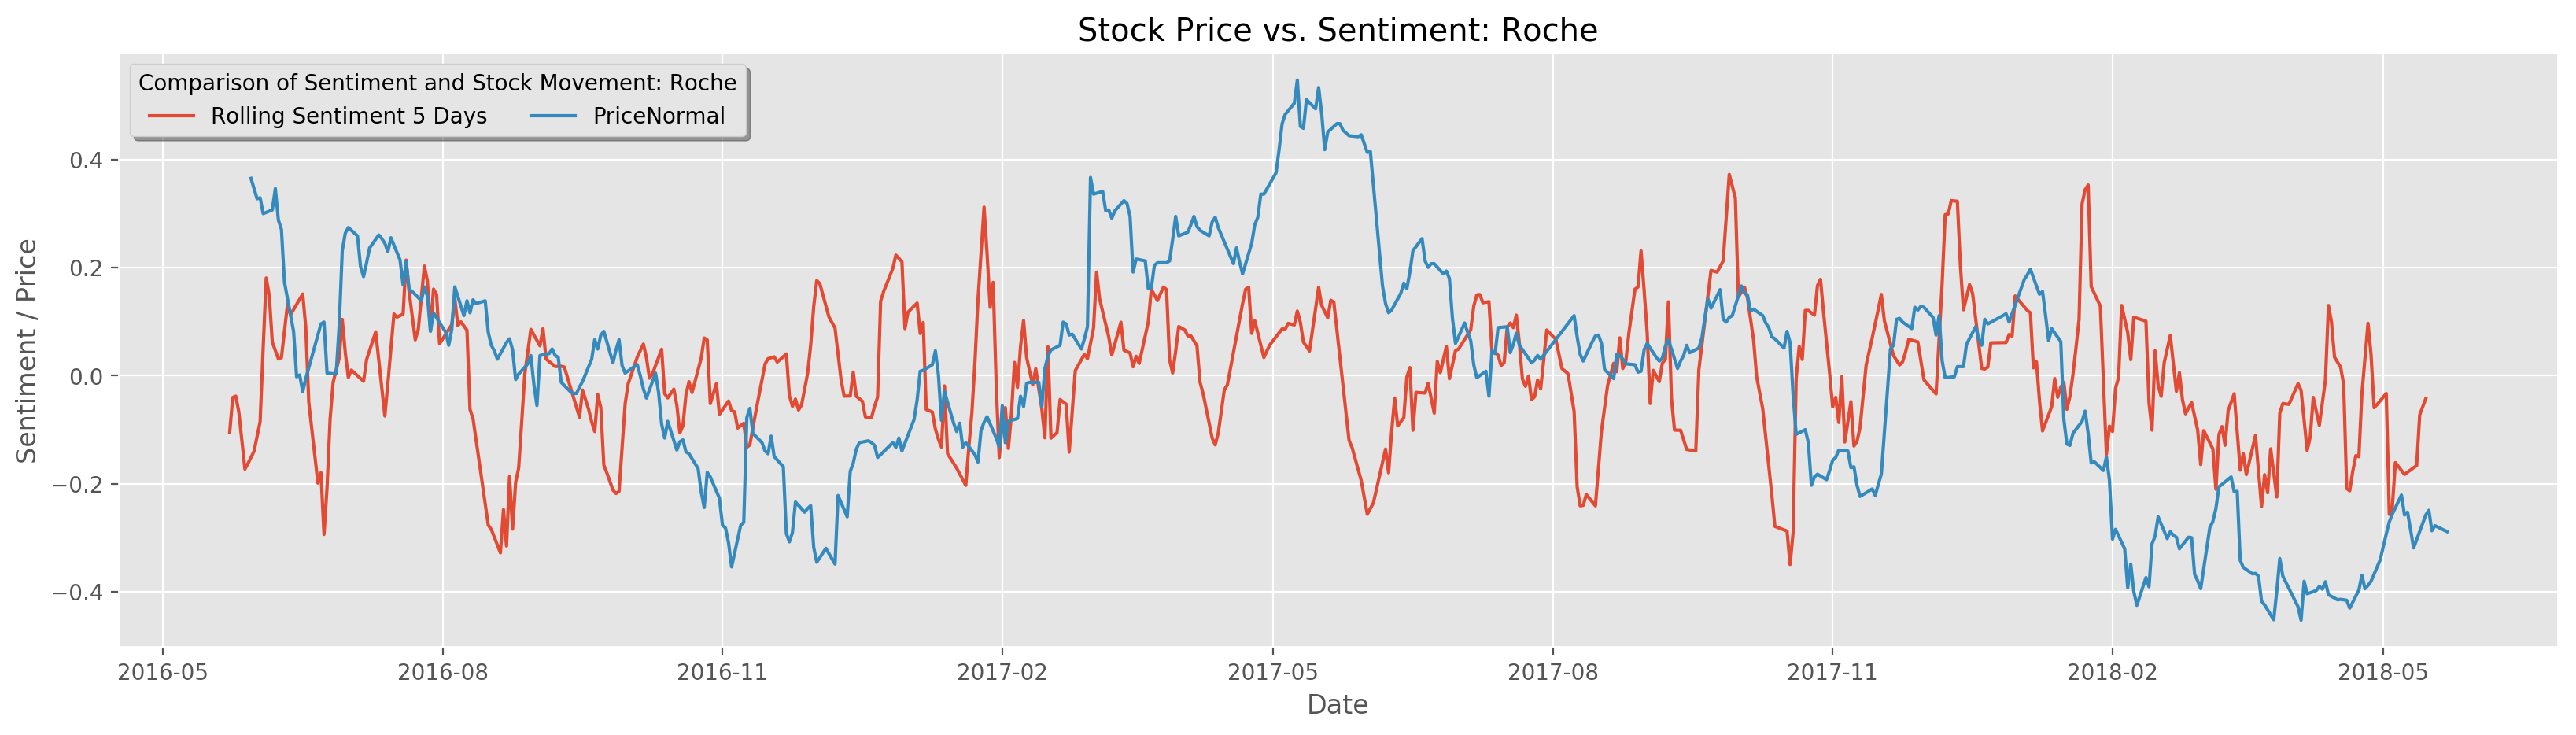

In [110]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Roche')
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['Rolling Sentiment 5 Days'])
plt.plot(Roche_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title ='Comparison of Sentiment and Stock Movement: Roche', fancybox=True)
plt.savefig('Roche_SentimentStockShort.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

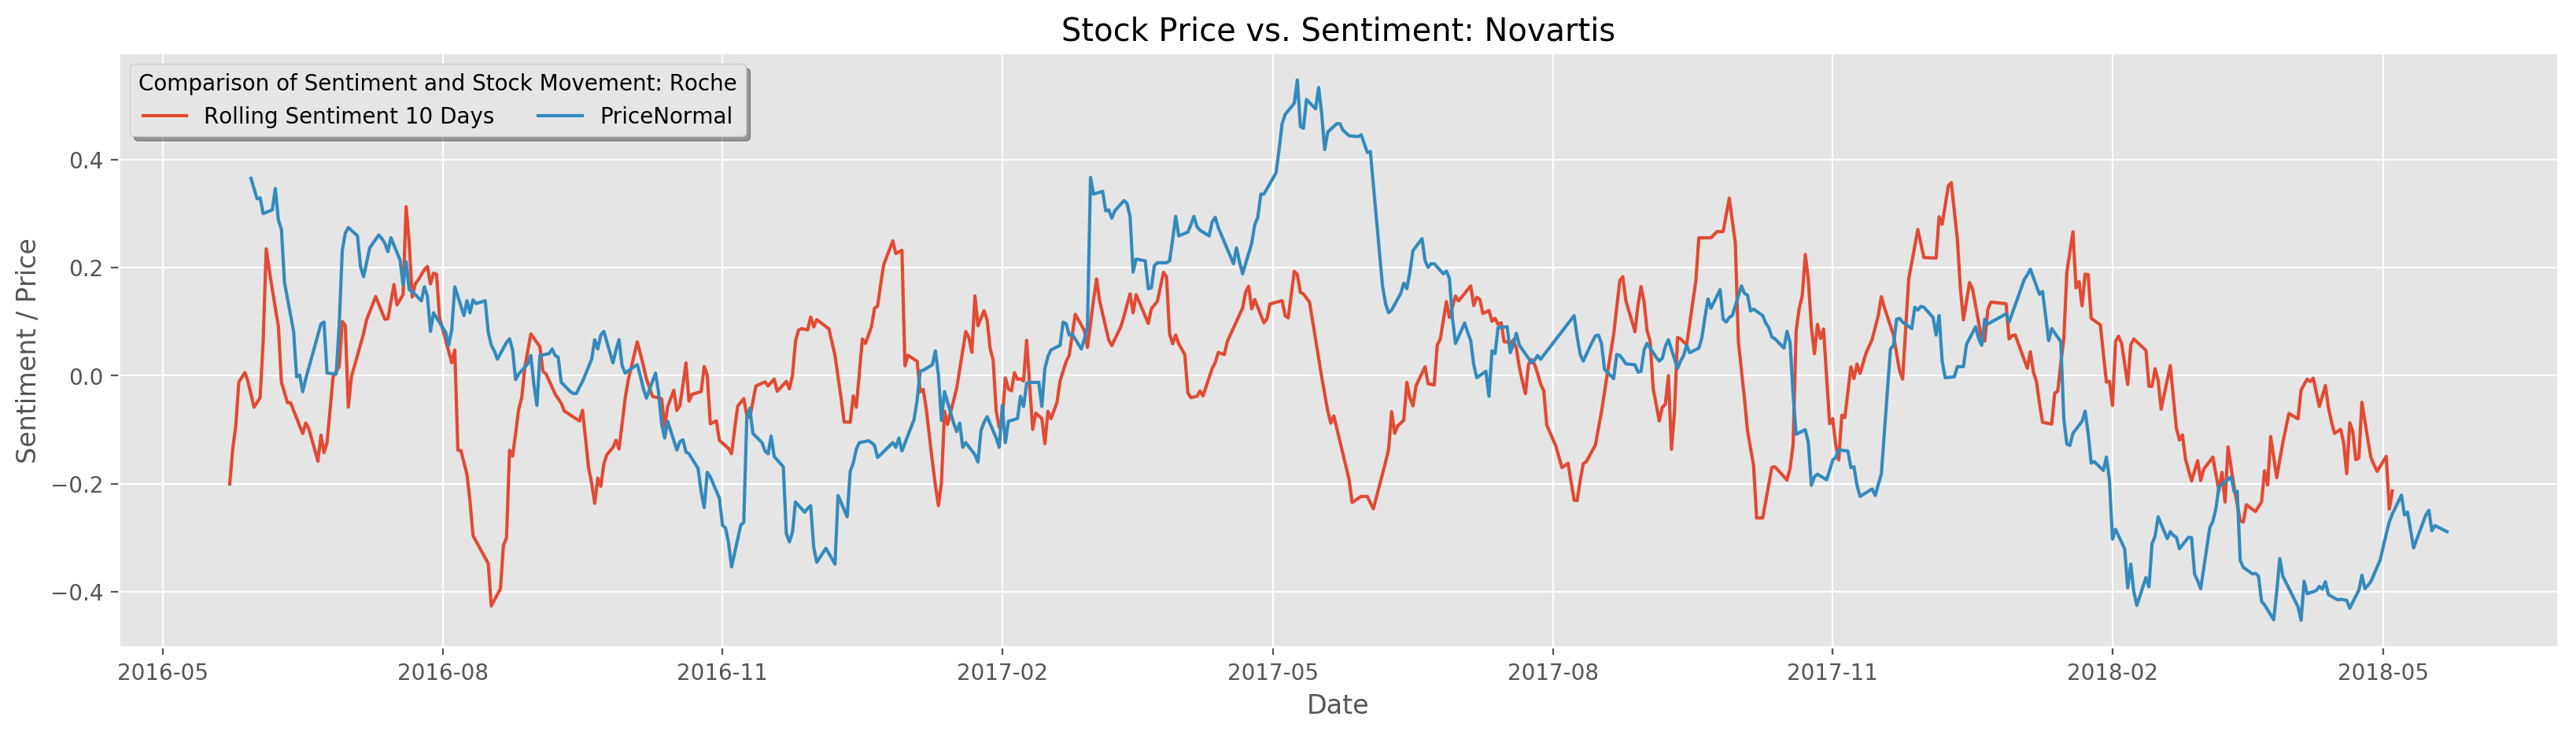

In [111]:
plt.figure(figsize=(20,5), dpi = 200)
plt.xlabel('Date')
plt.ylabel('Sentiment / Price')
plt.title('Stock Price vs. Sentiment: Novartis')
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['Rolling Sentiment 10 Days'])
plt.plot(Roche_quandl_df['PriceNormal'])
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title ='Comparison of Sentiment and Stock Movement: Roche', fancybox=True)
plt.savefig('Roche_SentimentStockMid.eps', format='eps', dpi=1000)
plt.plot()
plt.show()

In [112]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Roche_WeightedSentiment.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Roche_NZZ_other_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [113]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Roche_NZZ_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Roche_NZZ_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()